<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Aegon/Aegon_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AGNNLEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-03 01:51:06,867 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-03 01:51:06,869 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AGNNLEUR
2019-09-03 01:51:16,892 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-03 01:54:35,205 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-03 02:01:37,921 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-03 02:05:18,672 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-03 02:08:52,883 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-03 02:12:17,821 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-03 02:15:52,063 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-03 02:19:15,018 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-09-03 02:33:03,809 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AGNNLEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AGNNLEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AGNNLEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.05317  0.05328  0.05250  0.05279  2.087652
2018-01-02 09:00:00  0.05280  0.05284  0.05251  0.05255  1.473801
2018-01-02 10:00:00  0.05256  0.05280  0.05255  0.05263  1.428694
2018-01-02 11:00:00  0.05263  0.05270  0.05257  0.05268  1.150541
2018-01-02 12:00:00  0.05267  0.05276  0.05257  0.05273  0.683843
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.03961  0.04086  0.03961  0.04058  2.578431
2018-12-31 09:00:00  0.04057  0.04074  0.04036  0.04067  2.037865
2018-12-31 10:00:00  0.04068  0.04076  0.04047  0.04056  1.846822
2018-12-31 11:00:00  0.04056  0.04073  0.04038  0.04043  1.499202
2018-12-31 12:00:00  0.04042  0.04071  0.04038  0.04068  1.566626

[2280 rows x 5 columns]

Open         High          Low        Close       Volume
count  2280.000000  2280.000000  2280.000000  2280.000000  2280.000000
mean      0.053920     0.054086     0.053748     0.053920     3.509422
std       0.003829     0.003827     0.003841     0.003838     2.181474
min       0.039250     0.039560     0.037470     0.037470     0.011360
25%       0.052420     0.052540     0.052280     0.052418     2.197868
50%       0.054310     0.054495     0.054130     0.054320     2.971132
75%       0.056200     0.056360     0.056042     0.056200     4.137280
max       0.061260     0.061320     0.061070     0.061240    23.124201

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.05520  0.05544  0.05515  0.05538  1.540018    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.055025  0.053900  0.054279  0.055413  0.054965  0.055091    0.054700    0.054655  0.054187  0.054928  0.055494  0.055044  0.055157  0.054928  0.055270  0.054152                0.056015                 0.054928                0.053840                0.056558                 0.054928                0.053297                0.057102                 0.054928                0.052753                0.057646                 0.054928                0.052209  0.054965  0.055286  0.054231                0.056053                 0.054965                0.053878                0.056596                 0.054965                0.053334                0.057140                 0.054965                0.052791                0.057684                 0.054965   
2018-01-09 14:00:00  0.05537  0.05540  0.05513  0.05536  4.097800    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.055041  0.053929  0.054423  0.055469  0.055053  0.055161    0.054700    0.054715  0.054290  0.055095  0.055508  0.055192  0.055253  0.055095  0.055370  0.054260                0.055962                 0.055095                0.054228                0.056396                 0.055095                0.053794                0.056829                 0.055095                0.053361                0.057263                 0.055095                0.052927  0.055053  0.055349  0.054347                0.055920                 0.055053                0.054186                0.056354                 0.055053                0.053752                0.056787                 0.055053                0.053319                0.057221                 0.055053   
2018-01-09 15:00:00  0.05536  0.05554  0.05521  0.05526 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000    2230.000000  2230.000000   2230.000000     2230.000000     2230.000000       2230.000000  2230.000000  2230.000000  2230.000000  2230.000000   2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000  2230.000000  2230.000000  2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000   
mean      0.053929     0.054095     0.053756     0.053928     3.550028    16.000897     2.016143   185.556054      30.424664    11.376682      0.034081        0.023767        0.002242          0.004036     6.601345     2.535426    26.960538     2.016143      2.004933    26.960538     0.053952     0.054004     0.000156     0.053929     0.053951     0.053928     0.053936     0.053919     0.053934     0.053951     0.053928     0.053951     0.053943     0.053951     0.053932     0.053994                0.054470                 0.053951                0.053432                0.054729                 0.053951                0.053173                0.054988                 0.053951                0.052914                0.055248                 0.053951                0.052655     0.053951     0.053933     0.053988                0.054469                 0.053951                0.053432                0.054729                 0.053951                0.053173                0.054988   
std       0.003870     0.003868     0.003883     0.003879     2.186682     8.583687     1.412534   101.928116       0.853789     2.619729      0.181477        0.152356        0.047309          0.063414     3.353724     1.103586    14.561984     1.412534      1.405135    14.561984     0.003831     0.003711     0.054070     0.003885     0.003824     0.003807     0.003842     0.003852     0.003824     0.003830     0.003882     0.003833     0.003844     0.003830     0.003869     0.003729                0.003826                 0.003830                0.003868                0.003837                 0.003830                0.003899                0.003855                 0.003830                0.003937                0.003882                 0.003830                0.003984     0.003824     0.003867     0.003745                0.003819                 0.003824                0.003861                0.003829                 0.003824                0.003893                0.003848   
min       0.039250     0.039560     0.0374

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.724671  0.729779  0.749152  0.753471  0.066139    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.727081  0.668191  0.948123  0.740467  0.718018  0.731196    0.716091    0.710255  0.700908  0.717448  0.748827  0.720876  0.726006  0.717448  0.734248  0.680641                0.738599                 0.717448                0.694497                0.736312                 0.717448                0.683441                0.733175                 0.717448                0.674801                0.728908                 0.717448                0.666853  0.718018  0.743031  0.684238                0.742230                 0.718018                0.698123                0.747123                 0.718018                0.688580                0.743813                 0.718018                0.679825                0.739120                 0.718018   
2018-01-09 14:00:00  0.732394  0.727941  0.748305  0.752629  0.176804    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.727841  0.669561  0.949304  0.743033  0.722122  0.734545    0.716091    0.713008  0.705247  0.725255  0.749461  0.727786  0.730484  0.725255  0.738749  0.685803                0.736142                 0.725255                0.711405                0.728891                 0.725255                0.704318                0.721174                 0.725255                0.699232                0.712693                 0.725255                0.694554  0.722122  0.745823  0.689774                0.736063                 0.722122                0.711459                0.735975                 0.722122                0.705907                0.728199                 0.722122                0.700812                0.719400                 0.722122   
2018-01-09 15:00:00  0.731940  0.734375  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp04qkacyy
  JVM stdout: /tmp/tmp04qkacyy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp04qkacyy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_avkoto
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.577508  1.687890              0.436044  0.674298  0.454678
1  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.541019  0.724584              0.479854  0.513552  0.263735
2  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.535680  0.690218              0.495833  0.498535  0.248537
3  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.519660  9.984505              0.435316  0.734717  0.539809
4  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.503236  0.697751              0.491667  0.502203  0.252208
5  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.500000  0.690537              0.500000  0.498694  0.248696
6  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.496521  2.179189              0.465939  0.650776  0.423509
7              DeepLearning_1_AutoML_20190903_024253  0.495833  0.693653              0.500000  0.500253  0.250253
8  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.472047  0.691893              0.483333  0.499369  0.249370
9  DeepLearning_grid_1_AutoML_20190903_024253_mod...  0.446926  0.690477              0.500000  0.498664  0.248666

variable  relative_importance  scaled_importance  percentage
0            CDLINVERTEDHAMMER             1.000000           1.000000    0.003684
1            CDLDARKCLOUDCOVER             0.971960           0.971960    0.003581
2            CDL3WHITESOLDIERS             0.964556           0.964556    0.003554
3               CDLMORNINGSTAR             0.963667           0.963667    0.003551
4              CDLHOMINGPIGEON             0.963548           0.963548    0.003550
...                        ...                  ...                ...         ...
1022  BBANDS_middleband_14_5_2             0.200197           0.200197    0.000738
1023  BBANDS_middleband_12_7_3             0.199352           0.199352    0.000735
1024  BBANDS_middleband_24_2_5             0.199228           0.199228    0.000734
1025  BBANDS_middleband_24_7_5             0.199000           0.199000    0.000733
1026  BBANDS_middleband_14_4_4             0.197727           0.197727    0.000729

[1027 rows x 4 columns]

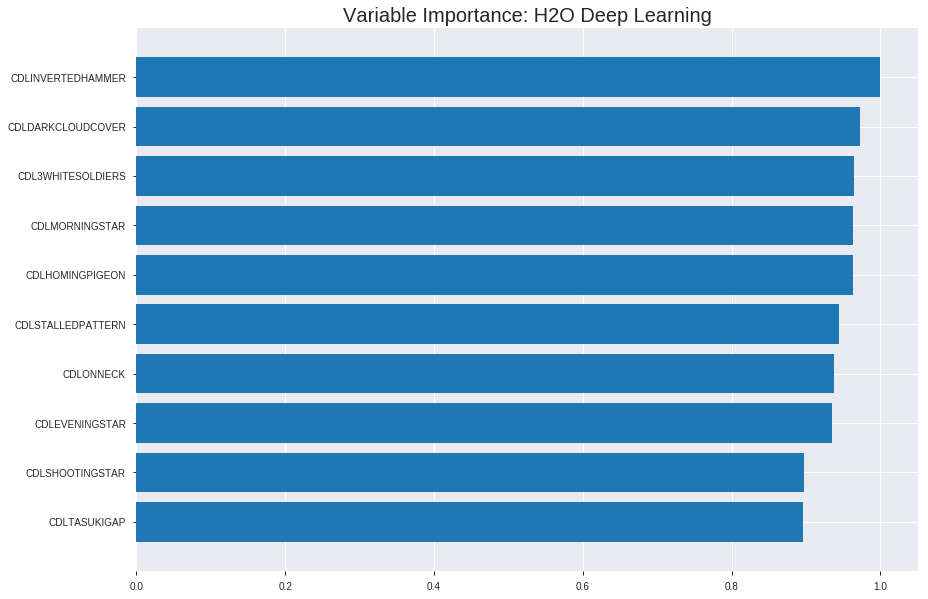

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024253_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24963699987837187
RMSE: 0.4996368680135323
LogLoss: 0.6972733870764799
Mean Per-Class Error: 0.4019706328681044
AUC: 0.6198829063299963
pr_auc: 0.6118548902885033
Gini: 0.23976581265999264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34971649380283054: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      66   701   0.914    (701.0/767.0)
1      17   776   0.0214   (17.0/793.0)
Total  83   1477  0.4603   (718.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349716     0.6837    350
max f2                       0.290455     0.840972  370
max f0point5                 0.564192     0.609311  226
max accuracy                 0.564192     0.6       226
max precision                0.966411     1         0
max recall                   0.195564     1         390
max specificity              0.966411     1         0
max absolute_mcc             0.564192     0.20192   226
max min_per_class_accuracy   0.612726     0.580183  188
max mean_per_class_accuracy  0.564192     0.598029  226

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 60.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.89885            1.59836   1.59836            0.8125           0.919019  0.8125                      0.919019            0.0163934       0.0163934                  59.8361   59.8361
    2        0.0205128                   0.877276           1.59836   1.59836            0.8125           0.886675  0.8125                      0.902847            0.0163934       0.0327869                  59.8361   59.8361
    3        0.0301282                   0.863877           1.31148   1.5068             0.666667         0.870669  0.765957                    0.892577            0.0126103       0.0453972                  31.1475   50.6802
    4        0.0403846                   0.852508           1.47541   1.49883            0.75             0.85689   0.761905                    0.883514            0.0151324       0.0605296                  47.541    49.8829
    5        0.05                        0.843798           0.786885  1.36192            0.4              0.848172  0.692308                    0.876717            0.0075662       0.0680958                  -21.3115  36.1917
    6        0.1                         0.80787            1.28625   1.32409            0.653846         0.824956  0.673077                    0.850837            0.0643127       0.132409                   28.6255   32.4086
    7        0.15                        0.776189           1.21059   1.28625            0.615385         0.791233  0.653846                    0.830969            0.0605296       0.192938                   21.0593   28.6255
    8        0.2                         0.751298           1.16015   1.25473            0.589744         0.764578  0.637821                    0.814371            0.0580076       0.250946                   16.0151   25.4729
    9        0.3                         0.69806            1.12232   1.21059            0.570513         0.725035  0.615385                    0.784592            0.112232        0.363178                   12.232    21.0593
    10       0.4                         0.654398           1.0971    1.18222            0.557692         0.675952  0.600962                    0.757432            0.10971         0.472888                   9.70996   18.2219
    11       0.5                         0.612602           1.05927   1.15763            0.538462         0.630993  0.588462                    0.732144            0.105927        0.578815                   5.92686   15.7629
    12       0.6                         0.572399           1.13493   1.15385            0.576923         0.593738  0.586538                    0.709077            0.113493        0.692308                   13.4931   15.3846
    13       0.7                         0.523925           0.882724  1.11511            0.448718         0.549534  0.56685                     0.686285            0.0882724       0.78058                    -11.7276  11.5114
    14       0.8                         0.469953           0.844893  1.08134            0.429487         0.498526  0.549679                    0.662815            0.0844893       0.865069                   -15.5107  8.13367
    15       0.9                         0.406457           0.781841  1.04806            0.397436         0.440969  0.532764                    0.638165            0.0781841       0.943253                   -21.8159  4.80594
    16       1                           0.0642262          0.567465  1                  0.288462         0.322289  0.508333                    0.606578         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27321591749130103
RMSE: 0.5227006002400428
LogLoss: 0.7536118248493487
Mean Per-Class Error: 0.4514748817074399
AUC: 0.531682271217155
pr_auc: 0.49283073033435837
Gini: 0.06336454243430989
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1545572466210158: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    227  0.9827   (227.0/231.0)
1      1    214  0.0047   (1.0/215.0)
Total  5    441  0.5112   (228.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.154557     0.652439   394
max f2                       0.0513426    0.823124   399
max f0point5                 0.275926     0.54717    364
max accuracy                 0.458321     0.544843   238
max precision                0.873113     0.636364   10
max recall                   0.0513426    1          399
max specificity              0.931515     0.995671   0
max absolute_mcc             0.458321     0.0990249  238
max min_per_class_accuracy   0.50035      0.515152   204
max mean_per_class_accuracy  0.458321     0.548525   238

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.895279           0.829767  0.829767           0.4              0.911973  0.4                         0.911973            0.00930233      0.00930233                 -17.0233   -17.0233
    2        0.0201794                   0.874729           1.55581   1.15245            0.75             0.887341  0.555556                    0.901026            0.0139535       0.0232558                  55.5814    15.2455
    3        0.0313901                   0.853981           0.829767  1.03721            0.4              0.864791  0.5                         0.888085            0.00930233      0.0325581                  -17.0233   3.72093
    4        0.0403587                   0.831593           0.518605  0.921964           0.25             0.840436  0.444444                    0.877496            0.00465116      0.0372093                  -48.1395   -7.80362
    5        0.0515695                   0.815937           0.829767  0.901921           0.4              0.823574  0.434783                    0.865774            0.00930233      0.0465116                  -17.0233   -9.80789
    6        0.100897                    0.762832           1.1315    1.01416            0.545455         0.782417  0.488889                    0.825022            0.055814        0.102326                   13.1501    1.41602
    7        0.150224                    0.711437           0.754334  0.928844           0.363636         0.736263  0.447761                    0.795877            0.0372093       0.139535                   -24.5666   -7.11558
    8        0.201794                    0.669213           1.26269   1.01416            0.608696         0.687775  0.488889                    0.768251            0.0651163       0.204651                   26.269     1.41602
    9        0.300448                    0.615296           1.17865   1.06817            0.568182         0.642133  0.514925                    0.726839            0.116279        0.32093                    17.8647    6.81708
    10       0.401345                    0.547611           1.06026   1.06618            0.511111         0.579911  0.513966                    0.689902            0.106977        0.427907                   6.02584    6.61816
    11       0.5                         0.499901           0.895772  1.03256            0.431818         0.527856  0.497758                    0.657929            0.0883721       0.516279                   -10.4228   3.25581
    12       0.600897                    0.458321           1.33685   1.08365            0.644444         0.478057  0.522388                    0.627726            0.134884        0.651163                   33.6848    8.36515
    13       0.699552                    0.415201           0.848626  1.05051            0.409091         0.437542  0.50641                     0.600905            0.0837209       0.734884                   -15.1374   5.05069
    14       0.800448                    0.360787           0.875866  1.02849            0.422222         0.387444  0.495798                    0.573998            0.0883721       0.823256                   -12.4134   2.84933
    15       0.899103                    0.282952           0.990063  1.02428            0.477273         0.324358  0.493766                    0.546606            0.0976744       0.92093                    -0.993658  2.42765
    16       1                           0.0513426          0.783669  1                  0.377778         0.221616  0.482063                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:45:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:45:30  2 min 28.637 sec  457 obs/sec       0.292308  1             456        0.65962          2.22422             -0.740877      0.524704        0.500262           1.10656          0.491667                         0.648971           2.14975               -0.686824        0.487416          0.459167             0.829767           0.517937
    2019-09-03 02:45:39  2 min 37.715 sec  508 obs/sec       2.99167   10            4667       0.665417         4.57423             -0.771611      0.546059        0.416158           1.35246          0.491667                         0.676756           3.8417                -0.834353        0.531632          0.473025             1.65953            0.517937
    2019-09-03 02:45:48  2 min 47.160 sec  526 obs/sec       5.99295   20            9349       0.679583         4.78012             -0.847843      0.522044        0.388266           1.02637          0.48141                          0.686847           3.02726               -0.88947         0.508426          0.465042             0.829767           0.497758
    2019-09-03 02:45:57  2 min 55.779 sec  534 obs/sec       8.72949   29            13618      0.587211         1.87782             -0.379651      0.590908        0.565179           1.22951          0.491667                         0.629915           2.02742               -0.589218        0.523709          0.486495             1.24465            0.506726
    2019-09-03 02:46:06  3 min  5.089 sec  538 obs/sec       11.7051   39            18260      0.594638         1.53777             -0.414769      0.582835        0.589312           1.72131          0.491667                         0.624985           1.73236               -0.564438        0.531471          0.507468             1.24465            0.517937
    2019-09-03 02:46:16  3 min 14.579 sec  539 obs/sec       14.7096   49            22947      0.560253         1.31536             -0.255883      0.58851         0.601603           1.47541          0.491667                         0.570902           1.05905               -0.305396        0.537642          0.521893             2.07442            0.5
    2019-09-03 02:46:25  3 min 23.861 sec  542 obs/sec       17.7346   59            27666      0.548794         1.02666             -0.205036      0.580742        0.588643           1.35246          0.486538                         0.55464            0.933551              -0.232086        0.541558          0.509014             1.65953            0.517937
    2019-09-03 02:46:34  3 min 33.033 sec  546 obs/sec       20.7571   69            32381      0.529937         0.80909             -0.123646      0.576353        0.595398           1.59836          0.483974                         0.544145           0.837306              -0.185903        0.530967          0.492081             0.829767           0.470852
    2019-09-03 02:46:43  3 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLINVERTEDHAMMER         1.0                    1.0                  0.003684457372638806
CDLDARKCLOUDCOVER         0.971960186958313      0.971960186958313    0.0035811458767499487
CDL3WHITESOLDIERS         0.9645556211471558     0.9645556211471558   0.003553864069655841
CDLMORNINGSTAR            0.9636669754981995     0.9636669754981995   0.0035505898926428804
CDLHOMINGPIGEON           0.9635481834411621     0.9635481834411621   0.0035501522083725185
---                       ---                    ---                  ---
BBANDS_middleband_14_5_2  0.20019665360450745    0.20019665360450745  0.0007376160363507446
BBANDS_middleband_12_7_3  0.19935216009616852    0.19935216009616852  0.0007345045360177997
BBANDS_middleband_24_2_5  0.19922786951065063    0.19922786951065063  0.0007340465926536388
BBANDS_middleband_24_7_5  0.1989998072385788     0.1989998072385788   0.0007332063069338829
BBANDS_middleband_14_4_4  0.1977270096540451     0.1977270096540451   0.0007285167384896708


See the whole table with table.as_data_frame()


('accuracy', 0.5739910313901345)

('F1', 0.643598615916955)

('auc', 0.5775080906148867)

('logloss', 1.6878896117422841)

('mean_per_class_error', 0.4228155339805826)

('rmse', 0.6742982715838125)

('mse', 0.4546781590609169)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


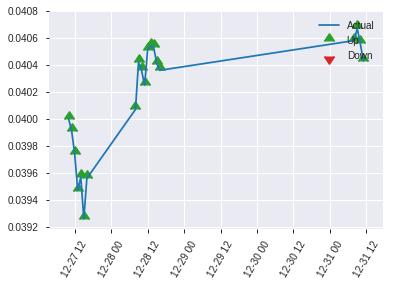


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4546781590609169
RMSE: 0.6742982715838125
LogLoss: 1.6878896117422841
Mean Per-Class Error: 0.4228155339805826
AUC: 0.5775080906148867
pr_auc: 0.5483200073701109
Gini: 0.15501618122977345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8243314937201842: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   93   0.775    (93.0/120.0)
1      10   93   0.0971   (10.0/103.0)
Total  37   186  0.4619   (103.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.824331     0.643599  185
max f2                       0.275045     0.811024  222
max f0point5                 0.867926     0.556258  171
max accuracy                 0.992327     0.573991  17
max precision                0.997496     1         0
max recall                   0.275045     1         222
max specificity              0.997496     1         0
max absolute_mcc             0.867926     0.18324   171
max min_per_class_accuracy   0.969566     0.533981  106
max mean_per_class_accuracy  0.867926     0.577184  171

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 90.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.996019           2.16505   2.16505            1                0.996846  1                           0.996846            0.0291262       0.0291262                  116.505   116.505
    2        0.0224215                   0.995166           2.16505   2.16505            1                0.99533   1                           0.996239            0.0194175       0.0485437                  116.505   116.505
    3        0.0313901                   0.994338           1.08252   1.85576            0.5              0.994901  0.857143                    0.995857            0.00970874      0.0582524                  8.25243   85.5756
    4        0.0403587                   0.993775           1.08252   1.68393            0.5              0.994026  0.777778                    0.99545             0.00970874      0.0679612                  8.25243   68.3927
    5        0.0538117                   0.993632           1.44337   1.62379            0.666667         0.993686  0.75                        0.995009            0.0194175       0.0873786                  44.3366   62.3786
    6        0.103139                    0.992071           1.18094   1.41199            0.545455         0.992561  0.652174                    0.993838            0.0582524       0.145631                   18.0936   41.1988
    7        0.152466                    0.990259           0.590468  1.1462             0.272727         0.991178  0.529412                    0.992977            0.0291262       0.174757                   -40.9532  14.6202
    8        0.201794                    0.988009           1.37776   1.2028             0.636364         0.989001  0.555556                    0.992005            0.0679612       0.242718                   37.7758   20.2805
    9        0.300448                    0.984655           1.08252   1.16331            0.5              0.986328  0.537313                    0.990141            0.106796        0.349515                   8.25243   16.331
    10       0.399103                    0.978272           1.08252   1.14334            0.5              0.981326  0.52809                     0.987962            0.106796        0.456311                   8.25243   14.334
    11       0.502242                    0.966143           0.847193  1.08252            0.391304         0.97192   0.5                         0.984668            0.0873786       0.543689                   -15.2807  8.25243
    12       0.600897                    0.949099           1.08252   1.08252            0.5              0.95652   0.5                         0.980047            0.106796        0.650485                   8.25243   8.25243
    13       0.699552                    0.895946           1.18094   1.0964             0.545455         0.921006  0.50641                     0.97172             0.116505        0.76699                    18.0936   9.64028
    14       0.798206                    0.851296           0.885702  1.07036            0.409091         0.877687  0.494382                    0.960098            0.0873786       0.854369                   -11.4298  7.03611
    15       0.896861                    0.757865           0.688879  1.0284             0.318182         0.808297  0.475                       0.9434              0.0679612       0.92233                    -31.1121  2.83981
    16       1                           0.275045           0.75306   1                  0.347826         0.606058  0.461883                    0.908607           

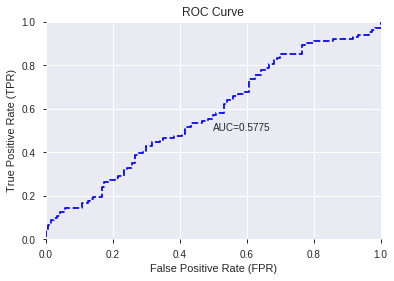

This function is available for GLM models only


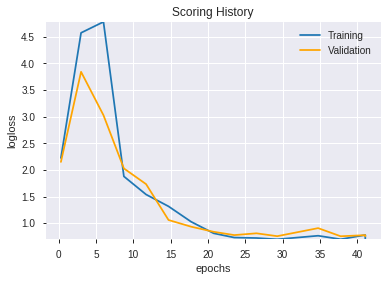

--2019-09-03 03:07:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  64.8MB/s    in 5.6s    

2019-09-03 03:07:34 (62.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024253_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024253_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_030744_model_3  0.615453  0.833945              0.491667  0.530474  0.281402
1  DeepLearning_grid_1_AutoML_20190903_030744_model_4  0.613592  0.991273              0.423503  0.581646  0.338313
2  DeepLearning_grid_1_AutoML_20190903_030744_model_1  0.599272  1.010445              0.475688  0.562827  0.316775
3  DeepLearning_grid_1_AutoML_20190903_030744_model_5  0.598139  0.678467              0.447856  0.492607  0.242662
4  DeepLearning_grid_1_AutoML_20190903_030744_model_7  0.597977  0.682602              0.500000  0.494041  0.244077
5  DeepLearning_grid_1_AutoML_20190903_030744_model_2  0.597735  0.795661              0.411691  0.518522  0.268865
6  DeepLearning_grid_1_AutoML_20190903_030744_model_9  0.595388  0.686494              0.449960  0.496640  0.246651
7  DeepLearning_grid_1_AutoML_20190903_030744_model_6  0.577023  0.693435              0.466626  0.500056  0.250056
8  DeepLearning_grid_1_AutoML_20190903_030744_model_8  0.569498  0.698895              0.462460  0.502709  0.252717
9               DeepLearning_1_AutoML_20190903_030744  0.543689  0.806734              0.447168  0.542573  0.294385

variable  relative_importance  scaled_importance  percentage
0       CDLHOMINGPIGEON             1.000000           1.000000    0.035336
1     CDLDARKCLOUDCOVER             0.894301           0.894301    0.031601
2          CDLTASUKIGAP             0.892466           0.892466    0.031536
3             CDLONNECK             0.887385           0.887385    0.031357
4    CDLEVENINGDOJISTAR             0.880601           0.880601    0.031117
5     CDL3WHITESOLDIERS             0.880516           0.880516    0.031114
6           CDLPIERCING             0.878451           0.878451    0.031041
7     CDLSTALLEDPATTERN             0.871059           0.871059    0.030780
8             CDLINNECK             0.857839           0.857839    0.030313
9        CDLMORNINGSTAR             0.831302           0.831302    0.029375
10      CDLLADDERBOTTOM             0.820174           0.820174    0.028982
11       CDLEVENINGSTAR             0.817121           0.817121    0.028874
12   CDLMORNINGDOJISTAR             0.802368           0.802368    0.028353
13    CDLINVERTEDHAMMER             0.770033           0.770033    0.027210
14  CDLXSIDEGAP3METHODS             0.663282           0.663282    0.023438
15      CDLADVANCEBLOCK             0.653215           0.653215    0.023082
16      CDLSHOOTINGSTAR             0.639946           0.639946    0.022613
17   CDLSEPARATINGLINES             0.639464           0.639464    0.022596
18       CDL3LINESTRIKE             0.630691           0.630691    0.022286
19         HT_TRENDMODE             0.620274           0.620274    0.021918
20               SAREXT             0.569786           0.569786    0.020134
21    CDLGRAVESTONEDOJI             0.540679           0.540679    0.019106
22       is_month_start             0.530825           0.530825    0.018757
23       CDLMATCHINGLOW             0.522978           0.522978    0.018480
24        days_in_month             0.489832           0.489832    0.017309
25        CDLHANGINGMAN             0.464059           0.464059    0.016398
26         weekday_name             0.458849           0.458849    0.016214
27                  BOP             0.439929           0.439929    0.015545
28     CDLDRAGONFLYDOJI             0.439217           0.439217    0.015520
29           aroonup_30             0.419859           0.419859    0.014836
30       STOCHRSI_fastk             0.418568           0.418568    0.014791
31                   AD             0.417988           0.417988    0.014770
32                 hour             0.414218           0.414218    0.014637
33           aroonup_14             0.409530           0.409530    0.014471
34            CDLTAKURI             0.408230           0.408230    0.014425
35                  day             0.407470           0.407470    0.014398
36               Volume             0.395385           0.395385    0.013971
37         is_month_end             0.388683           0.388683    0.013735
38                 DX_8             0.387512           0.387512    0.013693
39                MFI_8             0.384758           0.384758    0.013596
40         STOCHF_fastd             0.383962           0.383962    0.013568
41                VAR_8             0.379090           0.379090    0.013396
42         aroondown_14             0.373002           0.373002    0.013180
43            dayofyear             0.369858           0.369858    0.013069
44                 week             0.357319           0.357319    0.012626
45         aroondown_12             0.357295           0.357295    0.012625
46            CDLHAMMER             0.355376           0.355376    0.012558
47              CDLDOJI             0.300954           0.300954    0.010635
48       CDLRICKSHAWMAN             0.299528           0.299528    0.010584
49    CDLLONGLEGGEDDOJI             0.284379           0.284379    0.010049

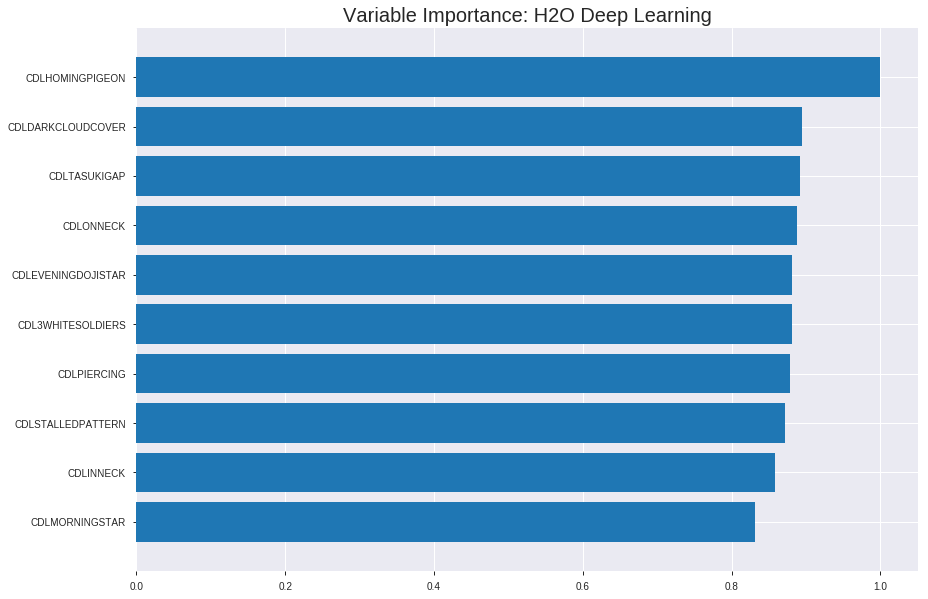

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_030744_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24845752984237973
RMSE: 0.4984551432600327
LogLoss: 0.7684108939561723
Mean Per-Class Error: 0.39613567871417277
AUC: 0.6285925906440152
pr_auc: 0.6277164295017202
Gini: 0.25718518128803036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00541888986916036: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   743   0.9687   (743.0/767.0)
1      10   783   0.0126   (10.0/793.0)
Total  34   1526  0.4827   (753.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00541889   0.675291  396
max f2                       1.56318e-05  0.837912  399
max f0point5                 0.491581     0.610161  193
max accuracy                 0.491581     0.603846  193
max precision                0.87765      0.875     15
max recall                   1.56318e-05  1         399
max specificity              0.999929     0.998696  0
max absolute_mcc             0.491581     0.2077    193
max min_per_class_accuracy   0.491581     0.602774  193
max mean_per_class_accuracy  0.491581     0.603864  193

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 48.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.913005           1.59836   1.59836            0.8125           0.980287   0.8125                      0.980287            0.0163934       0.0163934                  59.8361   59.8361
    2        0.0205128                   0.876133           1.84426   1.72131            0.9375           0.891863   0.875                       0.936075            0.0189155       0.035309                   84.4262   72.1311
    3        0.0301282                   0.841849           1.31148   1.59051            0.666667         0.859058   0.808511                    0.911495            0.0126103       0.0479193                  31.1475   59.0513
    4        0.0403846                   0.820354           1.22951   1.49883            0.625            0.830604   0.761905                    0.890951            0.0126103       0.0605296                  22.9508   49.8829
    5        0.05                        0.802082           1.44262   1.48802            0.733333         0.810501   0.75641                     0.87548             0.0138714       0.074401                   44.2623   48.802
    6        0.1                         0.743936           1.31148   1.39975            0.666667         0.769131   0.711538                    0.822306            0.0655738       0.139975                   31.1475   39.9748
    7        0.15                        0.695264           1.26103   1.35351            0.641026         0.720417   0.688034                    0.788343            0.0630517       0.203026                   26.1034   35.351
    8        0.2                         0.662177           1.18537   1.31148            0.602564         0.679735   0.666667                    0.761191            0.0592686       0.262295                   18.5372   31.1475
    9        0.3                         0.595833           1.17276   1.26524            0.596154         0.628473   0.643162                    0.716951            0.117276        0.379571                   17.2762   26.5237
    10       0.4                         0.542379           1.0971    1.2232             0.557692         0.568081   0.621795                    0.679734            0.10971         0.489281                   9.70996   22.3203
    11       0.5                         0.490922           1.12232   1.20303            0.570513         0.517739   0.611538                    0.647335            0.112232        0.601513                   12.232    20.3026
    12       0.6                         0.441308           0.870113  1.14754            0.442308         0.465498   0.583333                    0.617029            0.0870113       0.688525                   -12.9887  14.7541
    13       0.7                         0.389464           0.844893  1.10431            0.429487         0.415927   0.561355                    0.5883              0.0844893       0.773014                   -15.5107  10.4306
    14       0.8                         0.312262           0.832282  1.0703             0.423077         0.353557   0.544071                    0.558957            0.0832282       0.856242                   -16.7718  7.03026
    15       0.9                         0.208021           0.74401   1.03405            0.378205         0.266767   0.525641                    0.526491            0.074401        0.930643                   -25.599   3.40479
    16       1                           1.53807e-13        0.693569  1                  0.352564         0.0904518  0.508333                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2932319881141184
RMSE: 0.5415089917204685
LogLoss: 0.8861838101754608
Mean Per-Class Error: 0.4650961441659116
AUC: 0.52305446491493
pr_auc: 0.524478172735103
Gini: 0.046108929829860035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.02969751324962e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    215  0        (0.0/215.0)
Total  0    446  0.5179   (231.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.0297e-05   0.65053   399
max f2                       2.0297e-05   0.823124  399
max f0point5                 0.260877     0.541903  312
max accuracy                 0.708466     0.547085  67
max precision                1            1         0
max recall                   2.0297e-05   1         399
max specificity              1            1         0
max absolute_mcc             0.882538     0.140086  7
max min_per_class_accuracy   0.472187     0.502326  201
max mean_per_class_accuracy  0.708466     0.534904  67

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.949311           2.07442   2.07442            1                0.987638   1                           0.987638            0.0232558       0.0232558                  107.442   107.442
    2        0.0201794                   0.879436           1.55581   1.84393            0.75             0.895365   0.888889                    0.946628            0.0139535       0.0372093                  55.5814   84.3928
    3        0.0313901                   0.853762           0.829767  1.48173            0.4              0.869854   0.714286                    0.919209            0.00930233      0.0465116                  -17.0233  48.1728
    4        0.0403587                   0.837265           1.55581   1.49819            0.75             0.84461    0.722222                    0.902631            0.0139535       0.0604651                  55.5814   49.8191
    5        0.0515695                   0.815543           0.414884  1.26269            0.2              0.826474   0.608696                    0.886075            0.00465116      0.0651163                  -58.5116  26.269
    6        0.100897                    0.758629           1.1315    1.19855            0.545455         0.781677   0.577778                    0.835036            0.055814        0.12093                    13.1501   19.8553
    7        0.150224                    0.713128           1.1315    1.17654            0.545455         0.735903   0.567164                    0.802485            0.055814        0.176744                   13.1501   17.6536
    8        0.201794                    0.677781           1.08231   1.15245            0.521739         0.694902   0.555556                    0.774992            0.055814        0.232558                   8.23054   15.2455
    9        0.300448                    0.598225           0.707188  1.00625            0.340909         0.64502    0.485075                    0.732314            0.0697674       0.302326                   -29.2812  0.624783
    10       0.401345                    0.530562           0.968062  0.996648           0.466667         0.561302   0.480447                    0.689322            0.0976744       0.4                        -3.1938   -0.335196
    11       0.5                         0.469318           1.03721   1.00465            0.5              0.50099    0.484305                    0.652163            0.102326        0.502326                   3.72093   0.465116
    12       0.600897                    0.389058           1.10636   1.02173            0.533333         0.433412   0.492537                    0.615432            0.111628        0.613953                   10.6357   2.17286
    13       0.699552                    0.307186           0.942918  1.01061            0.454545         0.345801   0.487179                    0.577407            0.0930233       0.706977                   -5.70825  1.06142
    14       0.800448                    0.23938            1.15245   1.02849            0.555556         0.274315   0.495798                    0.539202            0.116279        0.823256                   15.2455   2.84933
    15       0.899103                    0.133993           0.80148   1.00358            0.386364         0.187303   0.483791                    0.50059             0.0790698       0.902326                   -19.852   0.358406
    16       1                           3.05693e-09        0.968062  1                  0.466667         0.0646112  0.482063               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:09:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:09:07  1 min 21.930 sec  5532 obs/sec      6.69551   1             10445      0.544968         0.967108            -0.188292      0.552124        0.544731           1.35246          0.491667                         0.563906           0.994715              -0.273598        0.470553          0.453819             0.829767           0.517937
    2019-09-03 03:09:13  1 min 27.996 sec  6651 obs/sec      33.5038   5             52266      0.498455         0.768411            0.00589374     0.628593        0.627716           1.59836          0.482692                         0.541509           0.886184              -0.174439        0.523054          0.524478             2.07442            0.517937
    2019-09-03 03:09:19  1 min 33.930 sec  7619 obs/sec      66.9622   10            104461     0.481497         0.728449            0.0723858      0.686387        0.690907           1.59836          0.399359                         0.545559           0.918727              -0.192071        0.524393          0.517735             1.65953            0.517937
    2019-09-03 03:09:24  1 min 39.227 sec  8281 obs/sec      100.511   15            156797     0.474296         0.695881            0.0999238      0.707602        0.709056           1.84426          0.362821                         0.542844           0.912187              -0.180236        0.516329          0.500411             1.65953            0.517937
    2019-09-03 03:09:30  1 min 45.084 sec  8879 obs/sec      140.694   21            219482     0.472177         0.756094            0.107946       0.724846        0.739586           1.96721          0.348718                         0.561213           1.11604               -0.261463        0.504148          0.483471             0.829767           0.517937
    2019-09-03 03:09:36  1 min 50.682 sec  9329 obs/sec      180.896   27            282198     0.462559         0.733581            0.143918       0.749149        0.75782            1.72131          0.325641                         0.556697           1.12285               -0.241242        0.51187           0.481417             0.829767           0.517937
    2019-09-03 03:09:41  1 min 56.072 sec  9699 obs/sec      221.145   33            344986     0.465536         0.789376            0.132863       0.748007        0.764589           1.96721          0.326282                         0.569413           1.23836               -0.298596        0.502275          0.475675             0.414884           0.517937
    2019-09-03 03:09:41  1 min 56.153 sec  9696 obs/sec      221.145   33            344986     0.498455         0.768411            0.00589374     0.628593        0.627716           1.59836          0.482692                         0.541509           0.886184              -0.174439        0.523054          0.524478             2.07442            0.517937

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLHOMINGPIGEON     1.0                    1.0                  0.03533617862960871
CDLDARKCLOUDCOVER   0.8943008184432983     0.8943008184432983   0.03160117346911766
CDLTASUKIGAP        0.8924660086631775     0.8924660086631775   0.031536338302975954
CDLONNECK           0.8873848915100098     0.8873848915100098   0.03135679103961365
CDLEVENINGDOJISTAR  0.8806014657020569     0.8806014657020569   0.03111709069354313
---                 ---                    ---                  ---
aroondown_12        0.3572950065135956     0.3572950065135956   0.012625440173631621
CDLHAMMER           0.3553759753704071     0.3553759753704071   0.01255762894636013
CDLDOJI             0.3009539842605591     0.3009539842605591   0.010634563747123564
CDLRICKSHAWMAN      0.2995283007621765     0.2995283007621765   0.010584185540355432
CDLLONGLEGGEDDOJI   0.2843789756298065     0.2843789756298065   0.010048866281359984


See the whole table with table.as_data_frame()


('accuracy', 0.6233183856502242)

('F1', 0.6358024691358024)

('auc', 0.6154530744336569)

('logloss', 0.8339446019991774)

('mean_per_class_error', 0.3802588996763754)

('rmse', 0.5304736081945693)

('mse', 0.28140224899096544)

deeplearning prediction progress: |███████████████████████████████████████| 100%


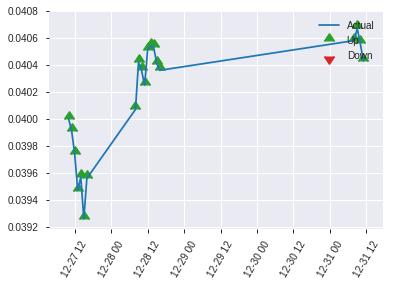


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28140224899096544
RMSE: 0.5304736081945693
LogLoss: 0.8339446019991774
Mean Per-Class Error: 0.3802588996763754
AUC: 0.6154530744336569
pr_auc: 0.5745400510084252
Gini: 0.23090614886731387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0009239467349849504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    103  0        (0.0/103.0)
Total  2    221  0.5291   (118.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000923947  0.635802  220
max f2                       0.000923947  0.813586  220
max f0point5                 0.664868     0.591182  98
max accuracy                 0.704337     0.623318  84
max precision                0.993512     1         0
max recall                   0.000923947  1         220
max specificity              0.993512     1         0
max absolute_mcc             0.664868     0.2403    98
max min_per_class_accuracy   0.647773     0.592233  106
max mean_per_class_accuracy  0.664868     0.619741  98

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 59.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.934555           1.44337   1.44337            0.666667         0.973142  0.666667                    0.973142            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.917862           2.16505   1.73204            1                0.924003  0.8                         0.953486            0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.901566           1.08252   1.54646            0.5              0.910875  0.714286                    0.941312            0.00970874      0.0485437                  8.25243   54.6463
    4        0.0403587                   0.897896           1.08252   1.44337            0.5              0.899756  0.666667                    0.932077            0.00970874      0.0582524                  8.25243   44.3366
    5        0.0538117                   0.8964             2.16505   1.62379            1                0.897233  0.75                        0.923366            0.0291262       0.0873786                  116.505   62.3786
    6        0.103139                    0.84955            1.57458   1.60025            0.727273         0.872273  0.73913                     0.89893             0.0776699       0.165049                   57.4581   60.0253
    7        0.152466                    0.833323           1.18094   1.46459            0.545455         0.839067  0.676471                    0.879563            0.0582524       0.223301                   18.0936   46.4592
    8        0.201794                    0.794061           0.78729   1.29903            0.363636         0.812642  0.6                         0.863205            0.038835        0.262136                   -21.271   29.9029
    9        0.300448                    0.73714            0.984113  1.19562            0.454545         0.766637  0.552239                    0.831496            0.0970874       0.359223                   -1.5887   19.5624
    10       0.399103                    0.689529           1.67299   1.31362            0.772727         0.716489  0.606742                    0.803067            0.165049        0.524272                   67.2992   31.3625
    11       0.502242                    0.634957           0.847193  1.21784            0.391304         0.662875  0.5625                      0.774278            0.0873786       0.61165                    -15.2807  21.784
    12       0.600897                    0.561942           0.78729   1.14715            0.363636         0.597249  0.529851                    0.745213            0.0776699       0.68932                    -21.271   14.7153
    13       0.699552                    0.494269           0.78729   1.0964             0.363636         0.533234  0.50641                     0.715319            0.0776699       0.76699                    -21.271   9.64028
    14       0.798206                    0.425124           0.78729   1.0582             0.363636         0.461459  0.488764                    0.683943            0.0776699       0.84466                    -21.271   5.81979
    15       0.896861                    0.248136           0.688879  1.01757            0.318182         0.349695  0.47                        0.647176            0.0679612       0.912621                   -31.1121  1.75728
    16       1                           0.000224728        0.847193  1                  0.391304         0.112396  0.461883                    0.592019          

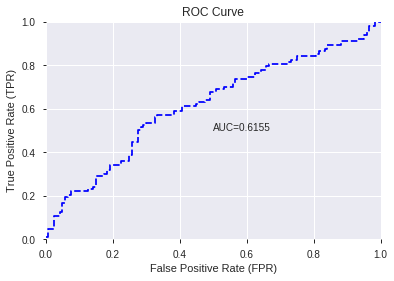

This function is available for GLM models only


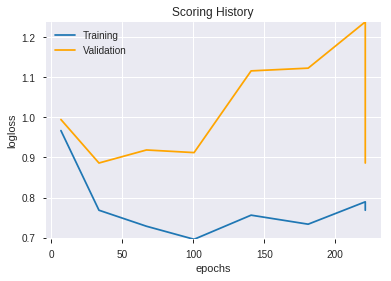

--2019-09-03 03:15:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_030744_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_030744_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLXSIDEGAP3METHODS',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'HT_TRENDMODE',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'is_month_start',
 'CDLMATCHINGLOW',
 'days_in_month',
 'CDLHANGINGMAN',
 'weekday_name',
 'BOP',
 'CDLDRAGONFLYDOJI',
 'aroonup_30',
 'STOCHRSI_fastk',
 'AD',
 'hour',
 'aroonup_14',
 'CDLTAKURI',
 'day',
 'Volume',
 'is_month_end',
 'DX_8',
 'MFI_8',
 'STOCHF_fastd',
 'VAR_8',
 'aroondown_14',
 'dayofyear',
 'week',
 'aroondown_12',
 'CDLHAMMER',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031506_model_1  0.579207  0.691896              0.461084  0.499394  0.249395

variable  relative_importance  scaled_importance  percentage
0                  DX_8             0.052967           1.000000    0.050705
1                    AD             0.052162           0.984790    0.049934
2        is_month_start             0.050795           0.958988    0.048626
3       CDLHOMINGPIGEON             0.040328           0.761367    0.038605
4                 VAR_8             0.040226           0.759448    0.038508
5          aroondown_14             0.036044           0.680493    0.034505
6                   day             0.034612           0.653450    0.033133
7     CDLDARKCLOUDCOVER             0.033992           0.641752    0.032540
8         CDLHANGINGMAN             0.032357           0.610880    0.030975
9          is_month_end             0.030720           0.579987    0.029408
10                 hour             0.030179           0.569762    0.028890
11            CDLONNECK             0.028899           0.545591    0.027664
12         aroondown_12             0.027908           0.526892    0.026716
13           aroonup_30             0.026875           0.507391    0.025727
14       CDLRICKSHAWMAN             0.025913           0.489228    0.024806
15    CDLSTALLEDPATTERN             0.025873           0.488467    0.024768
16              CDLDOJI             0.025543           0.482238    0.024452
17    CDLLONGLEGGEDDOJI             0.025538           0.482154    0.024448
18      CDLLADDERBOTTOM             0.025274           0.477165    0.024195
19         STOCHF_fastd             0.023781           0.448966    0.022765
20   CDLMORNINGDOJISTAR             0.023341           0.440676    0.022345
21       STOCHRSI_fastk             0.023299           0.439874    0.022304
22               SAREXT             0.022516           0.425090    0.021554
23          CDLPIERCING             0.022096           0.417155    0.021152
24  CDLXSIDEGAP3METHODS             0.020764           0.392018    0.019877
25       CDLEVENINGSTAR             0.020662           0.390083    0.019779
26        days_in_month             0.019041           0.359489    0.018228
27           aroonup_14             0.018576           0.350707    0.017783
28            CDLINNECK             0.016972           0.320433    0.016248
29      CDLSHOOTINGSTAR             0.016677           0.314863    0.015965
30       CDL3LINESTRIKE             0.015448           0.291652    0.014788
31    CDL3WHITESOLDIERS             0.015125           0.285550    0.014479
32     CDLDRAGONFLYDOJI             0.014686           0.277259    0.014058
33            CDLTAKURI             0.014663           0.276823    0.014036
34   CDLSEPARATINGLINES             0.014034           0.264955    0.013435
35            CDLHAMMER             0.013803           0.260586    0.013213
36                 week             0.010955           0.206819    0.010487
37    CDLGRAVESTONEDOJI             0.010607           0.200247    0.010154
38            dayofyear             0.010435           0.197012    0.009990
39       CDLMORNINGSTAR             0.010345           0.195305    0.009903
40                MFI_8             0.007675           0.144906    0.007347
41               Volume             0.006449           0.121752    0.006173
42      CDLADVANCEBLOCK             0.005516           0.104138    0.005280
43   CDLEVENINGDOJISTAR             0.004611           0.087054    0.004414
44         weekday_name             0.003886           0.073360    0.003720
45       CDLMATCHINGLOW             0.003773           0.071225    0.003611
46         CDLTASUKIGAP             0.002736           0.051647    0.002619
47         HT_TRENDMODE             0.002345           0.044268    0.002245
48                  BOP             0.002202           0.041579    0.002108
49    CDLINVERTEDHAMMER             0.001393           0.026305    0.001334

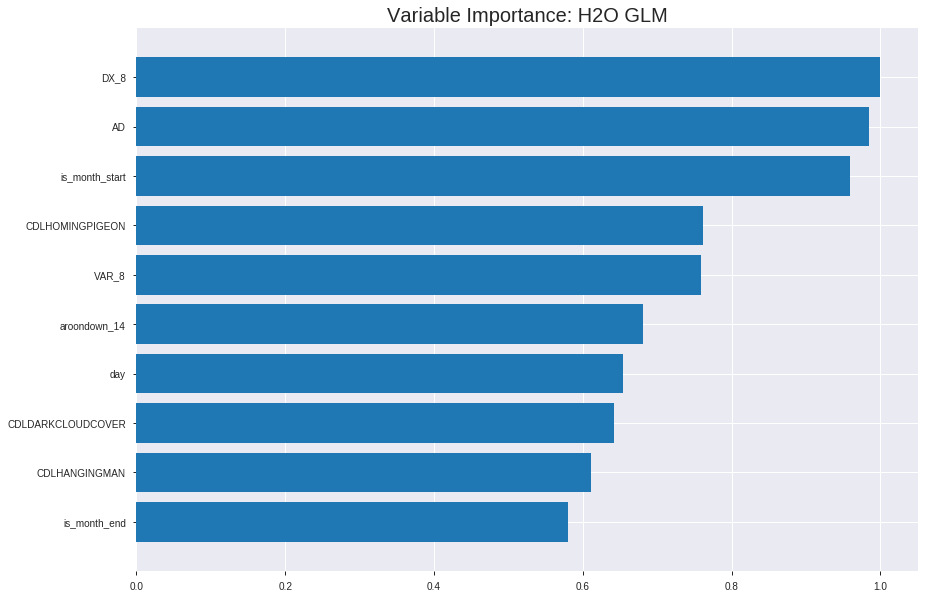

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031506_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24409647819953897
RMSE: 0.49406120896052846
LogLoss: 0.6810874121530605
Null degrees of freedom: 1559
Residual degrees of freedom: 1509
Null deviance: 2162.1858499497453
Residual deviance: 2124.992725917549
AIC: 2226.992725917549
AUC: 0.5959931341875044
pr_auc: 0.596447865552998
Gini: 0.19198626837500887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3971467655868542: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   748   0.9752   (748.0/767.0)
1      3    790   0.0038   (3.0/793.0)
Total  22   1538  0.4814   (751.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397147     0.677821  380
max f2                       0.384357     0.839517  385
max f0point5                 0.492511     0.590816  243
max accuracy                 0.497839     0.572436  228
max precision                0.762906     1         0
max recall                   0.354751     1         392
max specificity              0.762906     1         0
max absolute_mcc             0.485188     0.153632  261
max min_per_class_accuracy   0.512024     0.554107  183
max mean_per_class_accuracy  0.503761     0.57018   210

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.603005           1.72131   1.72131            0.875            0.642499  0.875                       0.642499            0.0176545       0.0176545                  72.1311   72.1311
    2        0.0205128                   0.577751           1.22951   1.47541            0.625            0.58555   0.75                        0.614025            0.0126103       0.0302648                  22.9508   47.541
    3        0.0301282                   0.569437           1.44262   1.46495            0.733333         0.573489  0.744681                    0.601088            0.0138714       0.0441362                  44.2623   46.4946
    4        0.0403846                   0.565315           1.10656   1.37393            0.5625           0.567665  0.698413                    0.592599            0.0113493       0.0554855                  10.6557   37.3927
    5        0.05                        0.562386           1.44262   1.38714            0.733333         0.563873  0.705128                    0.587075            0.0138714       0.0693569                  44.2623   38.7137
    6        0.1                         0.552877           1.18537   1.28625            0.602564         0.556854  0.653846                    0.571964            0.0592686       0.128625                   18.5372   28.6255
    7        0.15                        0.544988           1.16015   1.24422            0.589744         0.548753  0.632479                    0.564227            0.0580076       0.186633                   16.0151   24.422
    8        0.2                         0.539614           1.23581   1.24212            0.628205         0.542262  0.63141                     0.558736            0.0617907       0.248424                   23.5813   24.2119
    9        0.3                         0.528388           1.10971   1.19798            0.564103         0.533845  0.608974                    0.550439            0.110971        0.359395                   10.971    19.7982
    10       0.4                         0.519896           0.958386  1.13808            0.487179         0.523968  0.578526                    0.543821            0.0958386       0.455233                   -4.16141  13.8083
    11       0.5                         0.51201            0.996217  1.10971            0.50641          0.515785  0.564103                    0.538214            0.0996217       0.554855                   -0.37831  10.971
    12       0.6                         0.503374           1.13493   1.11391            0.576923         0.507817  0.566239                    0.533148            0.113493        0.668348                   13.4931   11.3913
    13       0.7                         0.495776           0.983607  1.0953             0.5              0.499639  0.556777                    0.528361            0.0983607       0.766709                   -1.63934  9.52981
    14       0.8                         0.482407           0.870113  1.06715            0.442308         0.489624  0.542468                    0.523519            0.0870113       0.85372                    -12.9887  6.71501
    15       0.9                         0.457004           0.75662   1.03265            0.384615         0.470896  0.524929                    0.517672            0.075662        0.929382                   -24.338   3.26468
    16       1                           0.182132           0.706179  1                  0.358974         0.424288  0.508333                    0.508333            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2469571902835421
RMSE: 0.49694787481539965
LogLoss: 0.686851609102308
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.9445738826204
Residual deviance: 612.6716353192587
AIC: 714.6716353192587
AUC: 0.5402295379039564
pr_auc: 0.5140252515521841
Gini: 0.0804590758079129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4357205787516257: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   208  0.9004   (208.0/231.0)
1      8    207  0.0372   (8.0/215.0)
Total  31   415  0.4843   (216.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435721     0.657143  368
max f2                       0.354868     0.824387  397
max f0point5                 0.435721     0.552     368
max accuracy                 0.506127     0.55157   190
max precision                0.730128     1         0
max recall                   0.354868     1         397
max specificity              0.730128     1         0
max absolute_mcc             0.435721     0.122521  368
max min_per_class_accuracy   0.505199     0.541126  195
max mean_per_class_accuracy  0.506127     0.551153  190

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.610288           2.07442   2.07442            1                0.671683  1                           0.671683            0.0232558       0.0232558                  107.442   107.442
    2        0.0201794                   0.561513           0.518605  1.38295            0.25             0.568454  0.666667                    0.625804            0.00465116      0.027907                   -48.1395  38.2946
    3        0.0313901                   0.557288           0.829767  1.18538            0.4              0.558682  0.571429                    0.601832            0.00930233      0.0372093                  -17.0233  18.5382
    4        0.0403587                   0.551806           0.518605  1.03721            0.25             0.553829  0.5                         0.591164            0.00465116      0.0418605                  -48.1395  3.72093
    5        0.0515695                   0.550373           0.829767  0.992113           0.4              0.551049  0.478261                    0.582444            0.00930233      0.0511628                  -17.0233  -0.788675
    6        0.100897                    0.540238           1.03721   1.01416            0.5              0.544055  0.488889                    0.563676            0.0511628       0.102326                   3.72093   1.41602
    7        0.150224                    0.535354           1.03721   1.02173            0.5              0.537776  0.492537                    0.555172            0.0511628       0.153488                   3.72093   2.17286
    8        0.201794                    0.530051           1.35288   1.10636            0.652174         0.532409  0.533333                    0.549354            0.0697674       0.223256                   35.2882   10.6357
    9        0.300448                    0.521093           0.895772  1.03721            0.431818         0.524851  0.5                         0.541309            0.0883721       0.311628                   -10.4228  3.72093
    10       0.401345                    0.512967           1.10636   1.05459            0.533333         0.516788  0.50838                     0.535144            0.111628        0.423256                   10.6357   5.45927
    11       0.5                         0.505041           1.22579   1.08837            0.590909         0.50927   0.524664                    0.530039            0.12093         0.544186                   22.5793   8.83721
    12       0.600897                    0.493834           0.783669  1.03721            0.377778         0.499217  0.5                         0.524864            0.0790698       0.623256                   -21.6331  3.72093
    13       0.699552                    0.483033           1.03721   1.03721            0.5              0.48887   0.5                         0.519788            0.102326        0.725581                   3.72093   3.72093
    14       0.800448                    0.473053           0.968062  1.02849            0.466667         0.47913   0.495798                    0.514663            0.0976744       0.823256                   -3.1938   2.84933
    15       0.899103                    0.449387           1.03721   1.02945            0.5              0.463399  0.496259                    0.509038            0.102326        0.925581                   3.72093   2.94496
    16       1                           0.281451           0.737571  1                  0.355556         0.414287  0.482063                    0.499478       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:15:06  0.000 sec   2            2.9       51            1.38062           1.38299
    2019-09-03 03:15:07  0.036 sec   4            1.8       51            1.37819           1.38107
    2019-09-03 03:15:07  0.063 sec   6            1.1       51            1.37506           1.37884
    2019-09-03 03:15:07  0.090 sec   8            0.7       51            1.37125           1.37658
    2019-09-03 03:15:07  0.118 sec   10           0.44      51            1.36688           1.37471
    2019-09-03 03:15:07  0.145 sec   12           0.27      51            1.36217           1.3737
    2019-09-03 03:15:07  0.173 sec   14           0.17      51            1.35747           1.37405
    2019-09-03 03:15:07  0.200 sec   16           0.1       51            1.35313           1.37609
    2019-09-03 03:15:07  0.223 sec   18           0.065     51            1.34945           1.37989
    2019-09-03 03:15:07  0.242 sec   20           0.04      51            1.3466            1.38517
    2019-09-03 03:15:07  0.259 sec   22           0.025     51            1.34459           1.39135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6428571428571429)

('auc', 0.5792071197411004)

('logloss', 0.6918955386825394)

('mean_per_class_error', 0.42055016181229776)

('rmse', 0.49939425178289226)

('mse', 0.24939461871379479)

glm prediction progress: |████████████████████████████████████████████████| 100%


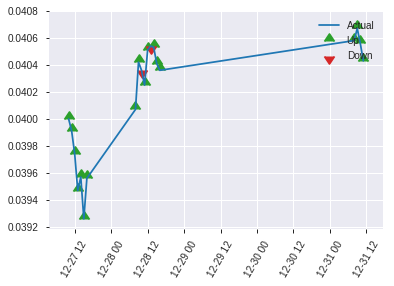


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24939461871379479
RMSE: 0.49939425178289226
LogLoss: 0.6918955386825394
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.7723147237181
Residual deviance: 308.58541025241254
AIC: 410.58541025241254
AUC: 0.5792071197411004
pr_auc: 0.5049619906606597
Gini: 0.1584142394822008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4799278096977408: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   106  0.8833   (106.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  18   205  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479928     0.642857  204
max f2                       0.375924     0.813586  220
max f0point5                 0.541323     0.54955   112
max accuracy                 0.541917     0.578475  110
max precision                0.615581     1         0
max recall                   0.375924     1         220
max specificity              0.615581     1         0
max absolute_mcc             0.50184      0.161089  176
max min_per_class_accuracy   0.541917     0.575     110
max mean_per_class_accuracy  0.541323     0.57945   112

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 53.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.599704           1.44337   1.44337            0.666667         0.609749  0.666667                    0.609749            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.594724           0         0.866019           0                0.595122  0.4                         0.603899            0               0.0194175                  -100      -13.3981
    3        0.0313901                   0.594266           2.16505   1.23717            1                0.594447  0.571429                    0.601198            0.0194175       0.038835                   116.505   23.7171
    4        0.0403587                   0.59104            1.08252   1.2028             0.5              0.593738  0.555556                    0.59954             0.00970874      0.0485437                  8.25243   20.2805
    5        0.0538117                   0.586899           0         0.902104           0                0.588711  0.416667                    0.596833            0               0.0485437                  -100      -9.78964
    6        0.103139                    0.58029            1.18094   1.03546            0.545455         0.583261  0.478261                    0.590342            0.0582524       0.106796                   18.0936   3.5458
    7        0.152466                    0.56816            0.984113  1.01885            0.454545         0.57425   0.470588                    0.585136            0.0485437       0.15534                    -1.5887   1.88464
    8        0.201794                    0.564347           1.57458   1.15469            0.727273         0.565876  0.533333                    0.580428            0.0776699       0.23301                    57.4581   15.4693
    9        0.300448                    0.555705           1.18094   1.16331            0.545455         0.560652  0.537313                    0.573934            0.116505        0.349515                   18.0936   16.331
    10       0.399103                    0.549237           1.18094   1.16767            0.545455         0.552421  0.539326                    0.568616            0.116505        0.466019                   18.0936   16.7667
    11       0.502242                    0.541421           1.12959   1.15985            0.521739         0.545555  0.535714                    0.563881            0.116505        0.582524                   12.9591   15.9847
    12       0.600897                    0.532024           0.885702  1.11484            0.409091         0.537167  0.514925                    0.559495            0.0873786       0.669903                   -11.4298  11.4838
    13       0.699552                    0.519186           0.984113  1.0964             0.454545         0.526692  0.50641                     0.554869            0.0970874       0.76699                    -1.5887   9.64028
    14       0.798206                    0.501304           0.984113  1.08252            0.454545         0.512249  0.5                         0.549601            0.0970874       0.864078                   -1.5887   8.25243
    15       0.896861                    0.482393           0.688879  1.03922            0.318182         0.490876  0.48                        0.543141            0.0679612       0.932039                   -31.1121  3.92233
    16       1                           0.323713           0.658928  1                  0.304348         0.442381  0.461883                    0.532749         

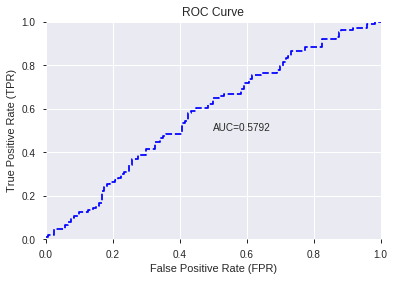

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


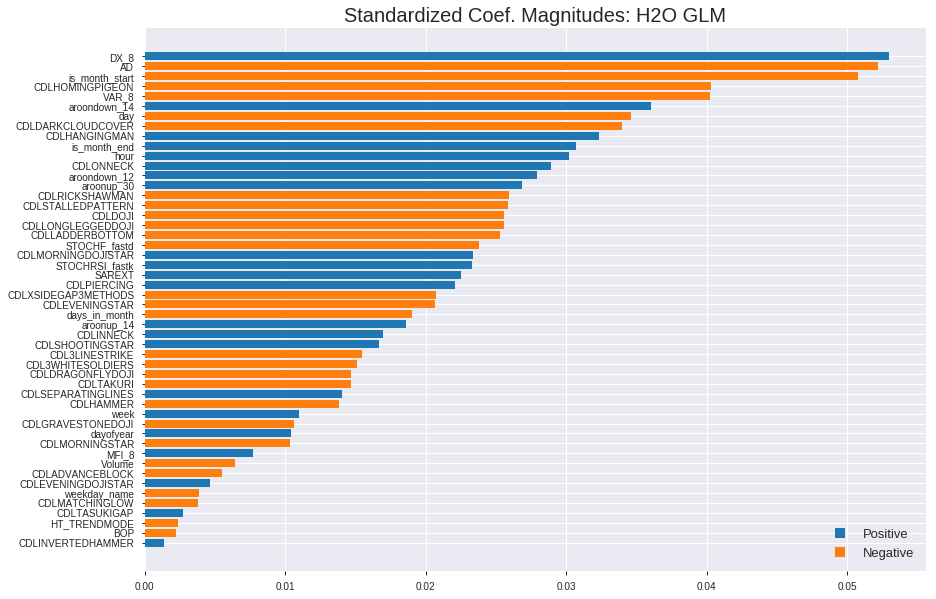

'log_likelihood'
--2019-09-03 03:15:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031506_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031506_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['DX_8',
 'AD',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'VAR_8',
 'aroondown_14',
 'day',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'is_month_end',
 'hour',
 'CDLONNECK',
 'aroondown_12',
 'aroonup_30',
 'CDLRICKSHAWMAN',
 'CDLSTALLEDPATTERN',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLLADDERBOTTOM',
 'STOCHF_fastd',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'SAREXT',
 'CDLPIERCING',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGSTAR',
 'days_in_month',
 'aroonup_14',
 'CDLINNECK',
 'CDLSHOOTINGSTAR',
 'CDL3LINESTRIKE',
 'CDL3WHITESOLDIERS',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'week',
 'CDLGRAVESTONEDOJI',
 'dayofyear',
 'CDLMORNINGSTAR',
 'MFI_8',
 'Volume',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'weekday_name',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'HT_TRENDMODE',
 'BOP',
 'CDLINVERTEDHAMMER']

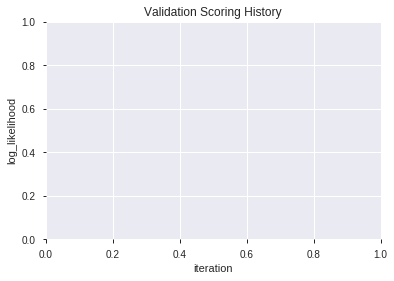

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031518_model_3  0.602670  0.715276              0.465939  0.510052  0.260153
1  XGBoost_grid_1_AutoML_20190903_031518_model_5  0.602265  0.743599              0.500000  0.520372  0.270787
2  XGBoost_grid_1_AutoML_20190903_031518_model_2  0.596764  0.699282              0.413754  0.502867  0.252875
3               XGBoost_1_AutoML_20190903_031518  0.595227  0.714813              0.427670  0.509835  0.259931
4  XGBoost_grid_1_AutoML_20190903_031518_model_1  0.585518  0.719748              0.495833  0.511817  0.261956
5  XGBoost_grid_1_AutoML_20190903_031518_model_6  0.581068  0.708184              0.439523  0.507066  0.257116
6  XGBoost_grid_1_AutoML_20190903_031518_model_4  0.579531  0.701058              0.431149  0.503765  0.253779
7               XGBoost_2_AutoML_20190903_031518  0.572896  0.712532              0.488875  0.508940  0.259020
8  XGBoost_grid_1_AutoML_20190903_031518_model_7  0.571683  0.736456              0.484709  0.519281  0.269653
9               XGBoost_3_AutoML_20190903_031518  0.561084  0.707944              0.468042  0.506808  0.256854

variable  relative_importance  scaled_importance  percentage
0              Volume           382.281769           1.000000    0.098466
1              SAREXT           374.226746           0.978929    0.096391
2                DX_8           333.303223           0.871878    0.085850
3                  AD           316.860687           0.828867    0.081615
4               VAR_8           301.492004           0.788664    0.077656
5        STOCHF_fastd           297.709747           0.778770    0.076682
6                 BOP           246.152359           0.643903    0.063402
7           dayofyear           233.509659           0.610831    0.060146
8                 day           198.273285           0.518657    0.051070
9               MFI_8           185.417725           0.485029    0.047759
10         aroonup_30           139.978134           0.366165    0.036055
11         aroonup_14           138.239029           0.361616    0.035607
12       aroondown_14           135.430511           0.354269    0.034883
13     STOCHRSI_fastk           126.044754           0.329717    0.032466
14               hour           110.626389           0.289384    0.028494
15       aroondown_12            93.829468           0.245446    0.024168
16       weekday_name            65.085381           0.170255    0.016764
17               week            57.678654           0.150880    0.014856
18            CDLDOJI            32.338707           0.084594    0.008330
19     CDLRICKSHAWMAN            31.040386           0.081198    0.007995
20          CDLHAMMER            20.584448           0.053846    0.005302
21       HT_TRENDMODE            19.948368           0.052182    0.005138
22      days_in_month            16.208115           0.042398    0.004175
23       is_month_end             9.686375           0.025338    0.002495
24  CDLLONGLEGGEDDOJI             7.649867           0.020011    0.001970
25          CDLTAKURI             5.758739           0.015064    0.001483
26     is_month_start             3.033946           0.007936    0.000781

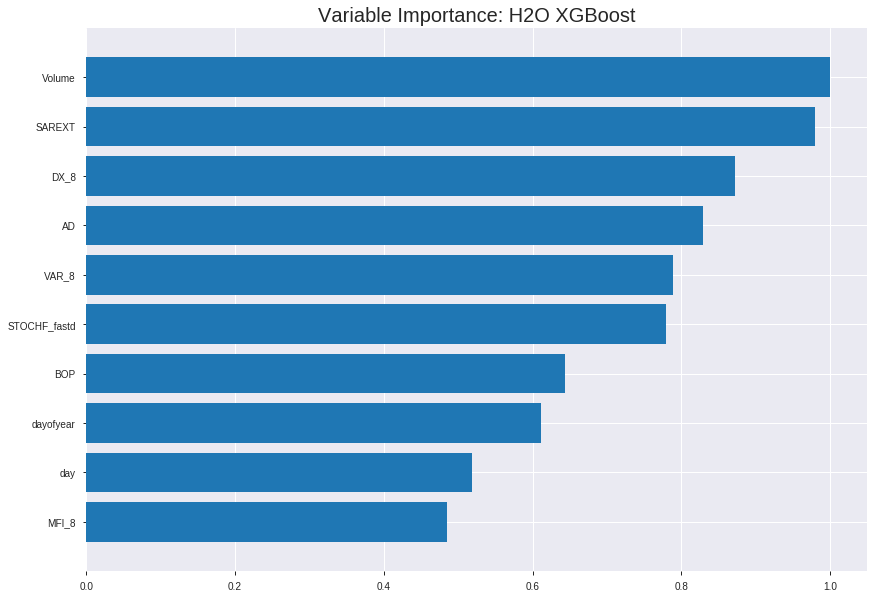

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031518_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1959326007340746
RMSE: 0.44264274616678695
LogLoss: 0.582171352044111
Mean Per-Class Error: 0.19997007715818493
AUC: 0.8806053949897326
pr_auc: 0.8814919748367889
Gini: 0.7612107899794651
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48868195712566376: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      552  215  0.2803   (215.0/767.0)
1      100  693  0.1261   (100.0/793.0)
Total  652  908  0.2019   (315.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488682     0.814815  220
max f2                       0.449078     0.882696  263
max f0point5                 0.534626     0.810164  167
max accuracy                 0.511755     0.8       195
max precision                0.767505     1         0
max recall                   0.279959     1         388
max specificity              0.767505     1         0
max absolute_mcc             0.488682     0.601658  220
max min_per_class_accuracy   0.511755     0.798235  195
max mean_per_class_accuracy  0.511755     0.80003   195

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.716731           1.96721    1.96721            1                0.733542  1                           0.733542            0.0201765       0.0201765                  96.7213   96.7213
    2        0.0205128                   0.6978             1.96721    1.96721            1                0.70584   1                           0.719691            0.0201765       0.0403531                  96.7213   96.7213
    3        0.0301282                   0.687191           1.96721    1.96721            1                0.693588  1                           0.71136             0.0189155       0.0592686                  96.7213   96.7213
    4        0.0403846                   0.676222           1.96721    1.96721            1                0.681924  1                           0.703884            0.0201765       0.0794451                  96.7213   96.7213
    5        0.05                        0.669166           1.83607    1.94199            0.933333         0.671947  0.987179                    0.697743            0.0176545       0.0970996                  83.6066   94.1992
    6        0.1                         0.635318           1.84111    1.89155            0.935897         0.650667  0.961538                    0.674205            0.0920555       0.189155                   84.111    89.1551
    7        0.15                        0.612982           1.86633    1.88314            0.948718         0.624247  0.957265                    0.657552            0.0933165       0.282472                   86.633    88.3144
    8        0.2                         0.591859           1.81589    1.86633            0.923077         0.60275   0.948718                    0.643852            0.0907945       0.373266                   81.5889   86.633
    9        0.3                         0.563038           1.62673    1.78646            0.826923         0.576633  0.90812                     0.621445            0.162673        0.535939                   62.6734   78.6465
    10       0.4                         0.535861           1.3367     1.67402            0.679487         0.548989  0.850962                    0.603331            0.13367         0.669609                   33.6696   67.4023
    11       0.5                         0.511953           1.23581    1.58638            0.628205         0.524233  0.80641                     0.587512            0.123581        0.79319                    23.5813   58.6381
    12       0.6                         0.484515           0.895334   1.47121            0.455128         0.498785  0.747863                    0.572724            0.0895334       0.882724                   -10.4666  47.1206
    13       0.7                         0.455413           0.630517   1.35111            0.320513         0.47133   0.686813                    0.558239            0.0630517       0.945776                   -36.9483  35.1108
    14       0.8                         0.414581           0.290038   1.21847            0.147436         0.435727  0.619391                    0.542925            0.0290038       0.974779                   -70.9962  21.8474
    15       0.9                         0.368405           0.201765   1.10551            0.102564         0.393106  0.561966                    0.526279            0.0201765       0.994956                   -79.8235  10.5507
    16       1                           0.20886            0.0504414  1                  0.025641         0.329616  0.508333                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2616940876026292
RMSE: 0.511560443743092
LogLoss: 0.7170238761692653
Mean Per-Class Error: 0.48717406624383364
AUC: 0.4599013389711064
pr_auc: 0.4529935755362908
Gini: -0.08019732205778718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367404341697693: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    224  0.9697   (224.0/231.0)
1      1    214  0.0047   (1.0/215.0)
Total  8    438  0.5045   (225.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33674      0.655436  391
max f2                       0.306814     0.825653  395
max f0point5                 0.33674      0.543976  391
max accuracy                 0.677477     0.526906  7
max precision                0.735761     1         0
max recall                   0.306814     1         395
max specificity              0.735761     1         0
max absolute_mcc             0.563292     0.115879  99
max min_per_class_accuracy   0.511369     0.480519  199
max mean_per_class_accuracy  0.33674      0.512826  391

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.701709           1.24465   1.24465            0.6              0.714849  0.6                         0.714849            0.0139535       0.0139535                  24.4651    24.4651
    2        0.0201794                   0.673543           1.55581   1.38295            0.75             0.685991  0.666667                    0.702023            0.0139535       0.027907                   55.5814    38.2946
    3        0.0313901                   0.653302           0.414884  1.03721            0.2              0.662778  0.5                         0.688007            0.00465116      0.0325581                  -58.5116   3.72093
    4        0.0403587                   0.646667           0.518605  0.921964           0.25             0.650122  0.444444                    0.679588            0.00465116      0.0372093                  -48.1395   -7.80362
    5        0.0515695                   0.633612           0.414884  0.811729           0.2              0.64058   0.391304                    0.671108            0.00465116      0.0418605                  -58.5116   -18.8271
    6        0.100897                    0.613868           0.848626  0.829767           0.409091         0.621027  0.4                         0.646624            0.0418605       0.0837209                  -15.1374   -17.0233
    7        0.150224                    0.591347           1.03721   0.897883           0.5              0.601693  0.432836                    0.631871            0.0511628       0.134884                   3.72093    -10.2117
    8        0.201794                    0.574739           0.631345  0.829767           0.304348         0.582132  0.4                         0.61916             0.0325581       0.167442                   -36.8655   -17.0233
    9        0.300448                    0.548839           0.990063  0.882402           0.477273         0.560762  0.425373                    0.599984            0.0976744       0.265116                   -0.993658  -11.7598
    10       0.401345                    0.530884           1.10636   0.938703           0.533333         0.539938  0.452514                    0.584889            0.111628        0.376744                   10.6357    -6.12966
    11       0.5                         0.511598           1.03721   0.95814            0.5              0.520964  0.461883                    0.572276            0.102326        0.47907                    3.72093    -4.18605
    12       0.600897                    0.49257            1.01416   0.967546           0.488889         0.501606  0.466418                    0.56041             0.102326        0.581395                   1.41602    -3.2454
    13       0.699552                    0.468              0.990063  0.970722           0.477273         0.478029  0.467949                    0.548792            0.0976744       0.67907                    -0.993658  -2.92785
    14       0.800448                    0.438571           0.921964  0.964576           0.444444         0.455444  0.464986                    0.537025            0.0930233       0.772093                   -7.80362   -3.54244
    15       0.899103                    0.400498           1.08436   0.977718           0.522727         0.419054  0.471322                    0.524081            0.106977        0.87907                    8.43552    -2.22815
    16       1                           0.246632           1.19855   1                  0.577778         0.36164   0.482063         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:15:25  2.127 sec   0                  0.5              0.693147            0.5             0                  1                0.491667                         0.5                0.693147              0.5               0                    1                  0.517937
    2019-09-03 03:15:25  2.249 sec   5                  0.492126         0.677495            0.722937        0.713826           1.96721          0.339744                         0.500526           0.694198              0.471952          0.480728             1.38295            0.506726
    2019-09-03 03:15:25  2.319 sec   10                 0.485659         0.664751            0.756218        0.755398           1.96721          0.339103                         0.500881           0.694913              0.491181          0.48209              1.65953            0.517937
    2019-09-03 03:15:25  2.392 sec   15                 0.479403         0.652503            0.785923        0.787652           1.84426          0.305769                         0.503637           0.700497              0.461532          0.451385             0.829767           0.517937
    2019-09-03 03:15:25  2.465 sec   20                 0.472315         0.638754            0.815865        0.814713           1.84426          0.28141                          0.503621           0.700462              0.469586          0.46234              1.24465            0.506726
    2019-09-03 03:15:25  2.546 sec   25                 0.467558         0.629573            0.828591        0.826771           1.96721          0.257692                         0.504812           0.702891              0.466949          0.454077             0.829767           0.511211
    2019-09-03 03:15:25  2.634 sec   30                 0.461214         0.617368            0.841193        0.839715           1.96721          0.253846                         0.505796           0.704905              0.467804          0.455274             1.24465            0.506726
    2019-09-03 03:15:25  2.708 sec   35                 0.457483         0.610134            0.844414        0.844061           1.96721          0.246795                         0.506764           0.706936              0.466002          0.456847             1.24465            0.511211
    2019-09-03 03:15:25  2.801 sec   40                 0.451949         0.599662            0.860809        0.862204           1.96721          0.225                            0.508527           0.710638              0.462328          0.457899             1.24465            0.504484
    2019-09-03 03:15:26  2.902 sec   45                 0.447069         0.590487            0.873093        0.872494           1.96721          0.207692                         0.509317           0.712282              0.464814          0.459799             1.24465            0.502242
    2019-09-03 03:15:26  2.997 sec   50                 0.442643         0.582171            0.880605        0.881492           1.96721          0.201923                         0.51156            0.717024              0.459901          0.452994             1.24465            0.504484

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
Volume             382.2817687988281      1.0                   0.09846561504625653
SAREXT             374.22674560546875     0.9789290940588949    0.0963908553331838
DX_8               333.30322265625        0.8718784149804628    0.08585004437660655
AD                 316.8606872558594      0.8288668545493837    0.08161488462466111
VAR_8              301.49200439453125     0.7886643544154687    0.07765632072257797
---                ---                    ---                   ---
days_in_month      16.208114624023438     0.0423983457933428    0.004174779195485361
is_month_end       9.68637466430664       0.025338311828843704  0.0024949524584609323
CDLLONGLEGGEDDOJI  7.649867057800293      0.020011069536057205  0.00197040226960128
CDLTAKURI          5.758738994598389      0.01506412145337976   0.001483297984038546
is_month_start     3.0339455604553223     0.007936411851363765  0.0007814636742049326


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6384364820846905)

('auc', 0.6026699029126213)

('logloss', 0.7152758579525479)

('mean_per_class_error', 0.40384304207119737)

('rmse', 0.5100518502327224)

('mse', 0.2601528899258234)

xgboost prediction progress: |████████████████████████████████████████████| 100%


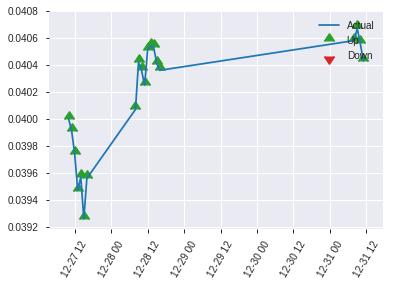


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2601528899258234
RMSE: 0.5100518502327224
LogLoss: 0.7152758579525479
Mean Per-Class Error: 0.40384304207119737
AUC: 0.6026699029126213
pr_auc: 0.530225349711638
Gini: 0.2053398058252427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46702444553375244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   106  0.8833   (106.0/120.0)
1      5    98   0.0485   (5.0/103.0)
Total  19   204  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467024     0.638436  203
max f2                       0.394495     0.812303  221
max f0point5                 0.620093     0.564682  95
max accuracy                 0.620093     0.600897  95
max precision                0.68127      0.645161  30
max recall                   0.394495     1         221
max specificity              0.790199     0.991667  0
max absolute_mcc             0.620093     0.193634  95
max min_per_class_accuracy   0.610902     0.591667  109
max mean_per_class_accuracy  0.620093     0.596157  95

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 59.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.758335           0.721683  0.721683           0.333333         0.775445  0.333333                    0.775445            0.00970874      0.00970874                 -27.8317  -27.8317
    2        0.0224215                   0.742304           1.08252   0.866019           0.5              0.749341  0.4                         0.765003            0.00970874      0.0194175                  8.25243   -13.3981
    3        0.0313901                   0.734866           1.08252   0.927878           0.5              0.736445  0.428571                    0.756843            0.00970874      0.0291262                  8.25243   -7.21221
    4        0.0403587                   0.732471           2.16505   1.2028             1                0.73404   0.555556                    0.751776            0.0194175       0.0485437                  116.505   20.2805
    5        0.0538117                   0.728758           1.44337   1.26294            0.666667         0.730965  0.583333                    0.746573            0.0194175       0.0679612                  44.3366   26.2945
    6        0.103139                    0.700679           1.18094   1.22372            0.545455         0.709359  0.565217                    0.728775            0.0582524       0.126214                   18.0936   22.3723
    7        0.152466                    0.679468           1.37776   1.27356            0.636364         0.68777   0.588235                    0.715509            0.0679612       0.194175                   37.7758   27.3558
    8        0.201794                    0.671201           1.18094   1.25092            0.545455         0.675139  0.577778                    0.705641            0.0582524       0.252427                   18.0936   25.0917
    9        0.300448                    0.648454           1.27935   1.26025            0.590909         0.659793  0.58209                     0.690586            0.126214        0.378641                   27.9347   26.0252
    10       0.399103                    0.624366           0.984113  1.19199            0.454545         0.636431  0.550562                    0.6772              0.0970874       0.475728                   -1.5887   19.1993
    11       0.502242                    0.608906           1.22372   1.19851            0.565217         0.617052  0.553571                    0.664848            0.126214        0.601942                   22.3723   19.8509
    12       0.600897                    0.591508           0.78729   1.131              0.363636         0.599994  0.522388                    0.6542              0.0776699       0.679612                   -21.271   13.0996
    13       0.699552                    0.567313           0.984113  1.11028            0.454545         0.579032  0.512821                    0.6436              0.0970874       0.776699                   -1.5887   11.0281
    14       0.798206                    0.526216           0.78729   1.07036            0.363636         0.547565  0.494382                    0.63173             0.0776699       0.854369                   -21.271   7.03611
    15       0.896861                    0.474195           0.78729   1.03922            0.363636         0.503033  0.48                        0.617573            0.0776699       0.932039                   -21.271   3.92233
    16       1                           0.369769           0.658928  1                  0.304348         0.438183  0.461883                    0.599071      

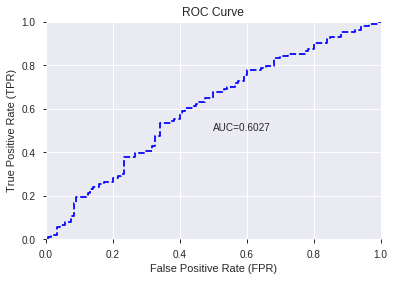

This function is available for GLM models only


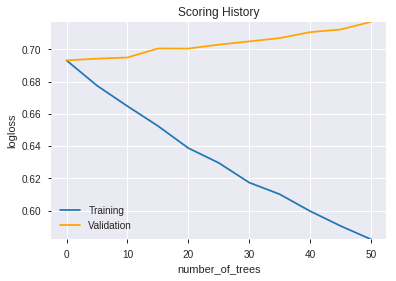

--2019-09-03 03:15:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031518_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031518_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'SAREXT',
 'DX_8',
 'AD',
 'VAR_8',
 'STOCHF_fastd',
 'BOP',
 'dayofyear',
 'day',
 'MFI_8',
 'aroonup_30',
 'aroonup_14',
 'aroondown_14',
 'STOCHRSI_fastk',
 'hour',
 'aroondown_12',
 'weekday_name',
 'week',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'days_in_month',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'CDLTAKURI',
 'is_month_start']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031545_model_1  0.54021  0.738401                   0.5  0.521251  0.271702

variable  relative_importance  scaled_importance    percentage
0                 CDLBELTHOLD         1.909210e-02           1.000000  1.204782e-02
1                          AD         1.840039e-02           0.963770  1.161132e-02
2                        DX_8         1.651449e-02           0.864991  1.042125e-02
3             CDLHOMINGPIGEON         1.566827e-02           0.820667  9.887251e-03
4              is_month_start         1.565890e-02           0.820177  9.881339e-03
...                       ...                  ...                ...           ...
1022                      TAN         5.322631e-06           0.000279  3.358775e-06
1023                     TANH         4.902236e-06           0.000257  3.093490e-06
1024  BBANDS_lowerband_14_4_2         3.796541e-06           0.000199  2.395756e-06
1025  BBANDS_lowerband_14_1_2         8.480059e-07           0.000044  5.351228e-07
1026                  KAMA_30         4.453877e-07           0.000023  2.810560e-07

[1027 rows x 4 columns]

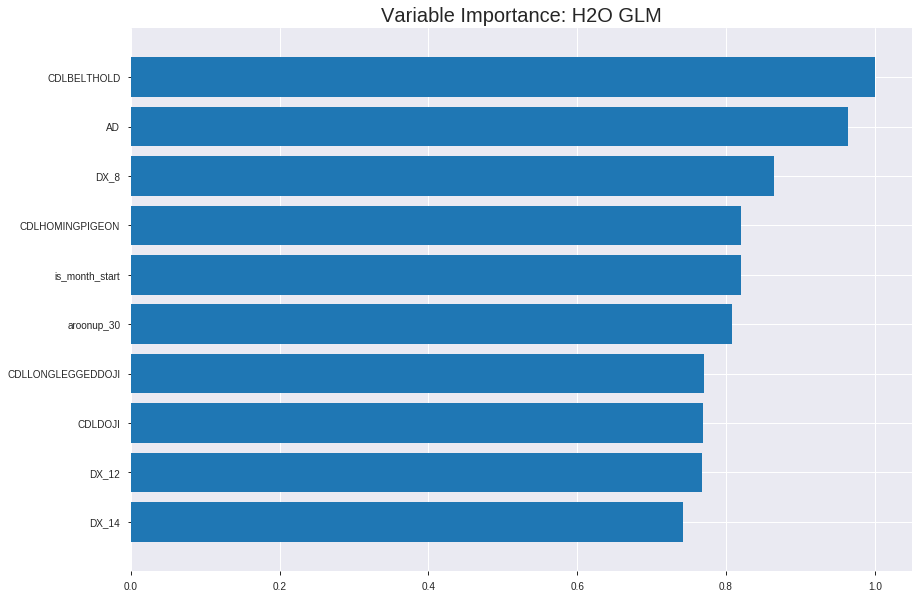

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031545_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2432546318971072
RMSE: 0.4932085075270977
LogLoss: 0.6795536852465536
Null degrees of freedom: 1559
Residual degrees of freedom: 532
Null deviance: 2162.1858499497453
Residual deviance: 2120.207497969247
AIC: 4176.207497969247
AUC: 0.6136122624463403
pr_auc: 0.6166776198593988
Gini: 0.22722452489268052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4287280277563701: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      40   727   0.9478   (727.0/767.0)
1      10   783   0.0126   (10.0/793.0)
Total  50   1510  0.4724   (737.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428728     0.679983  363
max f2                       0.405963     0.839161  388
max f0point5                 0.479731     0.592833  269
max accuracy                 0.508876     0.577564  189
max precision                0.646665     1         0
max recall                   0.401233     1         392
max specificity              0.646665     1         0
max absolute_mcc             0.545494     0.18995   86
max min_per_class_accuracy   0.511675     0.57236   182
max mean_per_class_accuracy  0.526944     0.579189  136

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.593142           1.59836   1.59836            0.8125           0.611065  0.8125                      0.611065            0.0163934       0.0163934                  59.8361   59.8361
    2        0.0205128                   0.58519            1.47541   1.53689            0.75             0.588809  0.78125                     0.599937            0.0151324       0.0315259                  47.541    53.6885
    3        0.0301282                   0.576943           1.18033   1.42309            0.6              0.581185  0.723404                    0.593953            0.0113493       0.0428752                  18.0328   42.309
    4        0.0403846                   0.57171            1.47541   1.43638            0.75             0.574765  0.730159                    0.58908             0.0151324       0.0580076                  47.541    43.6378
    5        0.05                        0.568854           1.04918   1.36192            0.533333         0.570596  0.692308                    0.585525            0.0100883       0.0680958                  4.91803   36.1917
    6        0.1                         0.554889           1.31148   1.3367             0.666667         0.561466  0.679487                    0.573496            0.0655738       0.13367                    31.1475   33.6696
    7        0.15                        0.54671            1.56368   1.41236            0.794872         0.550533  0.717949                    0.565842            0.0781841       0.211854                   56.3682   41.2358
    8        0.2                         0.540362           1.10971   1.3367             0.564103         0.543792  0.679487                    0.560329            0.0554855       0.267339                   10.971    33.6696
    9        0.3                         0.529818           1.08449   1.25263            0.551282         0.535232  0.636752                    0.551964            0.108449        0.375788                   8.44893   25.2627
    10       0.4                         0.51964            0.933165  1.17276            0.474359         0.52481   0.596154                    0.545175            0.0933165       0.469105                   -6.68348  17.2762
    11       0.5                         0.511712           1.02144   1.1425             0.519231         0.515436  0.580769                    0.539227            0.102144        0.571248                   2.14376   14.2497
    12       0.6                         0.502739           0.958386  1.11181            0.487179         0.506896  0.565171                    0.533839            0.0958386       0.667087                   -4.16141  11.1812
    13       0.7                         0.491413           0.920555  1.08449            0.467949         0.497266  0.551282                    0.528614            0.0920555       0.759142                   -7.94451  8.44893
    14       0.8                         0.477419           1.00883   1.07503            0.512821         0.484242  0.546474                    0.523068            0.100883        0.860025                   0.882724  7.50315
    15       0.9                         0.453618           0.74401   1.03825            0.378205         0.467325  0.527778                    0.516874            0.074401        0.934426                   -25.599   3.82514
    16       1                           0.346171           0.655738  1                  0.333333         0.431467  0.508333                    0.508333          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24883831613849672
RMSE: 0.49883696348456047
LogLoss: 0.6908601479597419
Null degrees of freedom: 445
Residual degrees of freedom: -582
Null deviance: 618.9445738826204
Residual deviance: 616.2472519800898
AIC: 2672.24725198009
AUC: 0.5517467029094936
pr_auc: 0.5031977867992642
Gini: 0.10349340581898714
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3958851524486335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    215  0        (0.0/215.0)
Total  2    444  0.5135   (229.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395885     0.652504  397
max f2                       0.395885     0.824387  397
max f0point5                 0.472136     0.560374  287
max accuracy                 0.493272     0.558296  229
max precision                0.648711     1         0
max recall                   0.395885     1         397
max specificity              0.648711     1         0
max absolute_mcc             0.472136     0.132457  287
max min_per_class_accuracy   0.499901     0.541126  202
max mean_per_class_accuracy  0.493272     0.561029  229

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.614886           0.829767  0.829767           0.4              0.63641   0.4                         0.63641             0.00930233      0.00930233                 -17.0233   -17.0233
    2        0.0201794                   0.600387           1.03721   0.921964           0.5              0.605415  0.444444                    0.622635            0.00930233      0.0186047                  3.72093    -7.80362
    3        0.0313901                   0.591392           0.829767  0.889037           0.4              0.595153  0.428571                    0.61282             0.00930233      0.027907                   -17.0233   -11.0963
    4        0.0403587                   0.579524           1.03721   0.921964           0.5              0.586903  0.444444                    0.607061            0.00930233      0.0372093                  3.72093    -7.80362
    5        0.0515695                   0.575889           0.414884  0.811729           0.2              0.577289  0.391304                    0.600588            0.00465116      0.0418605                  -58.5116   -18.8271
    6        0.100897                    0.55246            1.1315    0.968062           0.545455         0.562273  0.466667                    0.581856            0.055814        0.0976744                  13.1501    -3.1938
    7        0.150224                    0.543491           1.1315    1.02173            0.545455         0.54793   0.492537                    0.570716            0.055814        0.153488                   13.1501    2.17286
    8        0.201794                    0.537207           1.1725    1.06026            0.565217         0.540401  0.511111                    0.562969            0.0604651       0.213953                   17.2497    6.02584
    9        0.300448                    0.522682           1.08436   1.06817            0.522727         0.529943  0.514925                    0.552125            0.106977        0.32093                    8.43552    6.81708
    10       0.401345                    0.510599           1.19855   1.10095            0.577778         0.516513  0.530726                    0.543172            0.12093         0.44186                    19.8553    10.0948
    11       0.5                         0.499767           1.03721   1.08837            0.5              0.505292  0.524664                    0.535698            0.102326        0.544186                   3.72093    8.83721
    12       0.600897                    0.48891            1.06026   1.08365            0.511111         0.495239  0.522388                    0.528904            0.106977        0.651163                   6.02584    8.36515
    13       0.699552                    0.473886           0.990063  1.07045            0.477273         0.481794  0.516026                    0.522261            0.0976744       0.748837                   -0.993658  7.04532
    14       0.800448                    0.46329            0.968062  1.05755            0.466667         0.46842   0.509804                    0.515474            0.0976744       0.846512                   -3.1938    5.75467
    15       0.899103                    0.449045           0.612896  1.00876            0.295455         0.45583   0.486284                    0.508929            0.0604651       0.906977                   -38.7104   0.875718
    16       1                           0.359191           0.921964  1                  0.444444         0.428658  0.482063              


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:15:49  0.000 sec   2            2.9       1028          1.37106           1.38396
    2019-09-03 03:15:51  2.035 sec   4            2.1       1028          1.36762           1.38303
    2019-09-03 03:15:53  4.064 sec   6            1.6       1028          1.36365           1.3822
    2019-09-03 03:15:55  6.059 sec   8            1.1       1028          1.35911           1.38172
    2019-09-03 03:15:57  8.083 sec   10           0.83      1028          1.35404           1.38177
    2019-09-03 03:15:59  10.111 sec  12           0.6       1028          1.34852           1.38252
    2019-09-03 03:16:01  12.093 sec  14           0.44      1028          1.34263           1.38431
    2019-09-03 03:16:03  14.200 sec  16           0.32      1028          1.33647           1.38728
    2019-09-03 03:16:06  16.382 sec  18           0.23      1028          1.33013           1.39169

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6319018404907976)

('auc', 0.540210355987055)

('logloss', 0.738401461528794)

('mean_per_class_error', 0.4364886731391586)

('rmse', 0.5212508879246927)

('mse', 0.27170248816228054)

glm prediction progress: |████████████████████████████████████████████████| 100%


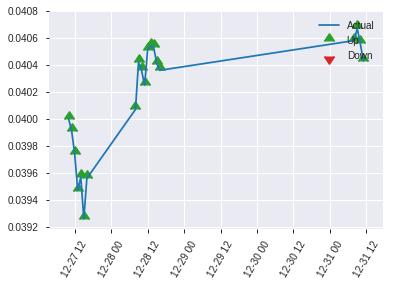


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.27170248816228054
RMSE: 0.5212508879246927
LogLoss: 0.738401461528794
Null degrees of freedom: 222
Residual degrees of freedom: -805
Null deviance: 309.7723147237181
Residual deviance: 329.32705184184215
AIC: 2385.327051841842
AUC: 0.540210355987055
pr_auc: 0.4826328487549679
Gini: 0.08042071197411005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42518185629127614: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    120  1        (120.0/120.0)
1      0    103  0        (0.0/103.0)
Total  0    223  0.5381   (120.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425182     0.631902  222
max f2                       0.425182     0.811024  222
max f0point5                 0.630386     0.531309  105
max accuracy                 0.630386     0.565022  105
max precision                0.726832     1         0
max recall                   0.425182     1         222
max specificity              0.726832     1         0
max absolute_mcc             0.630386     0.126807  105
max min_per_class_accuracy   0.629359     0.553398  109
max mean_per_class_accuracy  0.630386     0.563511  105

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 61.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.707518           1.44337   1.44337            0.666667         0.715253  0.666667                    0.715253            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.70372            1.08252   1.29903            0.5              0.705736  0.6                         0.711446            0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.698483           1.08252   1.23717            0.5              0.701308  0.571429                    0.70855             0.00970874      0.038835                   8.25243   23.7171
    4        0.0403587                   0.692783           0         0.962244           0                0.69593   0.444444                    0.705745            0               0.038835                   -100      -3.77562
    5        0.0538117                   0.691943           1.44337   1.08252            0.666667         0.692222  0.5                         0.702365            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.677323           0.78729   0.941325           0.363636         0.682753  0.434783                    0.692985            0.038835        0.0970874                  -21.271   -5.86745
    7        0.152466                    0.668477           1.18094   1.01885            0.545455         0.671879  0.470588                    0.686156            0.0582524       0.15534                    18.0936   1.88464
    8        0.201794                    0.665705           1.18094   1.05847            0.545455         0.667163  0.488889                    0.681514            0.0582524       0.213592                   18.0936   5.84682
    9        0.300448                    0.655088           1.18094   1.09868            0.545455         0.659877  0.507463                    0.674409            0.116505        0.330097                   18.0936   9.86814
    10       0.399103                    0.6436             1.08252   1.09469            0.5              0.649064  0.505618                    0.668144            0.106796        0.436893                   8.25243   9.46875
    11       0.502242                    0.628307           1.12959   1.10186            0.521739         0.633965  0.508929                    0.661125            0.116505        0.553398                   12.9591   10.1855
    12       0.600897                    0.595141           0.885702  1.06637            0.409091         0.611649  0.492537                    0.653002            0.0873786       0.640777                   -11.4298  6.63672
    13       0.699552                    0.583631           0.78729   1.02701            0.363636         0.588838  0.474359                    0.643953            0.0776699       0.718447                   -21.271   2.70102
    14       0.798206                    0.569438           1.08252   1.03387            0.5              0.577435  0.477528                    0.635732            0.106796        0.825243                   8.25243   3.38715
    15       0.896861                    0.540536           0.885702  1.01757            0.409091         0.55952   0.47                        0.627349            0.0873786       0.912621                   -11.4298  1.75728
    16       1                           0.425182           0.847193  1                  0.391304         0.503711  0.461883                    0.614597       

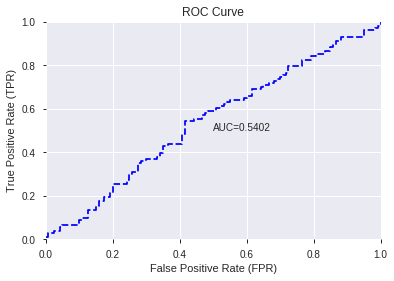

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


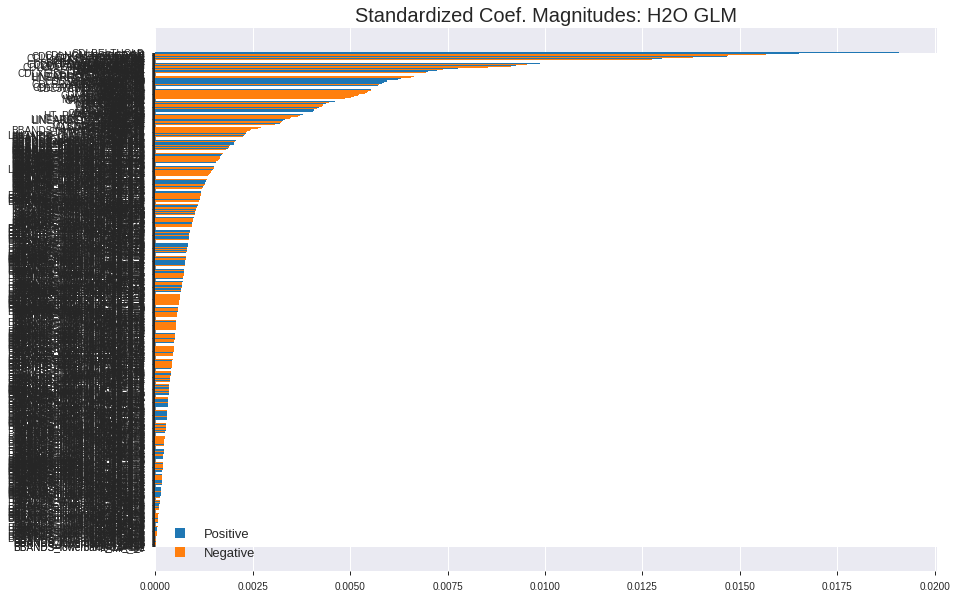

'log_likelihood'
--2019-09-03 03:16:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031545_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031545_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

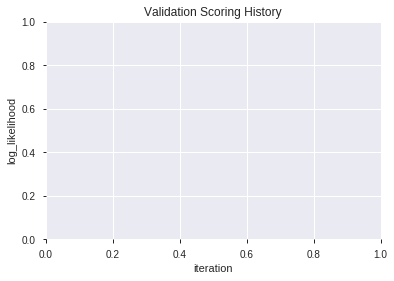

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031638_model_4  0.597937  0.714845              0.487500  0.510371  0.260478
1  XGBoost_grid_1_AutoML_20190903_031638_model_5  0.561003  0.859980              0.419337  0.564895  0.319106
2  XGBoost_grid_1_AutoML_20190903_031638_model_6  0.556149  0.810805              0.471521  0.549477  0.301925
3               XGBoost_2_AutoML_20190903_031638  0.554531  0.750878              0.500000  0.525591  0.276246
4               XGBoost_3_AutoML_20190903_031638  0.550202  0.811941              0.463188  0.550566  0.303123
5  XGBoost_grid_1_AutoML_20190903_031638_model_7  0.548058  0.793934              0.485396  0.542912  0.294753
6  XGBoost_grid_1_AutoML_20190903_031638_model_2  0.541505  0.711759              0.495833  0.509008  0.259089
7  XGBoost_grid_1_AutoML_20190903_031638_model_3  0.541424  0.863108              0.444377  0.564916  0.319130
8  XGBoost_grid_1_AutoML_20190903_031638_model_1  0.526537  0.825703              0.483333  0.555426  0.308498
9               XGBoost_1_AutoML_20190903_031638  0.521117  0.743159              0.487500  0.522677  0.273191

variable  relative_importance  scaled_importance  percentage
0                         AD           113.478592           1.000000    0.038576
1                    WILLR_8            77.063454           0.679101    0.026197
2                       DX_8            76.596703           0.674988    0.026038
3                      CCI_8            68.417191           0.602908    0.023258
4                        DIV            64.507423           0.568455    0.021929
..                       ...                  ...                ...         ...
162                   ROC_12             5.221004           0.046009    0.001775
163  BBANDS_lowerband_24_7_2             5.203018           0.045850    0.001769
164               PLUS_DM_14             4.545214           0.040053    0.001545
165  BBANDS_lowerband_24_1_4             4.528647           0.039908    0.001539
166                 WILLR_12             3.473329           0.030608    0.001181

[167 rows x 4 columns]

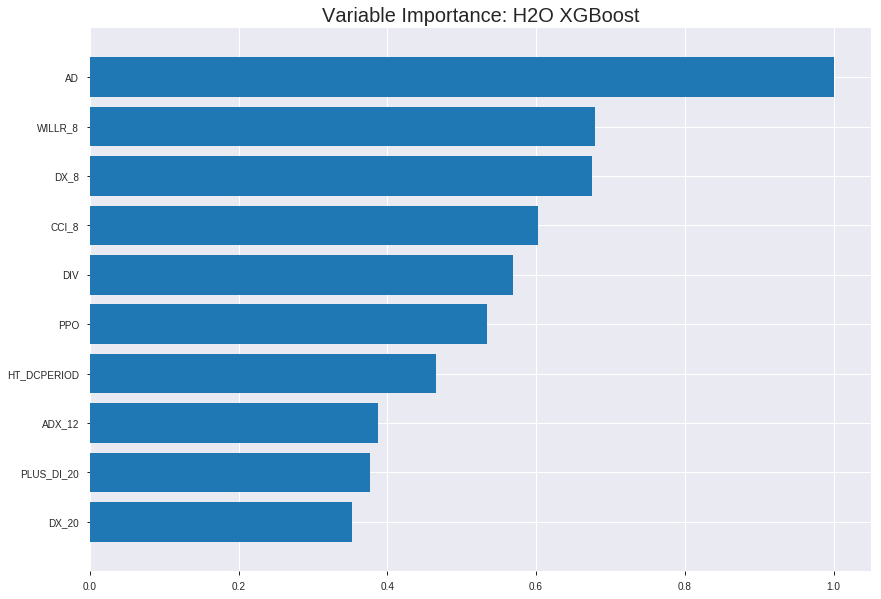

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031638_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21377345151560836
RMSE: 0.46235641178165615
LogLoss: 0.6194580785935023
Mean Per-Class Error: 0.25556244255883054
AUC: 0.8199483419950644
pr_auc: 0.8141461985215463
Gini: 0.6398966839901288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4851105064153671: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      464  303  0.395    (303.0/767.0)
1      108  685  0.1362   (108.0/793.0)
Total  572  988  0.2635   (411.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485111     0.769231  235
max f2                       0.445023     0.862616  288
max f0point5                 0.529708     0.756241  170
max accuracy                 0.505519     0.744872  205
max precision                0.716619     1         0
max recall                   0.324302     1         388
max specificity              0.716619     1         0
max absolute_mcc             0.494942     0.492642  221
max min_per_class_accuracy   0.511816     0.741851  197
max mean_per_class_accuracy  0.505519     0.744438  205

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.669803           1.96721   1.96721            1                0.685577  1                           0.685577            0.0201765       0.0201765                  96.7213   96.7213
    2        0.0205128                   0.655423           1.84426   1.90574            0.9375           0.662934  0.96875                     0.674255            0.0189155       0.0390921                  84.4262   90.5738
    3        0.0301282                   0.645166           1.96721   1.92536            1                0.651555  0.978723                    0.667011            0.0189155       0.0580076                  96.7213   92.5358
    4        0.0403846                   0.638774           1.84426   1.90476            0.9375           0.642216  0.968254                    0.660714            0.0189155       0.0769231                  84.4262   90.4762
    5        0.05                        0.631498           1.44262   1.81589            0.733333         0.635149  0.923077                    0.655797            0.0138714       0.0907945                  44.2623   81.5889
    6        0.1                         0.606092           1.84111   1.8285             0.935897         0.616805  0.929487                    0.636301            0.0920555       0.18285                    84.111    82.8499
    7        0.15                        0.591674           1.68979   1.78226            0.858974         0.598709  0.905983                    0.62377             0.0844893       0.267339                   68.9786   78.2261
    8        0.2                         0.575762           1.48802   1.7087             0.75641          0.583524  0.86859                     0.613709            0.074401        0.34174                    48.802    70.8701
    9        0.3                         0.555149           1.42497   1.61412            0.724359         0.565536  0.820513                    0.597651            0.142497        0.484237                   42.4968   61.4124
    10       0.4                         0.533243           1.37453   1.55422            0.698718         0.543423  0.790064                    0.584094            0.137453        0.62169                    37.4527   55.4224
    11       0.5                         0.512397           1.14754   1.47289            0.583333         0.522443  0.748718                    0.571764            0.114754        0.736444                   14.7541   47.2888
    12       0.6                         0.491969           0.983607  1.39134            0.5              0.501497  0.707265                    0.560053            0.0983607       0.834805                   -1.63934  39.1341
    13       0.7                         0.469543           0.680958  1.28986            0.346154         0.480964  0.655678                    0.548754            0.0680958       0.9029                     -31.9042  28.9858
    14       0.8                         0.441705           0.580076  1.20113            0.294872         0.456705  0.610577                    0.537248            0.0580076       0.960908                   -41.9924  20.1135
    15       0.9                         0.404575           0.252207  1.0957             0.128205         0.422968  0.55698                     0.52455             0.0252207       0.986129                   -74.7793  9.56985
    16       1                           0.273807           0.138714  1                  0.0705128        0.369703  0.508333                    0.509066         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2520947379133839
RMSE: 0.5020903682738636
LogLoss: 0.6976582839054895
Mean Per-Class Error: 0.45340783247759986
AUC: 0.531430584918957
pr_auc: 0.4911728736068872
Gini: 0.06286116983791401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33049342036247253: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    215  0        (0.0/215.0)
Total  2    444  0.5135   (229.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.330493     0.652504   397
max f2                       0.330493     0.824387   397
max f0point5                 0.441444     0.547038   271
max accuracy                 0.503761     0.547085   177
max precision                0.664288     1          0
max recall                   0.330493     1          397
max specificity              0.664288     1          0
max absolute_mcc             0.441444     0.0962238  271
max min_per_class_accuracy   0.487992     0.536797   198
max mean_per_class_accuracy  0.479555     0.546592   216

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.651457           0.829767  0.829767           0.4              0.656631  0.4                         0.656631            0.00930233      0.00930233                 -17.0233  -17.0233
    2        0.0201794                   0.636835           0         0.460982           0                0.645563  0.222222                    0.651712            0               0.00930233                 -100      -53.9018
    3        0.0313901                   0.621994           1.24465   0.740864           0.6              0.628765  0.357143                    0.643516            0.0139535       0.0232558                  24.4651   -25.9136
    4        0.0403587                   0.611974           0.518605  0.691473           0.25             0.618727  0.333333                    0.638008            0.00465116      0.027907                   -48.1395  -30.8527
    5        0.0515695                   0.606687           1.65953   0.901921           0.8              0.609305  0.434783                    0.631768            0.0186047       0.0465116                  65.9535   -9.80789
    6        0.100897                    0.586916           0.848626  0.875866           0.409091         0.597771  0.422222                    0.615147            0.0418605       0.0883721                  -15.1374  -12.4134
    7        0.150224                    0.570971           1.1315    0.959806           0.545455         0.579252  0.462687                    0.603361            0.055814        0.144186                   13.1501   -4.01944
    8        0.201794                    0.556543           1.44307   1.08331            0.695652         0.563349  0.522222                    0.593136            0.0744186       0.218605                   44.3074   8.33075
    9        0.300448                    0.534198           1.03721   1.06817            0.5              0.547779  0.514925                    0.578242            0.102326        0.32093                    3.72093   6.81708
    10       0.401345                    0.513514           1.06026   1.06618            0.511111         0.521957  0.513966                    0.564092            0.106977        0.427907                   6.02584   6.61816
    11       0.5                         0.487913           1.1315    1.07907            0.545455         0.501393  0.520179                    0.551721            0.111628        0.539535                   13.1501   7.90698
    12       0.600897                    0.466074           0.968062  1.06043            0.466667         0.477264  0.511194                    0.539219            0.0976744       0.637209                   -3.1938   6.04304
    13       0.699552                    0.438116           1.03721   1.05716            0.5              0.450874  0.509615                    0.52676             0.102326        0.739535                   3.72093   5.71556
    14       0.800448                    0.416714           0.783669  1.02268            0.377778         0.428606  0.492997                    0.514388            0.0790698       0.818605                   -21.6331  2.26826
    15       0.899103                    0.386438           0.754334  0.993238           0.363636         0.402703  0.478803                    0.502133            0.0744186       0.893023                   -24.5666  -0.676216
    16       1                           0.305329           1.06026   1                  0.511111         0.366612  0.482063                    0.48846 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:17:07  12.119 sec  0                  0.5              0.693147            0.5             0                  1                0.491667                         0.5                0.693147              0.5               0                    1                  0.517937
    2019-09-03 03:17:08  13.335 sec  5                  0.494241         0.681684            0.700256        0.679099           1.59836          0.385897                         0.49859            0.690331              0.552613          0.504744             0.829767           0.517937
    2019-09-03 03:17:08  13.671 sec  10                 0.49009          0.673477            0.724012        0.71885            1.72131          0.384615                         0.498075           0.689297              0.550951          0.515854             1.24465            0.508969
    2019-09-03 03:17:09  14.008 sec  15                 0.486095         0.665612            0.740597        0.735648           1.72131          0.364744                         0.49846            0.69007               0.544065          0.514502             1.65953            0.495516
    2019-09-03 03:17:09  14.362 sec  20                 0.482323         0.658223            0.760802        0.756472           1.84426          0.337821                         0.499997           0.693168              0.522048          0.499965             1.24465            0.513453
    2019-09-03 03:17:09  14.748 sec  25                 0.479274         0.652257            0.771216        0.763562           1.84426          0.312821                         0.501403           0.696015              0.511809          0.484084             0.829767           0.515695
    2019-09-03 03:17:10  15.130 sec  30                 0.475505         0.64489             0.780664        0.774472           1.96721          0.313462                         0.501436           0.696107              0.517427          0.492007             1.24465            0.511211
    2019-09-03 03:17:10  15.487 sec  35                 0.471694         0.637474            0.792783        0.787026           1.96721          0.288462                         0.501797           0.696939              0.524766          0.490409             0.829767           0.513453
    2019-09-03 03:17:11  15.839 sec  40                 0.468801         0.631893            0.801271        0.793338           1.96721          0.282051                         0.501559           0.696509              0.52992           0.487587             1.24465            0.515695
    2019-09-03 03:17:11  16.255 sec  45                 0.465792         0.626081            0.810526        0.802679           1.96721          0.273718                         0.502291           0.698045              0.52682           0.483518             0.414884           0.517937
    2019-09-03 03:17:11  16.626 sec  50                 0.462356         0.619458            0.819948        0.814146           1.96721          0.263462                         0.50209            0.697658              0.531431          0.491173             0.829767           0.513453

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
AD                       113.47859191894531     1.0                   0.03857565205715564
WILLR_8                  77.0634536743164       0.6791012504751622    0.026196773549909163
DX_8                     76.5967025756836       0.6749881301875383    0.026038107252824554
CCI_8                    68.41719055175781      0.6029083494499682    0.023257582710735976
DIV                      64.5074234008789       0.5684545631915737    0.021928505439980542
---                      ---                    ---                   ---
ROC_12                   5.221004009246826      0.04600871337014869   0.0017748161185642606
BBANDS_lowerband_24_7_2  5.2030181884765625     0.04585021809393738   0.0017687020599364304
PLUS_DM_14               4.5452141761779785     0.040053494666416924  0.0015450896739248386
BBANDS_lowerband_24_1_4  4.528647422790527      0.039907504545220455  0.0015394580098057817
WILLR_12                 3.4733285903930664     0.030607787175170195  0.0011807153483088361


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6377708978328174)

('auc', 0.5979368932038834)

('logloss', 0.7148449238515643)

('mean_per_class_error', 0.402467637540453)

('rmse', 0.5103707853153663)

('mse', 0.26047833850342367)

xgboost prediction progress: |████████████████████████████████████████████| 100%


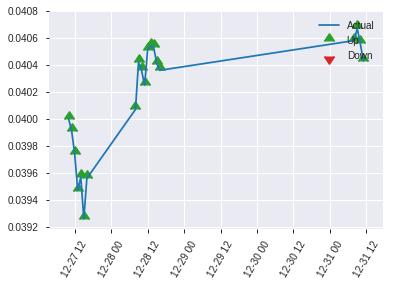


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26047833850342367
RMSE: 0.5103707853153663
LogLoss: 0.7148449238515643
Mean Per-Class Error: 0.402467637540453
AUC: 0.5979368932038834
pr_auc: 0.5310894657035636
Gini: 0.19587378640776687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.422961950302124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    117  0.975    (117.0/120.0)
1      0    103  0        (0.0/103.0)
Total  3    220  0.5247   (117.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422962     0.637771  218
max f2                       0.422962     0.814873  218
max f0point5                 0.614612     0.5666    98
max accuracy                 0.614612     0.600897  98
max precision                0.711872     1         0
max recall                   0.422962     1         218
max specificity              0.711872     1         0
max absolute_mcc             0.614612     0.19554   98
max min_per_class_accuracy   0.609761     0.582524  106
max mean_per_class_accuracy  0.614612     0.597532  98

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 59.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.696168           1.44337   1.44337            0.666667         0.703953  0.666667                    0.703953            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.693375           1.08252   1.29903            0.5              0.695086  0.6                         0.700406            0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.690537           0         0.927878           0                0.692411  0.428571                    0.698122            0               0.0291262                  -100      -7.21221
    4        0.0403587                   0.687688           1.08252   0.962244           0.5              0.689062  0.444444                    0.696108            0.00970874      0.038835                   8.25243   -3.77562
    5        0.0538117                   0.685134           1.44337   1.08252            0.666667         0.686643  0.5                         0.693742            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.668243           1.37776   1.22372            0.636364         0.674007  0.565217                    0.684303            0.0679612       0.126214                   37.7758   22.3723
    7        0.152466                    0.656193           0.78729   1.08252            0.363636         0.660901  0.5                         0.676732            0.038835        0.165049                   -21.271   8.25243
    8        0.201794                    0.644549           1.57458   1.2028             0.727273         0.649953  0.555556                    0.670186            0.0776699       0.242718                   57.4581   20.2805
    9        0.300448                    0.631391           1.37776   1.26025            0.636364         0.637757  0.58209                     0.659538            0.135922        0.378641                   37.7758   26.0252
    10       0.399103                    0.623251           0.984113  1.19199            0.454545         0.627262  0.550562                    0.651559            0.0970874       0.475728                   -1.5887   19.1993
    11       0.502242                    0.606698           1.12959   1.17918            0.521739         0.61427   0.544643                    0.643902            0.116505        0.592233                   12.9591   17.9178
    12       0.600897                    0.593665           0.885702  1.131              0.409091         0.600104  0.522388                    0.636711            0.0873786       0.679612                   -11.4298  13.0996
    13       0.699552                    0.576345           0.78729   1.08252            0.363636         0.585468  0.5                         0.629484            0.0776699       0.757282                   -21.271   8.25243
    14       0.798206                    0.54783            0.78729   1.04603            0.363636         0.562304  0.483146                    0.621181            0.0776699       0.834951                   -21.271   4.60347
    15       0.896861                    0.486214           0.78729   1.01757            0.363636         0.51896   0.47                        0.609937            0.0776699       0.912621                   -21.271   1.75728
    16       1                           0.392422           0.847193  1                  0.391304         0.446303  0.461883                    0.59306        

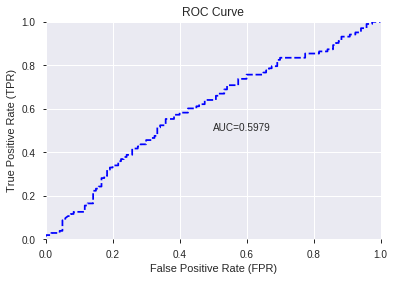

This function is available for GLM models only


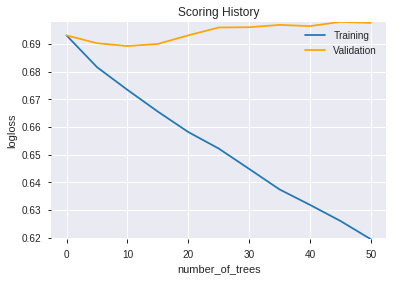

--2019-09-03 03:17:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031638_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031638_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_031741_model_1  0.633819  1.224361              0.495833  0.586308  0.343757
1  DeepLearning_grid_1_AutoML_20190903_031741_model_8  0.614806  0.678249              0.444377  0.492590  0.242645
2  DeepLearning_grid_1_AutoML_20190903_031741_model_7  0.609790  0.703909              0.432565  0.501850  0.251853
3  DeepLearning_grid_1_AutoML_20190903_031741_model_4  0.608576  0.898085              0.430502  0.556875  0.310110
4  DeepLearning_grid_1_AutoML_20190903_031741_model_3  0.608010  0.880958              0.500000  0.537904  0.289341
5  DeepLearning_grid_1_AutoML_20190903_031741_model_6  0.605421  0.680922              0.431877  0.493915  0.243952
6  DeepLearning_grid_1_AutoML_20190903_031741_model_5  0.594741  0.680414              0.439523  0.493736  0.243775
7  DeepLearning_grid_1_AutoML_20190903_031741_model_9  0.582039  0.686738              0.458293  0.496842  0.246852
8               DeepLearning_1_AutoML_20190903_031741  0.561893  0.911531              0.479854  0.575326  0.331000
9  DeepLearning_grid_1_AutoML_20190903_031741_model_2  0.552994  0.899670              0.495833  0.553740  0.306628

variable  relative_importance  scaled_importance  percentage
0          CDLTASUKIGAP             1.000000           1.000000    0.025270
1       CDLHOMINGPIGEON             0.996608           0.996608    0.025185
2       CDLLADDERBOTTOM             0.934539           0.934539    0.023616
3     CDL3WHITESOLDIERS             0.927661           0.927661    0.023442
4     CDLSTALLEDPATTERN             0.916354           0.916354    0.023156
5             CDLINNECK             0.903580           0.903580    0.022834
6        CDLMORNINGSTAR             0.901248           0.901248    0.022775
7     CDLDARKCLOUDCOVER             0.888797           0.888797    0.022460
8    CDLEVENINGDOJISTAR             0.881433           0.881433    0.022274
9        CDLEVENINGSTAR             0.881057           0.881057    0.022264
10   CDLMORNINGDOJISTAR             0.873934           0.873934    0.022084
11            CDLONNECK             0.867272           0.867272    0.021916
12         HT_TRENDMODE             0.857690           0.857690    0.021674
13                  day             0.855226           0.855226    0.021612
14          CDLPIERCING             0.852515           0.852515    0.021543
15      CDLSHOOTINGSTAR             0.841713           0.841713    0.021270
16       is_month_start             0.832187           0.832187    0.021030
17    CDLINVERTEDHAMMER             0.830492           0.830492    0.020987
18      CDLADVANCEBLOCK             0.817172           0.817172    0.020650
19         weekday_name             0.815032           0.815032    0.020596
20               SAREXT             0.809983           0.809983    0.020468
21        days_in_month             0.804908           0.804908    0.020340
22  CDLXSIDEGAP3METHODS             0.791335           0.791335    0.019997
23         is_month_end             0.788580           0.788580    0.019928
24                VAR_8             0.786268           0.786268    0.019869
25         aroondown_14             0.779432           0.779432    0.019696
26   CDLSEPARATINGLINES             0.778165           0.778165    0.019664
27       CDLMATCHINGLOW             0.769855           0.769855    0.019454
28                 hour             0.769517           0.769517    0.019446
29                  BOP             0.769310           0.769310    0.019441
30                 DX_8             0.768049           0.768049    0.019409
31        CDLHANGINGMAN             0.762336           0.762336    0.019264
32       STOCHRSI_fastk             0.755823           0.755823    0.019100
33               Volume             0.750827           0.750827    0.018974
34           aroonup_30             0.748857           0.748857    0.018924
35    CDLGRAVESTONEDOJI             0.739693           0.739693    0.018692
36       CDL3LINESTRIKE             0.735919           0.735919    0.018597
37     CDLDRAGONFLYDOJI             0.730970           0.730970    0.018472
38         STOCHF_fastd             0.710699           0.710699    0.017960
39            CDLTAKURI             0.701968           0.701968    0.017739
40                   AD             0.701304           0.701304    0.017722
41           aroonup_14             0.695480           0.695480    0.017575
42         aroondown_12             0.689051           0.689051    0.017412
43                MFI_8             0.683543           0.683543    0.017273
44            dayofyear             0.666717           0.666717    0.016848
45                 week             0.661570           0.661570    0.016718
46            CDLHAMMER             0.651514           0.651514    0.016464
47    CDLLONGLEGGEDDOJI             0.641858           0.641858    0.016220
48       CDLRICKSHAWMAN             0.628170           0.628170    0.015874
49              CDLDOJI             0.626076           0.626076    0.015821

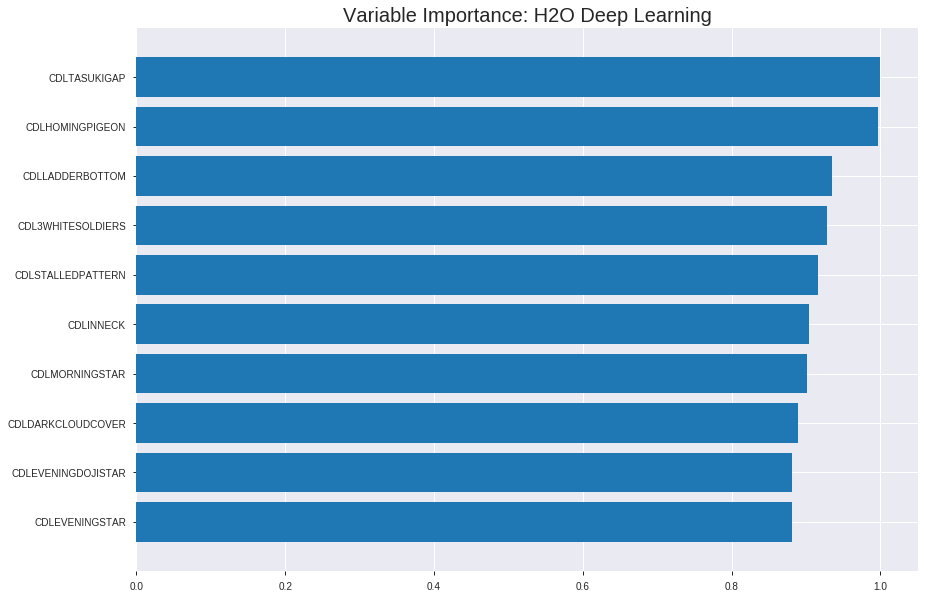

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_031741_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24732741239365835
RMSE: 0.49732023123301383
LogLoss: 0.8704102127883478
Mean Per-Class Error: 0.3541475196101481
AUC: 0.6957767690236111
pr_auc: 0.6912288186642228
Gini: 0.39155353804722215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1224793746113535: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      220  547   0.7132   (547.0/767.0)
1      80   713   0.1009   (80.0/793.0)
Total  300  1260  0.4019   (627.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.122479     0.694593  340
max f2                       7.17758e-05  0.837912  399
max f0point5                 0.656954     0.654923  149
max accuracy                 0.656954     0.644231  149
max precision                0.983074     0.947368  7
max recall                   7.17758e-05  1         399
max specificity              0.999828     0.997392  0
max absolute_mcc             0.69001      0.298763  137
max min_per_class_accuracy   0.535063     0.636822  191
max mean_per_class_accuracy  0.656954     0.645852  149

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.997684           1.72131   1.72131            0.875            0.999669   0.875                       0.999669            0.0176545       0.0176545                  72.1311   72.1311
    2        0.0205128                   0.984642           1.96721   1.84426            1                0.993273   0.9375                      0.996471            0.0201765       0.037831                   96.7213   84.4262
    3        0.0301282                   0.975894           1.70492   1.79979            0.866667         0.980986   0.914894                    0.991529            0.0163934       0.0542245                  70.4918   79.9791
    4        0.0403846                   0.968126           1.59836   1.74863            0.8125           0.971984   0.888889                    0.986565            0.0163934       0.0706179                  59.8361   74.8634
    5        0.05                        0.962603           1.83607   1.76545            0.933333         0.964981   0.897436                    0.982414            0.0176545       0.0882724                  83.6066   76.5448
    6        0.1                         0.927641           1.48802   1.62673            0.75641          0.946745   0.826923                    0.964579            0.074401        0.162673                   48.802    62.6734
    7        0.15                        0.884779           1.48802   1.5805             0.75641          0.906445   0.803419                    0.945201            0.074401        0.237074                   48.802    58.0496
    8        0.2                         0.845583           1.28625   1.50694            0.653846         0.865572   0.766026                    0.925294            0.0643127       0.301387                   28.6255   50.6936
    9        0.3                         0.763736           1.28625   1.43338            0.653846         0.807364   0.728632                    0.885984            0.128625        0.430013                   28.6255   43.3375
    10       0.4                         0.659167           1.12232   1.35561            0.570513         0.714453   0.689103                    0.843101            0.112232        0.542245                   12.232    35.5612
    11       0.5                         0.535965           0.933165  1.27112            0.474359         0.599005   0.646154                    0.794282            0.0933165       0.635561                   -6.68348  27.1122
    12       0.6                         0.407284           0.920555  1.21269            0.467949         0.474834   0.616453                    0.741041            0.0920555       0.727617                   -7.94451  21.2694
    13       0.7                         0.270388           0.870113  1.16375            0.442308         0.338499   0.591575                    0.683535            0.0870113       0.814628                   -12.9887  16.3754
    14       0.8                         0.132426           0.7314    1.10971            0.371795         0.195382   0.564103                    0.622516            0.07314         0.887768                   -26.86    10.971
    15       0.9                         0.0426048          0.617907  1.05507            0.314103         0.0830786  0.536325                    0.562578            0.0617907       0.949559                   -38.2093  5.50652
    16       1                           5.29815e-39        0.504414  1                  0.25641          0.0132271  0.508333                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3739313018503322
RMSE: 0.6114992247340402
LogLoss: 1.4643169904718454
Mean Per-Class Error: 0.48323769254001814
AUC: 0.5033725963958522
pr_auc: 0.5005985403732749
Gini: 0.00674519279170438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.79555444127102e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    215  0        (0.0/215.0)
Total  0    446  0.5179   (231.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       8.79555e-06  0.65053    399
max f2                       8.79555e-06  0.823124   399
max f0point5                 8.79555e-06  0.537769   399
max accuracy                 0.982713     0.533632   12
max precision                1            1          0
max recall                   8.79555e-06  1          399
max specificity              1            1          0
max absolute_mcc             0.982713     0.0995803  12
max min_per_class_accuracy   0.468643     0.497674   207
max mean_per_class_accuracy  0.982713     0.516762   12

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 46.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.992183           1.65953   1.65953            0.8              0.9952      0.8                         0.9952              0.0186047       0.0186047                  65.9535   65.9535
    2        0.0201794                   0.987193           1.03721   1.38295            0.5              0.989145    0.666667                    0.992509            0.00930233      0.027907                   3.72093   38.2946
    3        0.0313901                   0.980371           1.65953   1.48173            0.8              0.98368     0.714286                    0.989356            0.0186047       0.0465116                  65.9535   48.1728
    4        0.0403587                   0.972822           1.03721   1.38295            0.5              0.975958    0.666667                    0.986378            0.00930233      0.055814                   3.72093   38.2946
    5        0.0515695                   0.969633           0.829767  1.26269            0.4              0.971372    0.608696                    0.983116            0.00930233      0.0651163                  -17.0233  26.269
    6        0.100897                    0.944251           0.754334  1.01416            0.363636         0.959496    0.488889                    0.971569            0.0372093       0.102326                   -24.5666  1.41602
    7        0.150224                    0.906378           1.1315    1.05269            0.545455         0.924296    0.507463                    0.956046            0.055814        0.15814                    13.1501   5.269
    8        0.201794                    0.873043           0.721537  0.968062           0.347826         0.886413    0.466667                    0.938251            0.0372093       0.195349                   -27.8463  -3.1938
    9        0.300448                    0.759554           1.1315    1.02173            0.545455         0.822128    0.492537                    0.900121            0.111628        0.306977                   13.1501   2.17286
    10       0.401345                    0.631446           0.829767  0.97347            0.4              0.700055    0.469274                    0.849825            0.0837209       0.390698                   -17.0233  -2.65298
    11       0.5                         0.46611            1.08436   0.995349           0.522727         0.552103    0.479821                    0.791082            0.106977        0.497674                   8.43552   -0.465116
    12       0.600897                    0.283868           1.10636   1.01399            0.533333         0.367363    0.488806                    0.719935            0.111628        0.609302                   10.6357   1.39882
    13       0.699552                    0.16073            1.03721   1.01726            0.5              0.219047    0.490385                    0.649297            0.102326        0.711628                   3.72093   1.7263
    14       0.800448                    0.0591274          0.875866  0.99944            0.422222         0.105071    0.481793                    0.580697            0.0883721       0.8                        -12.4134  -0.0560224
    15       0.899103                    0.0136631          0.942918  0.993238           0.454545         0.0313753   0.478803                    0.520422            0.0930233       0.893023                   -5.70825  -0.676216
    16       1                           6.00522e-30        1.06026   1                  0.511111         0.00345552  0.482


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:17:42  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:17:48  5.696 sec   2801 obs/sec      10        1             15600      0.562171         1.22607             -0.264495      0.572045        0.568215           1.72131          0.491667                         0.606178           1.54428               -0.471701        0.508839          0.481959             2.07442            0.517937
    2019-09-03 03:17:53  11.063 sec  2872 obs/sec      20        2             31200      0.554273         1.18456             -0.229215      0.595654        0.584058           1.47541          0.491667                         0.615345           1.54258               -0.516552        0.479885          0.468656             0.829767           0.517937
    2019-09-03 03:17:58  16.182 sec  2941 obs/sec      30        3             46800      0.528951         1.0446              -0.119468      0.636248        0.624205           1.72131          0.491667                         0.623674           1.59731               -0.557884        0.492349          0.485775             1.65953            0.517937
    2019-09-03 03:18:08  25.612 sec  3088 obs/sec      50        5             78000      0.49732          0.87041             0.0104155      0.695777        0.691229           1.72131          0.401923                         0.611499           1.46432               -0.497653        0.503373          0.500599             1.65953            0.517937
    2019-09-03 03:18:16  34.441 sec  3210 obs/sec      70        7             109200     0.481702         0.853168            0.0715933      0.723611        0.740151           1.96721          0.361538                         0.606103           1.61147               -0.471337        0.510903          0.50512              2.07442            0.517937
    2019-09-03 03:18:25  43.018 sec  3301 obs/sec      90        9             140400     0.446913         0.723209            0.200852       0.779727        0.784434           1.96721          0.312821                         0.630282           1.65802               -0.59107         0.475516          0.475161             1.24465            0.517937
    2019-09-03 03:18:25  43.101 sec  3301 obs/sec      90        9             140400     0.49732          0.87041             0.0104155      0.695777        0.691229           1.72131          0.401923                         0.611499           1.46432               -0.497653        0.503373          0.500599             1.65953            0.517937

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLTASUKIGAP       1.0                    1.0                  0.025270208699789885
CDLHOMINGPIGEON    0.9966083765029907     0.9966083765029907   0.025184501666189348
CDLLADDERBOTTOM    0.9345391988754272     0.9345391988754272   0.02361600059371649
CDL3WHITESOLDIERS  0.9276607036590576     0.9276607036590576   0.023442179584058323
CDLSTALLEDPATTERN  0.9163543581962585     0.9163543581962585   0.023156465874581467
---                ---                    ---                  ---
week               0.6615699529647827     0.6615699529647827   0.016718010780930236
CDLHAMMER          0.6515142917633057     0.6515142917633057   0.01646390212375453
CDLLONGLEGGEDDOJI  0.6418575644493103     0.6418575644493103   0.016219874609172905
CDLRICKSHAWMAN     0.6281703114509583     0.6281703114509583   0.015873994869377725
CDLDOJI            0.6260759830474854     0.6260759830474854   0.015821070753536066


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6322869955156951)

('F1', 0.6338461538461538)

('auc', 0.6338187702265372)

('logloss', 1.2243612022896146)

('mean_per_class_error', 0.3678398058252428)

('rmse', 0.5863075147205625)

('mse', 0.3437565018178027)

deeplearning prediction progress: |███████████████████████████████████████| 100%


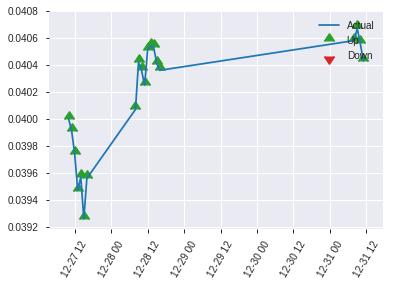


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3437565018178027
RMSE: 0.5863075147205625
LogLoss: 1.2243612022896146
Mean Per-Class Error: 0.3678398058252428
AUC: 0.6338187702265372
pr_auc: 0.5694883784469282
Gini: 0.2676375404530744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.5776305403865336e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    119  0.9917   (119.0/120.0)
1      0    103  0        (0.0/103.0)
Total  1    222  0.5336   (119.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.57763e-05  0.633846  221
max f2                       2.57763e-05  0.812303  221
max f0point5                 0.853946     0.602637  106
max accuracy                 0.885048     0.632287  92
max precision                0.979034     0.69697   32
max recall                   2.57763e-05  1         221
max specificity              0.999881     0.991667  0
max absolute_mcc             0.788659     0.264728  121
max min_per_class_accuracy   0.853946     0.621359  106
max mean_per_class_accuracy  0.788659     0.63216   121

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 69.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.998704           1.44337   1.44337            0.666667         0.999316   0.666667                    0.999316            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.996227           0         0.866019           0                0.997691   0.4                         0.998666            0               0.0194175                  -100      -13.3981
    3        0.0313901                   0.993841           2.16505   1.23717            1                0.994659   0.571429                    0.997521            0.0194175       0.038835                   116.505   23.7171
    4        0.0403587                   0.99327            0         0.962244           0                0.993369   0.444444                    0.996598            0               0.038835                   -100      -3.77562
    5        0.0538117                   0.991733           1.44337   1.08252            0.666667         0.992521   0.5                         0.995579            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.985945           1.7714    1.41199            0.818182         0.987852   0.652174                    0.991883            0.0873786       0.145631                   77.1403   41.1988
    7        0.152466                    0.978488           1.57458   1.46459            0.727273         0.98175    0.676471                    0.988605            0.0776699       0.223301                   57.4581   46.4592
    8        0.201794                    0.966629           0.984113  1.34714            0.454545         0.972704   0.622222                    0.984718            0.0485437       0.271845                   -1.5887   34.7141
    9        0.300448                    0.937006           1.27935   1.32488            0.590909         0.952825   0.61194                     0.974246            0.126214        0.398058                   27.9347   32.488
    10       0.399103                    0.896895           1.27935   1.31362            0.590909         0.918464   0.606742                    0.960457            0.126214        0.524272                   27.9347   31.3625
    11       0.502242                    0.84613            1.03546   1.2565             0.478261         0.87003    0.580357                    0.941887            0.106796        0.631068                   3.5458    25.6501
    12       0.600897                    0.706487           0.885702  1.19562            0.409091         0.786712   0.552239                    0.916411            0.0873786       0.718447                   -11.4298  19.5624
    13       0.699552                    0.610302           0.590468  1.11028            0.272727         0.664776   0.512821                    0.880924            0.0582524       0.776699                   -40.9532  11.0281
    14       0.798206                    0.383098           0.590468  1.04603            0.272727         0.501792   0.483146                    0.834065            0.0582524       0.834951                   -40.9532  4.60347
    15       0.896861                    0.126493           0.590468  0.995922           0.272727         0.245942   0.46                        0.769371            0.0582524       0.893204                   -40.9532  -0.407767
    16       1                           4.42662e-06        1.03546   1                  0.478261         0.0486526  0.461883                

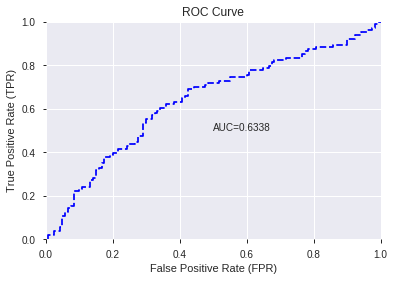

This function is available for GLM models only


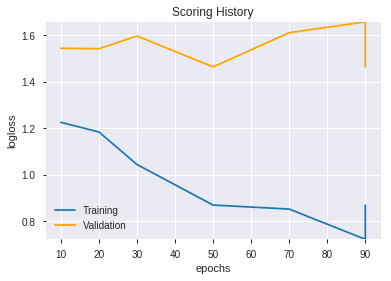

--2019-09-03 03:24:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_031741_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_031741_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'HT_TRENDMODE',
 'day',
 'CDLPIERCING',
 'CDLSHOOTINGSTAR',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'weekday_name',
 'SAREXT',
 'days_in_month',
 'CDLXSIDEGAP3METHODS',
 'is_month_end',
 'VAR_8',
 'aroondown_14',
 'CDLSEPARATINGLINES',
 'CDLMATCHINGLOW',
 'hour',
 'BOP',
 'DX_8',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'Volume',
 'aroonup_30',
 'CDLGRAVESTONEDOJI',
 'CDL3LINESTRIKE',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastd',
 'CDLTAKURI',
 'AD',
 'aroonup_14',
 'aroondown_12',
 'MFI_8',
 'dayofyear',
 'week',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN',
 'CDLDOJI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_032429_model_1  0.579207  0.691896              0.461084  0.499394  0.249395

variable  relative_importance  scaled_importance  percentage
0                  DX_8             0.052967           1.000000    0.050705
1                    AD             0.052162           0.984790    0.049934
2        is_month_start             0.050795           0.958988    0.048626
3       CDLHOMINGPIGEON             0.040328           0.761367    0.038605
4                 VAR_8             0.040226           0.759448    0.038508
5          aroondown_14             0.036044           0.680493    0.034505
6                   day             0.034612           0.653450    0.033133
7     CDLDARKCLOUDCOVER             0.033992           0.641752    0.032540
8         CDLHANGINGMAN             0.032357           0.610880    0.030975
9          is_month_end             0.030720           0.579987    0.029408
10                 hour             0.030179           0.569762    0.028890
11            CDLONNECK             0.028899           0.545591    0.027664
12         aroondown_12             0.027908           0.526892    0.026716
13           aroonup_30             0.026875           0.507391    0.025727
14       CDLRICKSHAWMAN             0.025913           0.489228    0.024806
15    CDLSTALLEDPATTERN             0.025873           0.488467    0.024768
16              CDLDOJI             0.025543           0.482238    0.024452
17    CDLLONGLEGGEDDOJI             0.025538           0.482154    0.024448
18      CDLLADDERBOTTOM             0.025274           0.477165    0.024195
19         STOCHF_fastd             0.023781           0.448966    0.022765
20   CDLMORNINGDOJISTAR             0.023341           0.440676    0.022345
21       STOCHRSI_fastk             0.023299           0.439874    0.022304
22               SAREXT             0.022516           0.425090    0.021554
23          CDLPIERCING             0.022096           0.417155    0.021152
24  CDLXSIDEGAP3METHODS             0.020764           0.392018    0.019877
25       CDLEVENINGSTAR             0.020662           0.390083    0.019779
26        days_in_month             0.019041           0.359489    0.018228
27           aroonup_14             0.018576           0.350707    0.017783
28            CDLINNECK             0.016972           0.320433    0.016248
29      CDLSHOOTINGSTAR             0.016677           0.314863    0.015965
30       CDL3LINESTRIKE             0.015448           0.291652    0.014788
31    CDL3WHITESOLDIERS             0.015125           0.285550    0.014479
32     CDLDRAGONFLYDOJI             0.014686           0.277259    0.014058
33            CDLTAKURI             0.014663           0.276823    0.014036
34   CDLSEPARATINGLINES             0.014034           0.264955    0.013435
35            CDLHAMMER             0.013803           0.260586    0.013213
36                 week             0.010955           0.206819    0.010487
37    CDLGRAVESTONEDOJI             0.010607           0.200247    0.010154
38            dayofyear             0.010435           0.197012    0.009990
39       CDLMORNINGSTAR             0.010345           0.195305    0.009903
40                MFI_8             0.007675           0.144906    0.007347
41               Volume             0.006449           0.121752    0.006173
42      CDLADVANCEBLOCK             0.005516           0.104138    0.005280
43   CDLEVENINGDOJISTAR             0.004611           0.087054    0.004414
44         weekday_name             0.003886           0.073360    0.003720
45       CDLMATCHINGLOW             0.003773           0.071225    0.003611
46         CDLTASUKIGAP             0.002736           0.051647    0.002619
47         HT_TRENDMODE             0.002345           0.044268    0.002245
48                  BOP             0.002202           0.041579    0.002108
49    CDLINVERTEDHAMMER             0.001393           0.026305    0.001334

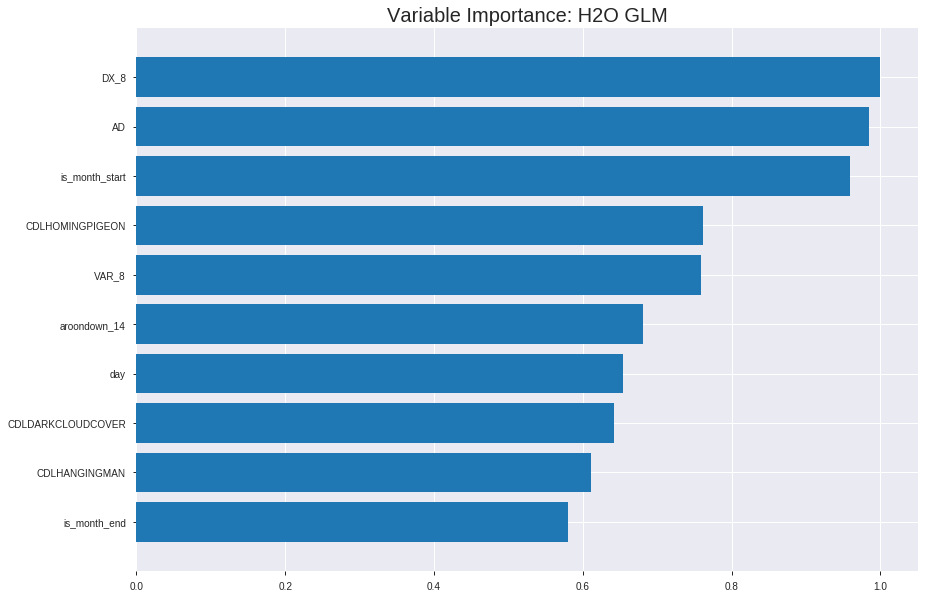

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_032429_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24409647819953897
RMSE: 0.49406120896052846
LogLoss: 0.6810874121530605
Null degrees of freedom: 1559
Residual degrees of freedom: 1509
Null deviance: 2162.1858499497453
Residual deviance: 2124.992725917549
AIC: 2226.992725917549
AUC: 0.5959931341875044
pr_auc: 0.596447865552998
Gini: 0.19198626837500887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3971467655868542: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   748   0.9752   (748.0/767.0)
1      3    790   0.0038   (3.0/793.0)
Total  22   1538  0.4814   (751.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397147     0.677821  380
max f2                       0.384357     0.839517  385
max f0point5                 0.492511     0.590816  243
max accuracy                 0.497839     0.572436  228
max precision                0.762906     1         0
max recall                   0.354751     1         392
max specificity              0.762906     1         0
max absolute_mcc             0.485188     0.153632  261
max min_per_class_accuracy   0.512024     0.554107  183
max mean_per_class_accuracy  0.503761     0.57018   210

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.603005           1.72131   1.72131            0.875            0.642499  0.875                       0.642499            0.0176545       0.0176545                  72.1311   72.1311
    2        0.0205128                   0.577751           1.22951   1.47541            0.625            0.58555   0.75                        0.614025            0.0126103       0.0302648                  22.9508   47.541
    3        0.0301282                   0.569437           1.44262   1.46495            0.733333         0.573489  0.744681                    0.601088            0.0138714       0.0441362                  44.2623   46.4946
    4        0.0403846                   0.565315           1.10656   1.37393            0.5625           0.567665  0.698413                    0.592599            0.0113493       0.0554855                  10.6557   37.3927
    5        0.05                        0.562386           1.44262   1.38714            0.733333         0.563873  0.705128                    0.587075            0.0138714       0.0693569                  44.2623   38.7137
    6        0.1                         0.552877           1.18537   1.28625            0.602564         0.556854  0.653846                    0.571964            0.0592686       0.128625                   18.5372   28.6255
    7        0.15                        0.544988           1.16015   1.24422            0.589744         0.548753  0.632479                    0.564227            0.0580076       0.186633                   16.0151   24.422
    8        0.2                         0.539614           1.23581   1.24212            0.628205         0.542262  0.63141                     0.558736            0.0617907       0.248424                   23.5813   24.2119
    9        0.3                         0.528388           1.10971   1.19798            0.564103         0.533845  0.608974                    0.550439            0.110971        0.359395                   10.971    19.7982
    10       0.4                         0.519896           0.958386  1.13808            0.487179         0.523968  0.578526                    0.543821            0.0958386       0.455233                   -4.16141  13.8083
    11       0.5                         0.51201            0.996217  1.10971            0.50641          0.515785  0.564103                    0.538214            0.0996217       0.554855                   -0.37831  10.971
    12       0.6                         0.503374           1.13493   1.11391            0.576923         0.507817  0.566239                    0.533148            0.113493        0.668348                   13.4931   11.3913
    13       0.7                         0.495776           0.983607  1.0953             0.5              0.499639  0.556777                    0.528361            0.0983607       0.766709                   -1.63934  9.52981
    14       0.8                         0.482407           0.870113  1.06715            0.442308         0.489624  0.542468                    0.523519            0.0870113       0.85372                    -12.9887  6.71501
    15       0.9                         0.457004           0.75662   1.03265            0.384615         0.470896  0.524929                    0.517672            0.075662        0.929382                   -24.338   3.26468
    16       1                           0.182132           0.706179  1                  0.358974         0.424288  0.508333                    0.508333            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2469571902835421
RMSE: 0.49694787481539965
LogLoss: 0.686851609102308
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.9445738826204
Residual deviance: 612.6716353192587
AIC: 714.6716353192587
AUC: 0.5402295379039564
pr_auc: 0.5140252515521841
Gini: 0.0804590758079129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4357205787516257: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   208  0.9004   (208.0/231.0)
1      8    207  0.0372   (8.0/215.0)
Total  31   415  0.4843   (216.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435721     0.657143  368
max f2                       0.354868     0.824387  397
max f0point5                 0.435721     0.552     368
max accuracy                 0.506127     0.55157   190
max precision                0.730128     1         0
max recall                   0.354868     1         397
max specificity              0.730128     1         0
max absolute_mcc             0.435721     0.122521  368
max min_per_class_accuracy   0.505199     0.541126  195
max mean_per_class_accuracy  0.506127     0.551153  190

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.610288           2.07442   2.07442            1                0.671683  1                           0.671683            0.0232558       0.0232558                  107.442   107.442
    2        0.0201794                   0.561513           0.518605  1.38295            0.25             0.568454  0.666667                    0.625804            0.00465116      0.027907                   -48.1395  38.2946
    3        0.0313901                   0.557288           0.829767  1.18538            0.4              0.558682  0.571429                    0.601832            0.00930233      0.0372093                  -17.0233  18.5382
    4        0.0403587                   0.551806           0.518605  1.03721            0.25             0.553829  0.5                         0.591164            0.00465116      0.0418605                  -48.1395  3.72093
    5        0.0515695                   0.550373           0.829767  0.992113           0.4              0.551049  0.478261                    0.582444            0.00930233      0.0511628                  -17.0233  -0.788675
    6        0.100897                    0.540238           1.03721   1.01416            0.5              0.544055  0.488889                    0.563676            0.0511628       0.102326                   3.72093   1.41602
    7        0.150224                    0.535354           1.03721   1.02173            0.5              0.537776  0.492537                    0.555172            0.0511628       0.153488                   3.72093   2.17286
    8        0.201794                    0.530051           1.35288   1.10636            0.652174         0.532409  0.533333                    0.549354            0.0697674       0.223256                   35.2882   10.6357
    9        0.300448                    0.521093           0.895772  1.03721            0.431818         0.524851  0.5                         0.541309            0.0883721       0.311628                   -10.4228  3.72093
    10       0.401345                    0.512967           1.10636   1.05459            0.533333         0.516788  0.50838                     0.535144            0.111628        0.423256                   10.6357   5.45927
    11       0.5                         0.505041           1.22579   1.08837            0.590909         0.50927   0.524664                    0.530039            0.12093         0.544186                   22.5793   8.83721
    12       0.600897                    0.493834           0.783669  1.03721            0.377778         0.499217  0.5                         0.524864            0.0790698       0.623256                   -21.6331  3.72093
    13       0.699552                    0.483033           1.03721   1.03721            0.5              0.48887   0.5                         0.519788            0.102326        0.725581                   3.72093   3.72093
    14       0.800448                    0.473053           0.968062  1.02849            0.466667         0.47913   0.495798                    0.514663            0.0976744       0.823256                   -3.1938   2.84933
    15       0.899103                    0.449387           1.03721   1.02945            0.5              0.463399  0.496259                    0.509038            0.102326        0.925581                   3.72093   2.94496
    16       1                           0.281451           0.737571  1                  0.355556         0.414287  0.482063                    0.499478       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:24:29  0.000 sec   2            2.9       51            1.38062           1.38299
    2019-09-03 03:24:29  0.009 sec   4            1.8       51            1.37819           1.38107
    2019-09-03 03:24:29  0.021 sec   6            1.1       51            1.37506           1.37884
    2019-09-03 03:24:29  0.035 sec   8            0.7       51            1.37125           1.37658
    2019-09-03 03:24:29  0.049 sec   10           0.44      51            1.36688           1.37471
    2019-09-03 03:24:29  0.063 sec   12           0.27      51            1.36217           1.3737
    2019-09-03 03:24:29  0.077 sec   14           0.17      51            1.35747           1.37405
    2019-09-03 03:24:29  0.090 sec   16           0.1       51            1.35313           1.37609
    2019-09-03 03:24:29  0.105 sec   18           0.065     51            1.34945           1.37989
    2019-09-03 03:24:29  0.125 sec   20           0.04      51            1.3466            1.38517
    2019-09-03 03:24:29  0.138 sec   22           0.025     51            1.34459           1.39135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6428571428571429)

('auc', 0.5792071197411004)

('logloss', 0.6918955386825394)

('mean_per_class_error', 0.42055016181229776)

('rmse', 0.49939425178289226)

('mse', 0.24939461871379479)

glm prediction progress: |████████████████████████████████████████████████| 100%


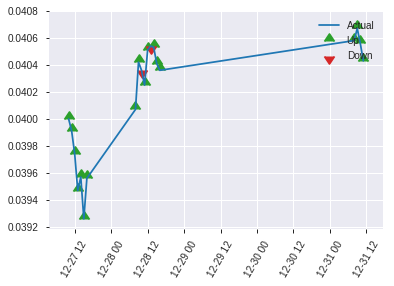


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24939461871379479
RMSE: 0.49939425178289226
LogLoss: 0.6918955386825394
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.7723147237181
Residual deviance: 308.58541025241254
AIC: 410.58541025241254
AUC: 0.5792071197411004
pr_auc: 0.5049619906606597
Gini: 0.1584142394822008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4799278096977408: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   106  0.8833   (106.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  18   205  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479928     0.642857  204
max f2                       0.375924     0.813586  220
max f0point5                 0.541323     0.54955   112
max accuracy                 0.541917     0.578475  110
max precision                0.615581     1         0
max recall                   0.375924     1         220
max specificity              0.615581     1         0
max absolute_mcc             0.50184      0.161089  176
max min_per_class_accuracy   0.541917     0.575     110
max mean_per_class_accuracy  0.541323     0.57945   112

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 53.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.599704           1.44337   1.44337            0.666667         0.609749  0.666667                    0.609749            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.594724           0         0.866019           0                0.595122  0.4                         0.603899            0               0.0194175                  -100      -13.3981
    3        0.0313901                   0.594266           2.16505   1.23717            1                0.594447  0.571429                    0.601198            0.0194175       0.038835                   116.505   23.7171
    4        0.0403587                   0.59104            1.08252   1.2028             0.5              0.593738  0.555556                    0.59954             0.00970874      0.0485437                  8.25243   20.2805
    5        0.0538117                   0.586899           0         0.902104           0                0.588711  0.416667                    0.596833            0               0.0485437                  -100      -9.78964
    6        0.103139                    0.58029            1.18094   1.03546            0.545455         0.583261  0.478261                    0.590342            0.0582524       0.106796                   18.0936   3.5458
    7        0.152466                    0.56816            0.984113  1.01885            0.454545         0.57425   0.470588                    0.585136            0.0485437       0.15534                    -1.5887   1.88464
    8        0.201794                    0.564347           1.57458   1.15469            0.727273         0.565876  0.533333                    0.580428            0.0776699       0.23301                    57.4581   15.4693
    9        0.300448                    0.555705           1.18094   1.16331            0.545455         0.560652  0.537313                    0.573934            0.116505        0.349515                   18.0936   16.331
    10       0.399103                    0.549237           1.18094   1.16767            0.545455         0.552421  0.539326                    0.568616            0.116505        0.466019                   18.0936   16.7667
    11       0.502242                    0.541421           1.12959   1.15985            0.521739         0.545555  0.535714                    0.563881            0.116505        0.582524                   12.9591   15.9847
    12       0.600897                    0.532024           0.885702  1.11484            0.409091         0.537167  0.514925                    0.559495            0.0873786       0.669903                   -11.4298  11.4838
    13       0.699552                    0.519186           0.984113  1.0964             0.454545         0.526692  0.50641                     0.554869            0.0970874       0.76699                    -1.5887   9.64028
    14       0.798206                    0.501304           0.984113  1.08252            0.454545         0.512249  0.5                         0.549601            0.0970874       0.864078                   -1.5887   8.25243
    15       0.896861                    0.482393           0.688879  1.03922            0.318182         0.490876  0.48                        0.543141            0.0679612       0.932039                   -31.1121  3.92233
    16       1                           0.323713           0.658928  1                  0.304348         0.442381  0.461883                    0.532749         

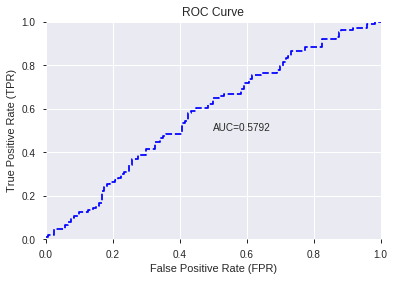

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


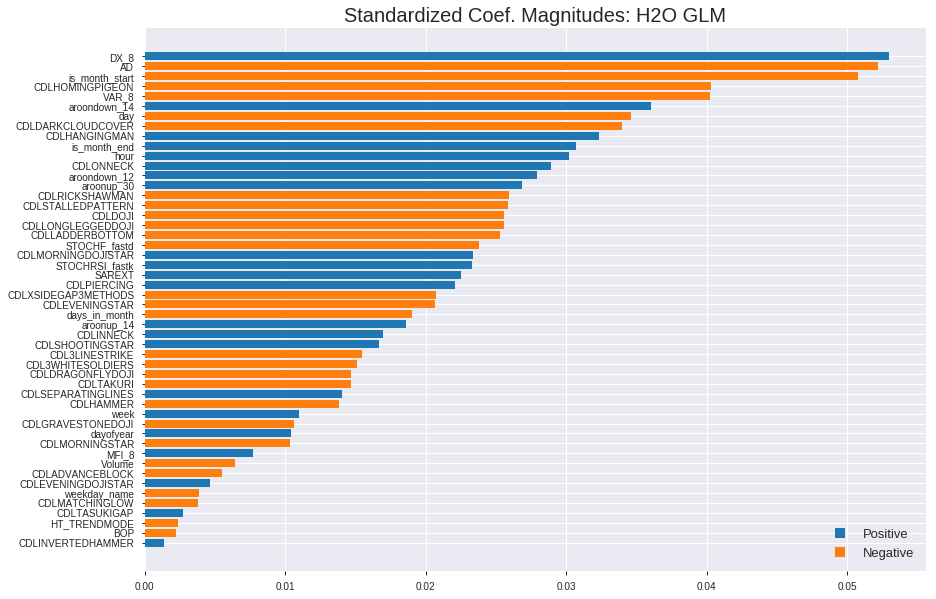

'log_likelihood'
--2019-09-03 03:24:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_032429_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_032429_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['DX_8',
 'AD',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'VAR_8',
 'aroondown_14',
 'day',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'is_month_end',
 'hour',
 'CDLONNECK',
 'aroondown_12',
 'aroonup_30',
 'CDLRICKSHAWMAN',
 'CDLSTALLEDPATTERN',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLLADDERBOTTOM',
 'STOCHF_fastd',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'SAREXT',
 'CDLPIERCING',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGSTAR',
 'days_in_month',
 'aroonup_14',
 'CDLINNECK',
 'CDLSHOOTINGSTAR',
 'CDL3LINESTRIKE',
 'CDL3WHITESOLDIERS',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'week',
 'CDLGRAVESTONEDOJI',
 'dayofyear',
 'CDLMORNINGSTAR',
 'MFI_8',
 'Volume',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'weekday_name',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'HT_TRENDMODE',
 'BOP',
 'CDLINVERTEDHAMMER']

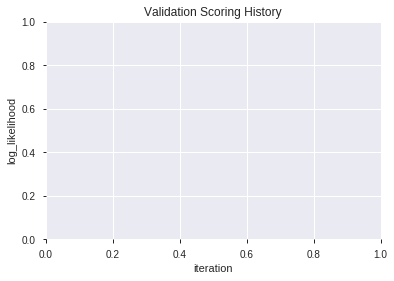

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_032440_model_3  0.602670  0.715276              0.465939  0.510052  0.260153
1  XGBoost_grid_1_AutoML_20190903_032440_model_5  0.602265  0.743599              0.500000  0.520372  0.270787
2  XGBoost_grid_1_AutoML_20190903_032440_model_2  0.596764  0.699282              0.413754  0.502867  0.252875
3               XGBoost_1_AutoML_20190903_032440  0.595227  0.714813              0.427670  0.509835  0.259931
4  XGBoost_grid_1_AutoML_20190903_032440_model_1  0.585518  0.719748              0.495833  0.511817  0.261956
5  XGBoost_grid_1_AutoML_20190903_032440_model_6  0.581068  0.708184              0.439523  0.507066  0.257116
6  XGBoost_grid_1_AutoML_20190903_032440_model_4  0.579531  0.701058              0.431149  0.503765  0.253779
7               XGBoost_2_AutoML_20190903_032440  0.572896  0.712532              0.488875  0.508940  0.259020
8  XGBoost_grid_1_AutoML_20190903_032440_model_7  0.571683  0.736456              0.484709  0.519281  0.269653
9               XGBoost_3_AutoML_20190903_032440  0.561084  0.707944              0.468042  0.506808  0.256854

variable  relative_importance  scaled_importance  percentage
0              Volume           382.281769           1.000000    0.098466
1              SAREXT           374.226746           0.978929    0.096391
2                DX_8           333.303223           0.871878    0.085850
3                  AD           316.860687           0.828867    0.081615
4               VAR_8           301.492004           0.788664    0.077656
5        STOCHF_fastd           297.709747           0.778770    0.076682
6                 BOP           246.152359           0.643903    0.063402
7           dayofyear           233.509659           0.610831    0.060146
8                 day           198.273285           0.518657    0.051070
9               MFI_8           185.417725           0.485029    0.047759
10         aroonup_30           139.978134           0.366165    0.036055
11         aroonup_14           138.239029           0.361616    0.035607
12       aroondown_14           135.430511           0.354269    0.034883
13     STOCHRSI_fastk           126.044754           0.329717    0.032466
14               hour           110.626389           0.289384    0.028494
15       aroondown_12            93.829468           0.245446    0.024168
16       weekday_name            65.085381           0.170255    0.016764
17               week            57.678654           0.150880    0.014856
18            CDLDOJI            32.338707           0.084594    0.008330
19     CDLRICKSHAWMAN            31.040386           0.081198    0.007995
20          CDLHAMMER            20.584448           0.053846    0.005302
21       HT_TRENDMODE            19.948368           0.052182    0.005138
22      days_in_month            16.208115           0.042398    0.004175
23       is_month_end             9.686375           0.025338    0.002495
24  CDLLONGLEGGEDDOJI             7.649867           0.020011    0.001970
25          CDLTAKURI             5.758739           0.015064    0.001483
26     is_month_start             3.033946           0.007936    0.000781

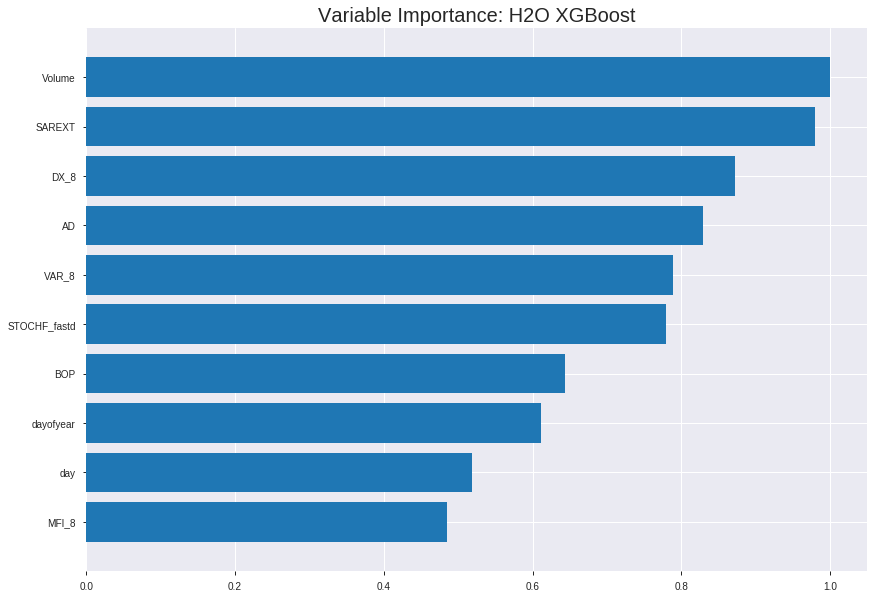

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_032440_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1959326007340746
RMSE: 0.44264274616678695
LogLoss: 0.582171352044111
Mean Per-Class Error: 0.19997007715818493
AUC: 0.8806053949897326
pr_auc: 0.8814919748367889
Gini: 0.7612107899794651
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48868195712566376: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      552  215  0.2803   (215.0/767.0)
1      100  693  0.1261   (100.0/793.0)
Total  652  908  0.2019   (315.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488682     0.814815  220
max f2                       0.449078     0.882696  263
max f0point5                 0.534626     0.810164  167
max accuracy                 0.511755     0.8       195
max precision                0.767505     1         0
max recall                   0.279959     1         388
max specificity              0.767505     1         0
max absolute_mcc             0.488682     0.601658  220
max min_per_class_accuracy   0.511755     0.798235  195
max mean_per_class_accuracy  0.511755     0.80003   195

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.716731           1.96721    1.96721            1                0.733542  1                           0.733542            0.0201765       0.0201765                  96.7213   96.7213
    2        0.0205128                   0.6978             1.96721    1.96721            1                0.70584   1                           0.719691            0.0201765       0.0403531                  96.7213   96.7213
    3        0.0301282                   0.687191           1.96721    1.96721            1                0.693588  1                           0.71136             0.0189155       0.0592686                  96.7213   96.7213
    4        0.0403846                   0.676222           1.96721    1.96721            1                0.681924  1                           0.703884            0.0201765       0.0794451                  96.7213   96.7213
    5        0.05                        0.669166           1.83607    1.94199            0.933333         0.671947  0.987179                    0.697743            0.0176545       0.0970996                  83.6066   94.1992
    6        0.1                         0.635318           1.84111    1.89155            0.935897         0.650667  0.961538                    0.674205            0.0920555       0.189155                   84.111    89.1551
    7        0.15                        0.612982           1.86633    1.88314            0.948718         0.624247  0.957265                    0.657552            0.0933165       0.282472                   86.633    88.3144
    8        0.2                         0.591859           1.81589    1.86633            0.923077         0.60275   0.948718                    0.643852            0.0907945       0.373266                   81.5889   86.633
    9        0.3                         0.563038           1.62673    1.78646            0.826923         0.576633  0.90812                     0.621445            0.162673        0.535939                   62.6734   78.6465
    10       0.4                         0.535861           1.3367     1.67402            0.679487         0.548989  0.850962                    0.603331            0.13367         0.669609                   33.6696   67.4023
    11       0.5                         0.511953           1.23581    1.58638            0.628205         0.524233  0.80641                     0.587512            0.123581        0.79319                    23.5813   58.6381
    12       0.6                         0.484515           0.895334   1.47121            0.455128         0.498785  0.747863                    0.572724            0.0895334       0.882724                   -10.4666  47.1206
    13       0.7                         0.455413           0.630517   1.35111            0.320513         0.47133   0.686813                    0.558239            0.0630517       0.945776                   -36.9483  35.1108
    14       0.8                         0.414581           0.290038   1.21847            0.147436         0.435727  0.619391                    0.542925            0.0290038       0.974779                   -70.9962  21.8474
    15       0.9                         0.368405           0.201765   1.10551            0.102564         0.393106  0.561966                    0.526279            0.0201765       0.994956                   -79.8235  10.5507
    16       1                           0.20886            0.0504414  1                  0.025641         0.329616  0.508333                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2616940876026292
RMSE: 0.511560443743092
LogLoss: 0.7170238761692653
Mean Per-Class Error: 0.48717406624383364
AUC: 0.4599013389711064
pr_auc: 0.4529935755362908
Gini: -0.08019732205778718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367404341697693: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    224  0.9697   (224.0/231.0)
1      1    214  0.0047   (1.0/215.0)
Total  8    438  0.5045   (225.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33674      0.655436  391
max f2                       0.306814     0.825653  395
max f0point5                 0.33674      0.543976  391
max accuracy                 0.677477     0.526906  7
max precision                0.735761     1         0
max recall                   0.306814     1         395
max specificity              0.735761     1         0
max absolute_mcc             0.563292     0.115879  99
max min_per_class_accuracy   0.511369     0.480519  199
max mean_per_class_accuracy  0.33674      0.512826  391

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.701709           1.24465   1.24465            0.6              0.714849  0.6                         0.714849            0.0139535       0.0139535                  24.4651    24.4651
    2        0.0201794                   0.673543           1.55581   1.38295            0.75             0.685991  0.666667                    0.702023            0.0139535       0.027907                   55.5814    38.2946
    3        0.0313901                   0.653302           0.414884  1.03721            0.2              0.662778  0.5                         0.688007            0.00465116      0.0325581                  -58.5116   3.72093
    4        0.0403587                   0.646667           0.518605  0.921964           0.25             0.650122  0.444444                    0.679588            0.00465116      0.0372093                  -48.1395   -7.80362
    5        0.0515695                   0.633612           0.414884  0.811729           0.2              0.64058   0.391304                    0.671108            0.00465116      0.0418605                  -58.5116   -18.8271
    6        0.100897                    0.613868           0.848626  0.829767           0.409091         0.621027  0.4                         0.646624            0.0418605       0.0837209                  -15.1374   -17.0233
    7        0.150224                    0.591347           1.03721   0.897883           0.5              0.601693  0.432836                    0.631871            0.0511628       0.134884                   3.72093    -10.2117
    8        0.201794                    0.574739           0.631345  0.829767           0.304348         0.582132  0.4                         0.61916             0.0325581       0.167442                   -36.8655   -17.0233
    9        0.300448                    0.548839           0.990063  0.882402           0.477273         0.560762  0.425373                    0.599984            0.0976744       0.265116                   -0.993658  -11.7598
    10       0.401345                    0.530884           1.10636   0.938703           0.533333         0.539938  0.452514                    0.584889            0.111628        0.376744                   10.6357    -6.12966
    11       0.5                         0.511598           1.03721   0.95814            0.5              0.520964  0.461883                    0.572276            0.102326        0.47907                    3.72093    -4.18605
    12       0.600897                    0.49257            1.01416   0.967546           0.488889         0.501606  0.466418                    0.56041             0.102326        0.581395                   1.41602    -3.2454
    13       0.699552                    0.468              0.990063  0.970722           0.477273         0.478029  0.467949                    0.548792            0.0976744       0.67907                    -0.993658  -2.92785
    14       0.800448                    0.438571           0.921964  0.964576           0.444444         0.455444  0.464986                    0.537025            0.0930233       0.772093                   -7.80362   -3.54244
    15       0.899103                    0.400498           1.08436   0.977718           0.522727         0.419054  0.471322                    0.524081            0.106977        0.87907                    8.43552    -2.22815
    16       1                           0.246632           1.19855   1                  0.577778         0.36164   0.482063         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:24:46  1.628 sec   0                  0.5              0.693147            0.5             0                  1                0.491667                         0.5                0.693147              0.5               0                    1                  0.517937
    2019-09-03 03:24:46  1.733 sec   5                  0.492126         0.677495            0.722937        0.713826           1.96721          0.339744                         0.500526           0.694198              0.471952          0.480728             1.38295            0.506726
    2019-09-03 03:24:46  1.806 sec   10                 0.485659         0.664751            0.756218        0.755398           1.96721          0.339103                         0.500881           0.694913              0.491181          0.48209              1.65953            0.517937
    2019-09-03 03:24:46  1.875 sec   15                 0.479403         0.652503            0.785923        0.787652           1.84426          0.305769                         0.503637           0.700497              0.461532          0.451385             0.829767           0.517937
    2019-09-03 03:24:47  1.946 sec   20                 0.472315         0.638754            0.815865        0.814713           1.84426          0.28141                          0.503621           0.700462              0.469586          0.46234              1.24465            0.506726
    2019-09-03 03:24:47  2.013 sec   25                 0.467558         0.629573            0.828591        0.826771           1.96721          0.257692                         0.504812           0.702891              0.466949          0.454077             0.829767           0.511211
    2019-09-03 03:24:47  2.088 sec   30                 0.461214         0.617368            0.841193        0.839715           1.96721          0.253846                         0.505796           0.704905              0.467804          0.455274             1.24465            0.506726
    2019-09-03 03:24:47  2.159 sec   35                 0.457483         0.610134            0.844414        0.844061           1.96721          0.246795                         0.506764           0.706936              0.466002          0.456847             1.24465            0.511211
    2019-09-03 03:24:47  2.232 sec   40                 0.451949         0.599662            0.860809        0.862204           1.96721          0.225                            0.508527           0.710638              0.462328          0.457899             1.24465            0.504484
    2019-09-03 03:24:47  2.308 sec   45                 0.447069         0.590487            0.873093        0.872494           1.96721          0.207692                         0.509317           0.712282              0.464814          0.459799             1.24465            0.502242
    2019-09-03 03:24:47  2.389 sec   50                 0.442643         0.582171            0.880605        0.881492           1.96721          0.201923                         0.51156            0.717024              0.459901          0.452994             1.24465            0.504484

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
Volume             382.2817687988281      1.0                   0.09846561504625653
SAREXT             374.22674560546875     0.9789290940588949    0.0963908553331838
DX_8               333.30322265625        0.8718784149804628    0.08585004437660655
AD                 316.8606872558594      0.8288668545493837    0.08161488462466111
VAR_8              301.49200439453125     0.7886643544154687    0.07765632072257797
---                ---                    ---                   ---
days_in_month      16.208114624023438     0.0423983457933428    0.004174779195485361
is_month_end       9.68637466430664       0.025338311828843704  0.0024949524584609323
CDLLONGLEGGEDDOJI  7.649867057800293      0.020011069536057205  0.00197040226960128
CDLTAKURI          5.758738994598389      0.01506412145337976   0.001483297984038546
is_month_start     3.0339455604553223     0.007936411851363765  0.0007814636742049326


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6384364820846905)

('auc', 0.6026699029126213)

('logloss', 0.7152758579525479)

('mean_per_class_error', 0.40384304207119737)

('rmse', 0.5100518502327224)

('mse', 0.2601528899258234)

xgboost prediction progress: |████████████████████████████████████████████| 100%


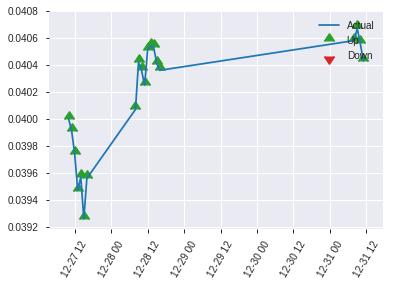


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2601528899258234
RMSE: 0.5100518502327224
LogLoss: 0.7152758579525479
Mean Per-Class Error: 0.40384304207119737
AUC: 0.6026699029126213
pr_auc: 0.530225349711638
Gini: 0.2053398058252427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46702444553375244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   106  0.8833   (106.0/120.0)
1      5    98   0.0485   (5.0/103.0)
Total  19   204  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467024     0.638436  203
max f2                       0.394495     0.812303  221
max f0point5                 0.620093     0.564682  95
max accuracy                 0.620093     0.600897  95
max precision                0.68127      0.645161  30
max recall                   0.394495     1         221
max specificity              0.790199     0.991667  0
max absolute_mcc             0.620093     0.193634  95
max min_per_class_accuracy   0.610902     0.591667  109
max mean_per_class_accuracy  0.620093     0.596157  95

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 59.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.758335           0.721683  0.721683           0.333333         0.775445  0.333333                    0.775445            0.00970874      0.00970874                 -27.8317  -27.8317
    2        0.0224215                   0.742304           1.08252   0.866019           0.5              0.749341  0.4                         0.765003            0.00970874      0.0194175                  8.25243   -13.3981
    3        0.0313901                   0.734866           1.08252   0.927878           0.5              0.736445  0.428571                    0.756843            0.00970874      0.0291262                  8.25243   -7.21221
    4        0.0403587                   0.732471           2.16505   1.2028             1                0.73404   0.555556                    0.751776            0.0194175       0.0485437                  116.505   20.2805
    5        0.0538117                   0.728758           1.44337   1.26294            0.666667         0.730965  0.583333                    0.746573            0.0194175       0.0679612                  44.3366   26.2945
    6        0.103139                    0.700679           1.18094   1.22372            0.545455         0.709359  0.565217                    0.728775            0.0582524       0.126214                   18.0936   22.3723
    7        0.152466                    0.679468           1.37776   1.27356            0.636364         0.68777   0.588235                    0.715509            0.0679612       0.194175                   37.7758   27.3558
    8        0.201794                    0.671201           1.18094   1.25092            0.545455         0.675139  0.577778                    0.705641            0.0582524       0.252427                   18.0936   25.0917
    9        0.300448                    0.648454           1.27935   1.26025            0.590909         0.659793  0.58209                     0.690586            0.126214        0.378641                   27.9347   26.0252
    10       0.399103                    0.624366           0.984113  1.19199            0.454545         0.636431  0.550562                    0.6772              0.0970874       0.475728                   -1.5887   19.1993
    11       0.502242                    0.608906           1.22372   1.19851            0.565217         0.617052  0.553571                    0.664848            0.126214        0.601942                   22.3723   19.8509
    12       0.600897                    0.591508           0.78729   1.131              0.363636         0.599994  0.522388                    0.6542              0.0776699       0.679612                   -21.271   13.0996
    13       0.699552                    0.567313           0.984113  1.11028            0.454545         0.579032  0.512821                    0.6436              0.0970874       0.776699                   -1.5887   11.0281
    14       0.798206                    0.526216           0.78729   1.07036            0.363636         0.547565  0.494382                    0.63173             0.0776699       0.854369                   -21.271   7.03611
    15       0.896861                    0.474195           0.78729   1.03922            0.363636         0.503033  0.48                        0.617573            0.0776699       0.932039                   -21.271   3.92233
    16       1                           0.369769           0.658928  1                  0.304348         0.438183  0.461883                    0.599071      

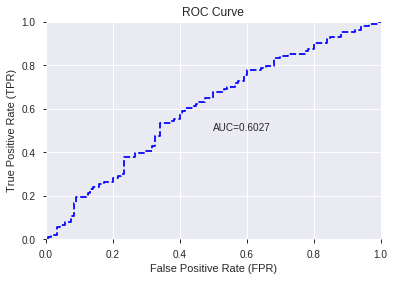

This function is available for GLM models only


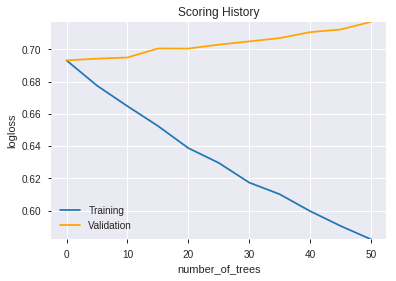

--2019-09-03 03:25:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_032440_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_032440_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'SAREXT',
 'DX_8',
 'AD',
 'VAR_8',
 'STOCHF_fastd',
 'BOP',
 'dayofyear',
 'day',
 'MFI_8',
 'aroonup_30',
 'aroonup_14',
 'aroondown_14',
 'STOCHRSI_fastk',
 'hour',
 'aroondown_12',
 'weekday_name',
 'week',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'days_in_month',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'CDLTAKURI',
 'is_month_start']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 906] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_032508_model_1  0.615534  2.229039              0.465251  0.605760  0.366945
1  DeepLearning_grid_1_AutoML_20190903_032508_model_3  0.558657  1.541492              0.495833  0.663621  0.440393
2  DeepLearning_grid_1_AutoML_20190903_032508_model_4  0.551416  3.913511              0.495833  0.717934  0.515429
3  DeepLearning_grid_1_AutoML_20190903_032508_model_7  0.546602  0.692237              0.452023  0.499548  0.249548
4  DeepLearning_grid_1_AutoML_20190903_032508_model_2  0.522735  0.744919              0.480542  0.519652  0.270039
5  DeepLearning_grid_1_AutoML_20190903_032508_model_9  0.513916  0.691048              0.495833  0.498950  0.248951
6  DeepLearning_grid_1_AutoML_20190903_032508_model_6  0.501133  0.690373              0.500000  0.498612  0.248614
7  DeepLearning_grid_1_AutoML_20190903_032508_model_8  0.500000  0.691058              0.500000  0.498955  0.248956
8               DeepLearning_1_AutoML_20190903_032508  0.500000  0.698102              0.500000  0.502469  0.252475
9  DeepLearning_grid_1_AutoML_20190903_032508_model_5  0.500000  0.690260              0.500000  0.498556  0.248558

variable  relative_importance  scaled_importance  percentage
0                CDLHANGINGMAN             1.000000           1.000000    0.001196
1            CDLSTALLEDPATTERN             0.952245           0.952245    0.001139
2            CDLGRAVESTONEDOJI             0.940942           0.940942    0.001125
3                          BOP             0.934034           0.934034    0.001117
4                         hour             0.933057           0.933057    0.001116
...                        ...                  ...                ...         ...
1022                     TSF_8             0.753034           0.753034    0.000901
1023                 PLUS_DI_8             0.752373           0.752373    0.000900
1024   BBANDS_middleband_8_8_2             0.750645           0.750645    0.000898
1025  BBANDS_middleband_14_0_4             0.746729           0.746729    0.000893
1026   BBANDS_lowerband_12_2_2             0.745643           0.745643    0.000892

[1027 rows x 4 columns]

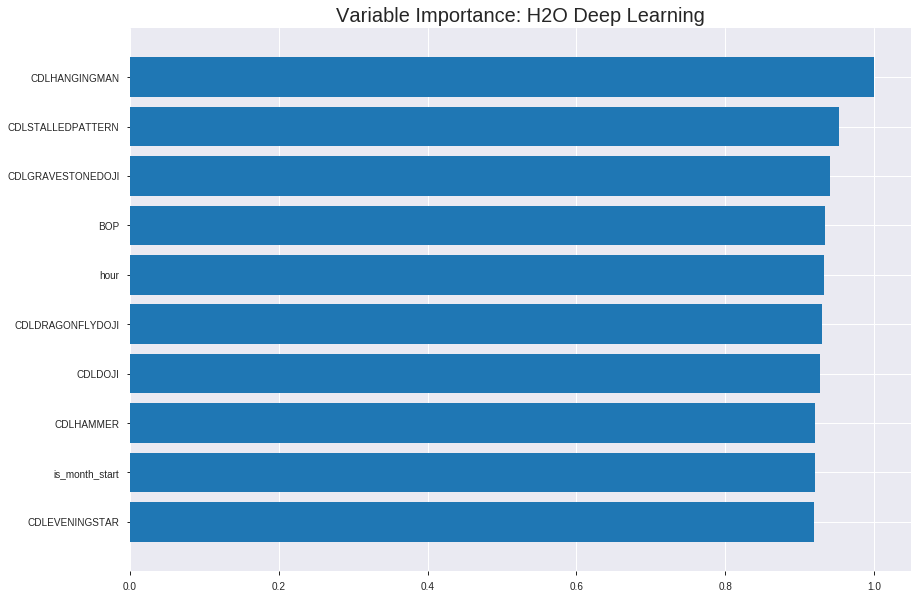

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_032508_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.29560502548601364
RMSE: 0.5436957103803686
LogLoss: 1.2823214520608628
Mean Per-Class Error: 0.3620129523158142
AUC: 0.6787306138621675
pr_auc: 0.6027648890191054
Gini: 0.357461227724335
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.017358212129405987: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      211  556   0.7249   (556.0/767.0)
1      81   712   0.1021   (81.0/793.0)
Total  292  1268  0.4083   (637.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0173582    0.690927  381
max f2                       0.000482379  0.837977  398
max f0point5                 0.8012       0.645609  107
max accuracy                 0.75215      0.636538  123
max precision                0.994526     0.741784  8
max recall                   5.37059e-05  1         399
max specificity              0.999873     0.971317  0
max absolute_mcc             0.879368     0.284936  77
max min_per_class_accuracy   0.5297       0.628422  194
max mean_per_class_accuracy  0.75215      0.637987  123

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 51.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.999995           1.72131   1.72131            0.875            0.999998     0.875                       0.999998            0.0176545       0.0176545                  72.1311   72.1311
    2        0.0205128                   0.999957           1.72131   1.72131            0.875            0.999982     0.875                       0.99999             0.0176545       0.035309                   72.1311   72.1311
    3        0.0301282                   0.999883           1.31148   1.59051            0.666667         0.999918     0.808511                    0.999967            0.0126103       0.0479193                  31.1475   59.0513
    4        0.0403846                   0.999763           1.59836   1.59251            0.8125           0.999825     0.809524                    0.999931            0.0163934       0.0643127                  59.8361   59.2506
    5        0.05                        0.999683           1.04918   1.48802            0.533333         0.999725     0.75641                     0.999891            0.0100883       0.074401                   4.91803   48.802
    6        0.1                         0.998156           1.3367    1.41236            0.679487         0.99913      0.717949                    0.999511            0.0668348       0.141236                   33.6696   41.2358
    7        0.15                        0.991906           1.4628    1.42917            0.74359          0.995587     0.726496                    0.998203            0.07314         0.214376                   46.2799   42.9172
    8        0.2                         0.982453           1.31148   1.39975            0.666667         0.986814     0.711538                    0.995356            0.0655738       0.27995                    31.1475   39.9748
    9        0.3                         0.930777           1.36192   1.38714            0.692308         0.963998     0.705128                    0.984903            0.136192        0.416141                   36.1917   38.7137
    10       0.4                         0.781358           1.17276   1.33354            0.596154         0.86459      0.677885                    0.954825            0.117276        0.533417                   17.2762   33.3544
    11       0.5                         0.543701           0.920555  1.25095            0.467949         0.671483     0.635897                    0.898156            0.0920555       0.625473                   -7.94451  25.0946
    12       0.6                         0.284869           1.02144   1.21269            0.519231         0.413281     0.616453                    0.817344            0.102144        0.727617                   2.14376   21.2694
    13       0.7                         0.0999722          0.819672  1.15655            0.416667         0.18037      0.587912                    0.726348            0.0819672       0.809584                   -18.0328  15.6548
    14       0.8                         0.0226005          0.7314    1.1034             0.371795         0.0550555    0.560897                    0.642436            0.07314         0.882724                   -26.86    10.3405
    15       0.9                         0.00285257         0.693569  1.05787            0.352564         0.00969411   0.537749                    0.572131            0.0693569       0.952081                   -30.6431  5.78675
    16       1                           3.48226e-10        0.479193  1                  0.24359          0.000



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3924282368881066
RMSE: 0.6264409284905533
LogLoss: 2.0769338633117282
Mean Per-Class Error: 0.4327091513138025
AUC: 0.5624282694050136
pr_auc: 0.5235076606199651
Gini: 0.12485653881002712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.310204906877964e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   217  0.9394   (217.0/231.0)
1      1    214  0.0047   (1.0/215.0)
Total  15   431  0.4888   (218.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       5.3102e-06   0.662539  397
max f2                       5.3102e-06   0.828815  397
max f0point5                 0.0263394    0.561417  271
max accuracy                 0.0263394    0.56278   271
max precision                0.999975     0.888889  3
max recall                   3.58646e-07  1         399
max specificity              1            0.995671  0
max absolute_mcc             5.3102e-06   0.155088  397
max min_per_class_accuracy   0.110709     0.55814   215
max mean_per_class_accuracy  0.0263394    0.567291  271

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 33.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.999996           1.65953   1.65953            0.8              1            0.8                         1                   0.0186047       0.0186047                  65.9535   65.9535
    2        0.0201794                   0.999967           2.07442   1.84393            1                0.999983     0.888889                    0.999992            0.0186047       0.0372093                  107.442   84.3928
    3        0.0313901                   0.999736           0.829767  1.48173            0.4              0.999836     0.714286                    0.999937            0.00930233      0.0465116                  -17.0233  48.1728
    4        0.0403587                   0.99909            0.518605  1.2677             0.25             0.999373     0.611111                    0.999811            0.00465116      0.0511628                  -48.1395  26.77
    5        0.0515695                   0.998879           1.24465   1.26269            0.6              0.998997     0.608696                    0.999634            0.0139535       0.0651163                  24.4651   26.269
    6        0.100897                    0.988831           0.848626  1.06026            0.409091         0.996656     0.511111                    0.998178            0.0418605       0.106977                   -15.1374  6.02584
    7        0.150224                    0.964552           1.22579   1.11461            0.590909         0.976289     0.537313                    0.990991            0.0604651       0.167442                   22.5793   11.4613
    8        0.201794                    0.854056           1.1725    1.12941            0.565217         0.926422     0.544444                    0.97449             0.0604651       0.227907                   17.2497   12.9406
    9        0.300448                    0.573113           1.03721   1.09913            0.5              0.728417     0.529851                    0.89369             0.102326        0.330233                   3.72093   9.91322
    10       0.401345                    0.250547           1.01416   1.07777            0.488889         0.409495     0.519553                    0.771965            0.102326        0.432558                   1.41602   7.77706
    11       0.5                         0.108485           1.27294   1.11628            0.613636         0.168656     0.538117                    0.652926            0.125581        0.55814                    27.2939   11.6279
    12       0.600897                    0.0347794          0.921964  1.08365            0.444444         0.0675606    0.522388                    0.554637            0.0930233       0.651163                   -7.80362  8.36515
    13       0.699552                    0.00708962         1.03721   1.0771             0.5              0.0184653    0.519231                    0.479023            0.102326        0.753488                   3.72093   7.7102
    14       0.800448                    0.001483           0.691473  1.02849            0.333333         0.00349825   0.495798                    0.419083            0.0697674       0.823256                   -30.8527  2.84933
    15       0.899103                    7.46022e-05        1.03721   1.02945            0.5              0.000524781  0.496259                    0.373157            0.102326        0.925581                   3.72093   2.94496
    16       1                           2.96436e-11        0.737571  1                  0.355556         2.05991e


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:25:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:25:14  4.931 sec         215 obs/sec       0.489103  1             763        0.686201         8.02155             -0.884011      0.528733        0.342515           1.31148          0.491667                         0.676741           7.10906               -0.834272        0.533927          0.316322             1.10636            0.517937
    2019-09-03 03:25:24  15.111 sec        232 obs/sec       1.91795   4             2992       0.646928         4.63438             -0.674529      0.548583        0.357436           0.737705         0.473077                         0.67744            3.99599               -0.838068        0.50006           0.45382              1.65953            0.515695
    2019-09-03 03:25:34  25.161 sec        237 obs/sec       3.36731   7             5253       0.626252         2.98992             -0.569203      0.593855        0.450678           1.47541          0.491667                         0.665248           3.82931               -0.772501        0.52532           0.474004             1.65953            0.5
    2019-09-03 03:25:45  35.405 sec        241 obs/sec       4.86795   10            7594       0.666348         7.06965             -0.77657       0.560891        0.347801           1.47541          0.491667                         0.693299           6.49311               -0.925129        0.532367          0.339865             0.777907           0.506726
    2019-09-03 03:25:55  45.355 sec        243 obs/sec       6.34679   13            9901       0.6375           3.96481             -0.626074      0.593631        0.470617           1.35246          0.491667                         0.638545           3.24704               -0.63306         0.556599          0.503587             1.65953            0.517937
    2019-09-03 03:26:05  55.582 sec        244 obs/sec       7.85321   16            12251      0.61326          3.15224             -0.504769      0.60708         0.387539           1.72131          0.455769                         0.66039            3.32611               -0.746706        0.541478          0.4722               1.65953            0.508969
    2019-09-03 03:26:15  1 min  5.506 sec  245 obs/sec       9.31474   19            14531      0.543696         1.28232             -0.182749      0.678731        0.602765           1.72131          0.408333                         0.626441           2.07693               -0.571736        0.562428          0.523508             1.65953            0.488789
    2019-09-03 03:26:25  1 min 15.538 sec  246 obs/sec       10.7897   22            16832      0.621147         3.66531             -0.543723      0.60164         0.432992           1.35246          0.491667                         0.657087           3.17481               -0.729278        0.542364          0.49869              1.24465            0.504484
    2019-09-03 03:26:35  1 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLHANGINGMAN             1.0                    1.0                  0.0011960410703059376
CDLSTALLEDPATTERN         0.9522453546524048     0.9522453546524048   0.0011389245531723193
CDLGRAVESTONEDOJI         0.9409416913986206     0.9409416913986206   0.0011254049076758854
BOP                       0.9340342879295349     0.9340342879295349   0.0011171433694376852
hour                      0.9330574870109558     0.9330574870109558   0.001115975075421552
---                       ---                    ---                  ---
TSF_8                     0.7530341744422913     0.7530341744422913   0.0009006597999769062
PLUS_DI_8                 0.752372682094574      0.752372682094574    0.0008998686279613433
BBANDS_middleband_8_8_2   0.7506445646286011     0.7506445646286011   0.0008978017284977266
BBANDS_middleband_14_0_4  0.7467292547225952     0.7467292547225952   0.000893118857047168
BBANDS_lowerband_12_2_2   0.7456434369087219     0.7456434369087219   0.0008918201743469056


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6278026905829597)

('F1', 0.6407766990291262)

('auc', 0.6155339805825243)

('logloss', 2.22903863267081)

('mean_per_class_error', 0.38847087378640777)

('rmse', 0.6057595669059922)

('mse', 0.36694465289813527)

deeplearning prediction progress: |███████████████████████████████████████| 100%


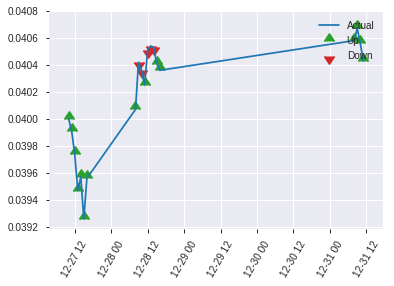


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.36694465289813527
RMSE: 0.6057595669059922
LogLoss: 2.22903863267081
Mean Per-Class Error: 0.38847087378640777
AUC: 0.6155339805825243
pr_auc: 0.5928962762042361
Gini: 0.23106796116504857
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.3557457343815e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   107  0.8917   (107.0/120.0)
1      4    99   0.0388   (4.0/103.0)
Total  17   206  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.35575e-06  0.640777  205
max f2                       2.22665e-08  0.813586  220
max f0point5                 0.981719     0.584046  61
max accuracy                 0.981719     0.627803  61
max precision                1            1         0
max recall                   2.22665e-08  1         220
max specificity              1            1         0
max absolute_mcc             0.981719     0.24821   61
max min_per_class_accuracy   0.471978     0.575     110
max mean_per_class_accuracy  0.981719     0.611529  61

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   1                  1.44337   1.44337            0.666667         1            0.666667                    1                   0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.999998           2.16505   1.73204            1                0.999999     0.8                         1                   0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.999992           2.16505   1.85576            1                0.999995     0.857143                    0.999998            0.0194175       0.0582524                  116.505   85.5756
    4        0.0403587                   0.999968           1.08252   1.68393            0.5              0.999985     0.777778                    0.999995            0.00970874      0.0679612                  8.25243   68.3927
    5        0.0538117                   0.999945           1.44337   1.62379            0.666667         0.999957     0.75                        0.999986            0.0194175       0.0873786                  44.3366   62.3786
    6        0.103139                    0.999588           1.7714    1.69439            0.818182         0.99978      0.782609                    0.999888            0.0873786       0.174757                   77.1403   69.4386
    7        0.152466                    0.998057           0.984113  1.46459            0.454545         0.998947     0.676471                    0.999583            0.0485437       0.223301                   -1.5887   46.4592
    8        0.201794                    0.994332           1.57458   1.49148            0.727273         0.996768     0.688889                    0.998895            0.0776699       0.300971                   57.4581   49.1478
    9        0.300448                    0.962808           1.08252   1.35719            0.5              0.985354     0.626866                    0.994449            0.106796        0.407767                   8.25243   35.7195
    10       0.399103                    0.823522           0.885702  1.24065            0.409091         0.898654     0.573034                    0.970769            0.0873786       0.495146                   -11.4298  24.0646
    11       0.502242                    0.431878           0.941325  1.17918            0.434783         0.631621     0.544643                    0.901123            0.0970874       0.592233                   -5.86745  17.9178
    12       0.600897                    0.108178           0.590468  1.08252            0.272727         0.246044     0.5                         0.793572            0.0582524       0.650485                   -40.9532  8.25243
    13       0.699552                    0.00915748         0.78729   1.04089            0.363636         0.0313864    0.480769                    0.686085            0.0776699       0.728155                   -21.271   4.08887
    14       0.798206                    0.00114847         1.27935   1.07036            0.590909         0.0041694    0.494382                    0.601803            0.126214        0.854369                   27.9347   7.03611
    15       0.896861                    2.31093e-05        0.78729   1.03922            0.363636         0.000340697  0.48                        0.535642            0.0776699       0.932039                   -21.271   3.92233
    16       1                           1.61441e-11        0.658928  1                  0.304348         4.66

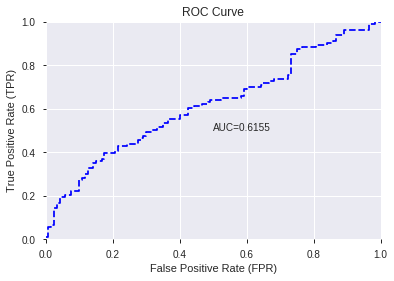

This function is available for GLM models only


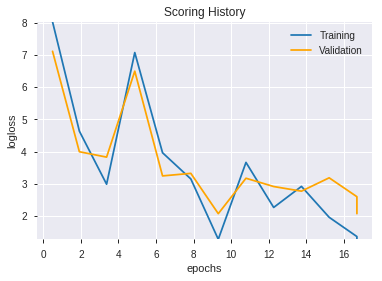

--2019-09-03 03:51:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.83.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.83.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_032508_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_032508_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'CDLGRAVESTONEDOJI',
 'BOP',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDLDOJI',
 'CDLHAMMER',
 'is_month_start',
 'CDLEVENINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLINNECK',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'BBANDS_upperband_30_2_3',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'BBANDS_middleband_12_3_4',
 'CDLADVANCEBLOCK',
 'STOCHRSI_fastd',
 'BBANDS_upperband_20_5_4',
 'month',
 'MFI_20',
 'CDLPIERCING',
 'BETA_8',
 'BBANDS_upperband_8_7_5',
 'HT_PHASOR_quadrature',
 'STOCHF_fastd',
 'BBANDS_upperband_24_6_2',
 'aroonup_14',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'BBANDS_upperband_8_0_2',
 'STOCHRSI_fastk',
 'MINUS_DM_30',
 'aroonup_12',
 'CDLXSIDEGAP3METHODS',
 'BBANDS_middleband_8_3_5',
 'STOCHF_fastk',
 'BBANDS_lowerband_20_6_5',
 'MINMAX_max_20',
 'CDLMORNINGSTAR',
 'CDLHARAMICROSS',
 'BBANDS_upperband_12_2_5',
 'CDLSEPARATINGLINES',
 'BBANDS_upperband_24_5_4',
 'BBANDS_upperband_12_3_3',
 'MIN

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_035125_model_1  0.54021  0.738401                   0.5  0.521251  0.271702

variable  relative_importance  scaled_importance    percentage
0                 CDLBELTHOLD         1.909210e-02           1.000000  1.204782e-02
1                          AD         1.840039e-02           0.963770  1.161132e-02
2                        DX_8         1.651449e-02           0.864991  1.042125e-02
3             CDLHOMINGPIGEON         1.566827e-02           0.820667  9.887251e-03
4              is_month_start         1.565890e-02           0.820177  9.881339e-03
...                       ...                  ...                ...           ...
1022                      TAN         5.322631e-06           0.000279  3.358775e-06
1023                     TANH         4.902236e-06           0.000257  3.093490e-06
1024  BBANDS_lowerband_14_4_2         3.796541e-06           0.000199  2.395756e-06
1025  BBANDS_lowerband_14_1_2         8.480059e-07           0.000044  5.351228e-07
1026                  KAMA_30         4.453877e-07           0.000023  2.810560e-07

[1027 rows x 4 columns]

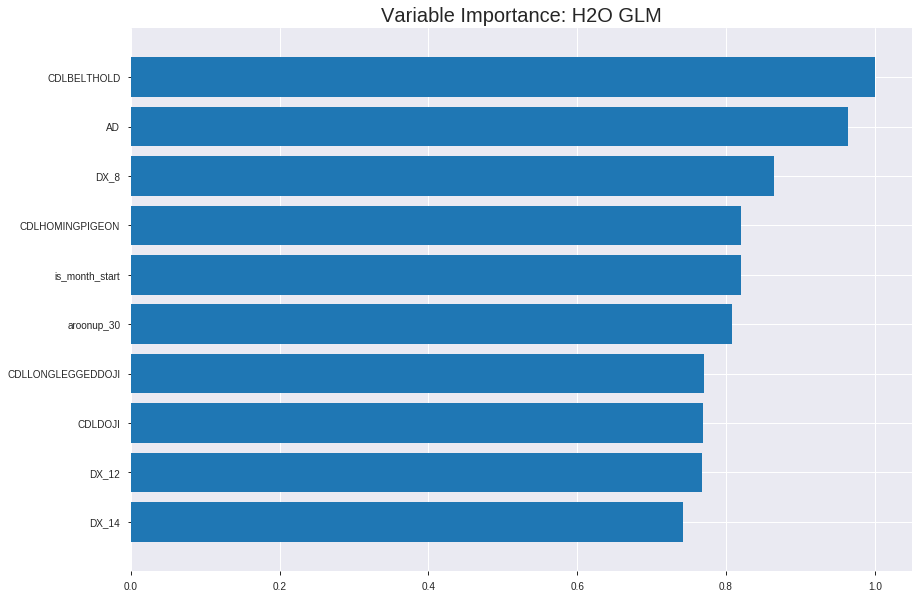

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_035125_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2432546318971072
RMSE: 0.4932085075270977
LogLoss: 0.6795536852465536
Null degrees of freedom: 1559
Residual degrees of freedom: 532
Null deviance: 2162.1858499497453
Residual deviance: 2120.207497969247
AIC: 4176.207497969247
AUC: 0.6136122624463403
pr_auc: 0.6166776198593988
Gini: 0.22722452489268052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4287280277563701: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      40   727   0.9478   (727.0/767.0)
1      10   783   0.0126   (10.0/793.0)
Total  50   1510  0.4724   (737.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428728     0.679983  363
max f2                       0.405963     0.839161  388
max f0point5                 0.479731     0.592833  269
max accuracy                 0.508876     0.577564  189
max precision                0.646665     1         0
max recall                   0.401233     1         392
max specificity              0.646665     1         0
max absolute_mcc             0.545494     0.18995   86
max min_per_class_accuracy   0.511675     0.57236   182
max mean_per_class_accuracy  0.526944     0.579189  136

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.593142           1.59836   1.59836            0.8125           0.611065  0.8125                      0.611065            0.0163934       0.0163934                  59.8361   59.8361
    2        0.0205128                   0.58519            1.47541   1.53689            0.75             0.588809  0.78125                     0.599937            0.0151324       0.0315259                  47.541    53.6885
    3        0.0301282                   0.576943           1.18033   1.42309            0.6              0.581185  0.723404                    0.593953            0.0113493       0.0428752                  18.0328   42.309
    4        0.0403846                   0.57171            1.47541   1.43638            0.75             0.574765  0.730159                    0.58908             0.0151324       0.0580076                  47.541    43.6378
    5        0.05                        0.568854           1.04918   1.36192            0.533333         0.570596  0.692308                    0.585525            0.0100883       0.0680958                  4.91803   36.1917
    6        0.1                         0.554889           1.31148   1.3367             0.666667         0.561466  0.679487                    0.573496            0.0655738       0.13367                    31.1475   33.6696
    7        0.15                        0.54671            1.56368   1.41236            0.794872         0.550533  0.717949                    0.565842            0.0781841       0.211854                   56.3682   41.2358
    8        0.2                         0.540362           1.10971   1.3367             0.564103         0.543792  0.679487                    0.560329            0.0554855       0.267339                   10.971    33.6696
    9        0.3                         0.529818           1.08449   1.25263            0.551282         0.535232  0.636752                    0.551964            0.108449        0.375788                   8.44893   25.2627
    10       0.4                         0.51964            0.933165  1.17276            0.474359         0.52481   0.596154                    0.545175            0.0933165       0.469105                   -6.68348  17.2762
    11       0.5                         0.511712           1.02144   1.1425             0.519231         0.515436  0.580769                    0.539227            0.102144        0.571248                   2.14376   14.2497
    12       0.6                         0.502739           0.958386  1.11181            0.487179         0.506896  0.565171                    0.533839            0.0958386       0.667087                   -4.16141  11.1812
    13       0.7                         0.491413           0.920555  1.08449            0.467949         0.497266  0.551282                    0.528614            0.0920555       0.759142                   -7.94451  8.44893
    14       0.8                         0.477419           1.00883   1.07503            0.512821         0.484242  0.546474                    0.523068            0.100883        0.860025                   0.882724  7.50315
    15       0.9                         0.453618           0.74401   1.03825            0.378205         0.467325  0.527778                    0.516874            0.074401        0.934426                   -25.599   3.82514
    16       1                           0.346171           0.655738  1                  0.333333         0.431467  0.508333                    0.508333          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24883831613849672
RMSE: 0.49883696348456047
LogLoss: 0.6908601479597419
Null degrees of freedom: 445
Residual degrees of freedom: -582
Null deviance: 618.9445738826204
Residual deviance: 616.2472519800898
AIC: 2672.24725198009
AUC: 0.5517467029094936
pr_auc: 0.5031977867992642
Gini: 0.10349340581898714
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3958851524486335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    215  0        (0.0/215.0)
Total  2    444  0.5135   (229.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395885     0.652504  397
max f2                       0.395885     0.824387  397
max f0point5                 0.472136     0.560374  287
max accuracy                 0.493272     0.558296  229
max precision                0.648711     1         0
max recall                   0.395885     1         397
max specificity              0.648711     1         0
max absolute_mcc             0.472136     0.132457  287
max min_per_class_accuracy   0.499901     0.541126  202
max mean_per_class_accuracy  0.493272     0.561029  229

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.614886           0.829767  0.829767           0.4              0.63641   0.4                         0.63641             0.00930233      0.00930233                 -17.0233   -17.0233
    2        0.0201794                   0.600387           1.03721   0.921964           0.5              0.605415  0.444444                    0.622635            0.00930233      0.0186047                  3.72093    -7.80362
    3        0.0313901                   0.591392           0.829767  0.889037           0.4              0.595153  0.428571                    0.61282             0.00930233      0.027907                   -17.0233   -11.0963
    4        0.0403587                   0.579524           1.03721   0.921964           0.5              0.586903  0.444444                    0.607061            0.00930233      0.0372093                  3.72093    -7.80362
    5        0.0515695                   0.575889           0.414884  0.811729           0.2              0.577289  0.391304                    0.600588            0.00465116      0.0418605                  -58.5116   -18.8271
    6        0.100897                    0.55246            1.1315    0.968062           0.545455         0.562273  0.466667                    0.581856            0.055814        0.0976744                  13.1501    -3.1938
    7        0.150224                    0.543491           1.1315    1.02173            0.545455         0.54793   0.492537                    0.570716            0.055814        0.153488                   13.1501    2.17286
    8        0.201794                    0.537207           1.1725    1.06026            0.565217         0.540401  0.511111                    0.562969            0.0604651       0.213953                   17.2497    6.02584
    9        0.300448                    0.522682           1.08436   1.06817            0.522727         0.529943  0.514925                    0.552125            0.106977        0.32093                    8.43552    6.81708
    10       0.401345                    0.510599           1.19855   1.10095            0.577778         0.516513  0.530726                    0.543172            0.12093         0.44186                    19.8553    10.0948
    11       0.5                         0.499767           1.03721   1.08837            0.5              0.505292  0.524664                    0.535698            0.102326        0.544186                   3.72093    8.83721
    12       0.600897                    0.48891            1.06026   1.08365            0.511111         0.495239  0.522388                    0.528904            0.106977        0.651163                   6.02584    8.36515
    13       0.699552                    0.473886           0.990063  1.07045            0.477273         0.481794  0.516026                    0.522261            0.0976744       0.748837                   -0.993658  7.04532
    14       0.800448                    0.46329            0.968062  1.05755            0.466667         0.46842   0.509804                    0.515474            0.0976744       0.846512                   -3.1938    5.75467
    15       0.899103                    0.449045           0.612896  1.00876            0.295455         0.45583   0.486284                    0.508929            0.0604651       0.906977                   -38.7104   0.875718
    16       1                           0.359191           0.921964  1                  0.444444         0.428658  0.482063              


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:51:29  0.000 sec   2            2.9       1028          1.37106           1.38396
    2019-09-03 03:51:30  1.949 sec   4            2.1       1028          1.36762           1.38303
    2019-09-03 03:51:32  3.935 sec   6            1.6       1028          1.36365           1.3822
    2019-09-03 03:51:34  5.942 sec   8            1.1       1028          1.35911           1.38172
    2019-09-03 03:51:36  7.901 sec   10           0.83      1028          1.35404           1.38177
    2019-09-03 03:51:38  9.924 sec   12           0.6       1028          1.34852           1.38252
    2019-09-03 03:51:40  11.904 sec  14           0.44      1028          1.34263           1.38431
    2019-09-03 03:51:43  14.008 sec  16           0.32      1028          1.33647           1.38728
    2019-09-03 03:51:45  15.999 sec  18           0.23      1028          1.33013           1.39169

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6319018404907976)

('auc', 0.540210355987055)

('logloss', 0.738401461528794)

('mean_per_class_error', 0.4364886731391586)

('rmse', 0.5212508879246927)

('mse', 0.27170248816228054)

glm prediction progress: |████████████████████████████████████████████████| 100%


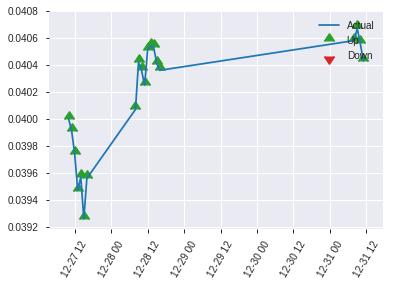


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.27170248816228054
RMSE: 0.5212508879246927
LogLoss: 0.738401461528794
Null degrees of freedom: 222
Residual degrees of freedom: -805
Null deviance: 309.7723147237181
Residual deviance: 329.32705184184215
AIC: 2385.327051841842
AUC: 0.540210355987055
pr_auc: 0.4826328487549679
Gini: 0.08042071197411005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42518185629127614: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    120  1        (120.0/120.0)
1      0    103  0        (0.0/103.0)
Total  0    223  0.5381   (120.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425182     0.631902  222
max f2                       0.425182     0.811024  222
max f0point5                 0.630386     0.531309  105
max accuracy                 0.630386     0.565022  105
max precision                0.726832     1         0
max recall                   0.425182     1         222
max specificity              0.726832     1         0
max absolute_mcc             0.630386     0.126807  105
max min_per_class_accuracy   0.629359     0.553398  109
max mean_per_class_accuracy  0.630386     0.563511  105

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 61.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.707518           1.44337   1.44337            0.666667         0.715253  0.666667                    0.715253            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.70372            1.08252   1.29903            0.5              0.705736  0.6                         0.711446            0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.698483           1.08252   1.23717            0.5              0.701308  0.571429                    0.70855             0.00970874      0.038835                   8.25243   23.7171
    4        0.0403587                   0.692783           0         0.962244           0                0.69593   0.444444                    0.705745            0               0.038835                   -100      -3.77562
    5        0.0538117                   0.691943           1.44337   1.08252            0.666667         0.692222  0.5                         0.702365            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.677323           0.78729   0.941325           0.363636         0.682753  0.434783                    0.692985            0.038835        0.0970874                  -21.271   -5.86745
    7        0.152466                    0.668477           1.18094   1.01885            0.545455         0.671879  0.470588                    0.686156            0.0582524       0.15534                    18.0936   1.88464
    8        0.201794                    0.665705           1.18094   1.05847            0.545455         0.667163  0.488889                    0.681514            0.0582524       0.213592                   18.0936   5.84682
    9        0.300448                    0.655088           1.18094   1.09868            0.545455         0.659877  0.507463                    0.674409            0.116505        0.330097                   18.0936   9.86814
    10       0.399103                    0.6436             1.08252   1.09469            0.5              0.649064  0.505618                    0.668144            0.106796        0.436893                   8.25243   9.46875
    11       0.502242                    0.628307           1.12959   1.10186            0.521739         0.633965  0.508929                    0.661125            0.116505        0.553398                   12.9591   10.1855
    12       0.600897                    0.595141           0.885702  1.06637            0.409091         0.611649  0.492537                    0.653002            0.0873786       0.640777                   -11.4298  6.63672
    13       0.699552                    0.583631           0.78729   1.02701            0.363636         0.588838  0.474359                    0.643953            0.0776699       0.718447                   -21.271   2.70102
    14       0.798206                    0.569438           1.08252   1.03387            0.5              0.577435  0.477528                    0.635732            0.106796        0.825243                   8.25243   3.38715
    15       0.896861                    0.540536           0.885702  1.01757            0.409091         0.55952   0.47                        0.627349            0.0873786       0.912621                   -11.4298  1.75728
    16       1                           0.425182           0.847193  1                  0.391304         0.503711  0.461883                    0.614597       

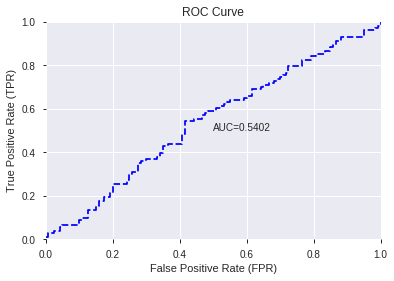

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


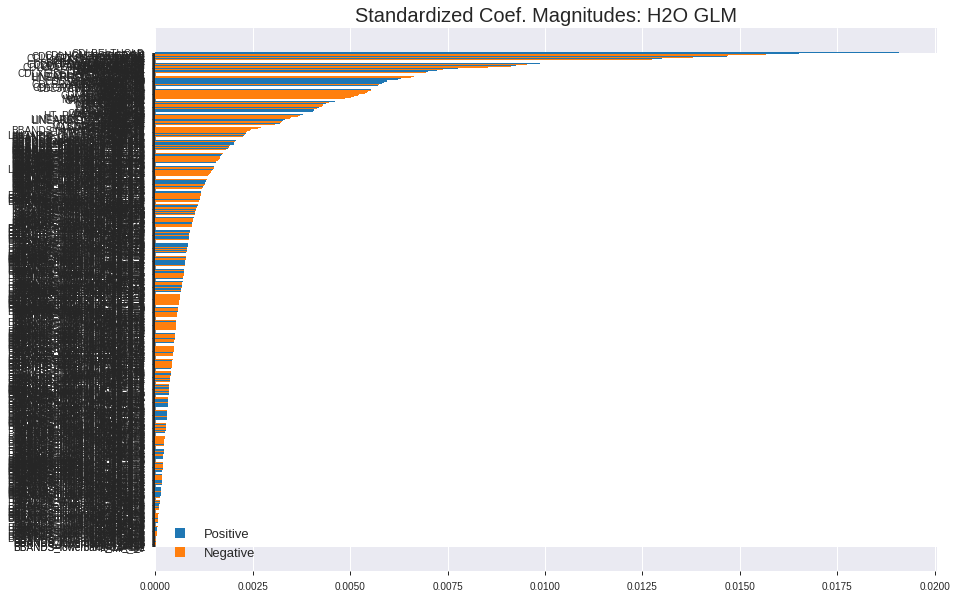

'log_likelihood'
--2019-09-03 03:52:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.184
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.184|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_035125_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_035125_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLBELTHOLD',
 'AD',
 'DX_8',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'aroonup_30',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'DX_12',
 'DX_14',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'DX_20',
 'DX_24',
 'CDLRICKSHAWMAN',
 'DX_30',
 'day',
 'aroonup_14',
 'CDLONNECK',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'aroondown_14',
 'is_month_end',
 'CDLMORNINGDOJISTAR',
 'AROONOSC_30',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'hour',
 'aroondown_12',
 'CDLCLOSINGMARUBOZU',
 'aroonup_20',
 'CDLDOJISTAR',
 'CDLPIERCING',
 'CDLINNECK',
 'STOCH_slowd',
 'MFI_14',
 'SAREXT',
 'AROONOSC_8',
 'CDLENGULFING',
 'CCI_8',
 'VAR_30',
 'CDLXSIDEGAP3METHODS',
 'STOCHF_fastd',
 'STOCH_slowk',
 'PPO',
 'CDLEVENINGSTAR',
 'LINEARREG_ANGLE_24',
 'MACDEXT',
 'LINEARREG_SLOPE_24',
 'MINUS_DM_8',
 'APO',
 'aroonup_12',
 'aroondown_8',
 'OBV',
 'BETA_30',
 'days_in_month',
 'AROONOSC_20',
 'CDLSHOOTINGSTAR',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'aroonup_8',
 'MACDFIX_hist_24',
 'CDLSEPARATINGLINES',
 'VAR_

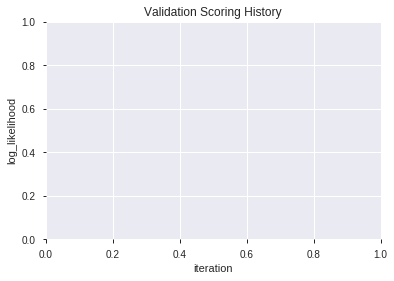

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_035216_model_4  0.597937  0.714845              0.487500  0.510371  0.260478
1  XGBoost_grid_1_AutoML_20190903_035216_model_5  0.561003  0.859980              0.419337  0.564895  0.319106
2  XGBoost_grid_1_AutoML_20190903_035216_model_6  0.556149  0.810805              0.471521  0.549477  0.301925
3               XGBoost_2_AutoML_20190903_035216  0.554531  0.750878              0.500000  0.525591  0.276246
4               XGBoost_3_AutoML_20190903_035216  0.550202  0.811941              0.463188  0.550566  0.303123
5  XGBoost_grid_1_AutoML_20190903_035216_model_7  0.548058  0.793934              0.485396  0.542912  0.294753
6  XGBoost_grid_1_AutoML_20190903_035216_model_2  0.541505  0.711759              0.495833  0.509008  0.259089
7  XGBoost_grid_1_AutoML_20190903_035216_model_3  0.541424  0.863108              0.444377  0.564916  0.319130
8  XGBoost_grid_1_AutoML_20190903_035216_model_1  0.526537  0.825703              0.483333  0.555426  0.308498
9               XGBoost_1_AutoML_20190903_035216  0.521117  0.743159              0.487500  0.522677  0.273191

variable  relative_importance  scaled_importance  percentage
0                         AD           113.478592           1.000000    0.038576
1                    WILLR_8            77.063454           0.679101    0.026197
2                       DX_8            76.596703           0.674988    0.026038
3                      CCI_8            68.417191           0.602908    0.023258
4                        DIV            64.507423           0.568455    0.021929
..                       ...                  ...                ...         ...
162                   ROC_12             5.221004           0.046009    0.001775
163  BBANDS_lowerband_24_7_2             5.203018           0.045850    0.001769
164               PLUS_DM_14             4.545214           0.040053    0.001545
165  BBANDS_lowerband_24_1_4             4.528647           0.039908    0.001539
166                 WILLR_12             3.473329           0.030608    0.001181

[167 rows x 4 columns]

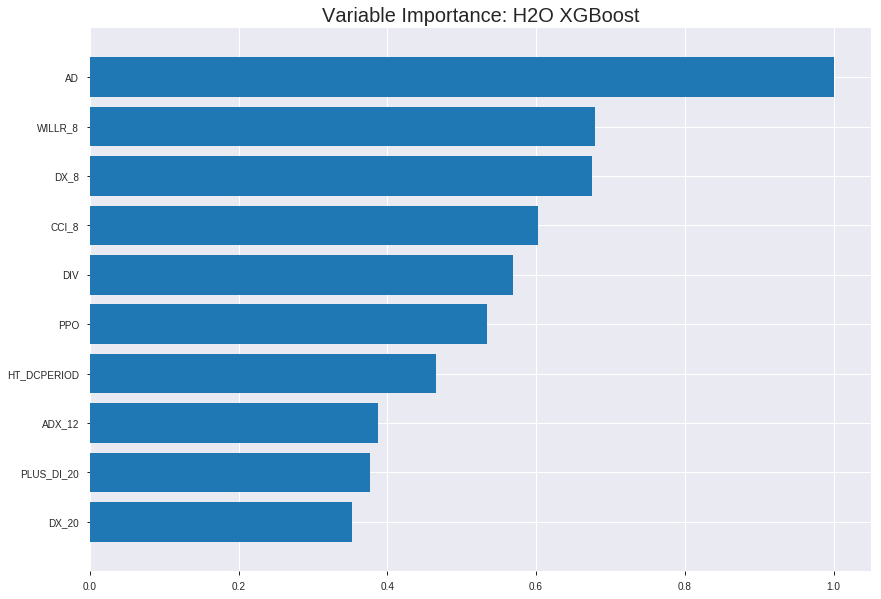

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_035216_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22281322689542382
RMSE: 0.47203095967894293
LogLoss: 0.638063919529031
Mean Per-Class Error: 0.2640263321007972
AUC: 0.80097364323752
pr_auc: 0.7951406526483219
Gini: 0.6019472864750399
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4770064428448677: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      381  386   0.5033   (386.0/767.0)
1      86   707   0.1084   (86.0/793.0)
Total  467  1093  0.3026   (472.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477006     0.749735  255
max f2                       0.450526     0.860537  303
max f0point5                 0.513611     0.745777  185
max accuracy                 0.504014     0.735897  202
max precision                0.709448     1         0
max recall                   0.338096     1         391
max specificity              0.709448     1         0
max absolute_mcc             0.504014     0.471882  202
max min_per_class_accuracy   0.503709     0.733922  203
max mean_per_class_accuracy  0.504014     0.735974  202

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.646835           1.96721   1.96721            1                0.669521  1                           0.669521            0.0201765       0.0201765                  96.7213   96.7213
    2        0.0205128                   0.639411           1.84426   1.90574            0.9375           0.642484  0.96875                     0.656002            0.0189155       0.0390921                  84.4262   90.5738
    3        0.0301282                   0.623682           1.83607   1.8835             0.933333         0.633032  0.957447                    0.648671            0.0176545       0.0567465                  83.6066   88.3502
    4        0.0403846                   0.614596           1.96721   1.90476            1                0.619633  0.968254                    0.641296            0.0201765       0.0769231                  96.7213   90.4762
    5        0.05                        0.609773           1.96721   1.91677            1                0.611763  0.974359                    0.635617            0.0189155       0.0958386                  96.7213   91.6772
    6        0.1                         0.584636           1.5889    1.75284            0.807692         0.596961  0.891026                    0.616289            0.0794451       0.175284                   58.8903   75.2837
    7        0.15                        0.567809           1.51324   1.67297            0.769231         0.575471  0.850427                    0.602683            0.075662        0.250946                   51.3241   67.2972
    8        0.2                         0.55574            1.61412   1.65826            0.820513         0.561749  0.842949                    0.59245             0.0807062       0.331652                   61.4124   65.826
    9        0.3                         0.536819           1.4628    1.59311            0.74359          0.545209  0.809829                    0.576703            0.14628         0.477932                   46.2799   59.3106
    10       0.4                         0.519046           1.3367    1.529              0.679487         0.527804  0.777244                    0.564478            0.13367         0.611602                   33.6696   52.9004
    11       0.5                         0.503758           1.21059   1.46532            0.615385         0.510937  0.744872                    0.55377             0.121059        0.732661                   21.0593   46.5322
    12       0.6                         0.489198           0.794451  1.35351            0.403846         0.496501  0.688034                    0.544225            0.0794451       0.812106                   -20.5549  35.351
    13       0.7                         0.47694            0.781841  1.27184            0.397436         0.48384   0.64652                     0.535599            0.0781841       0.89029                    -21.8159  27.1843
    14       0.8                         0.460379           0.643127  1.19325            0.326923         0.468918  0.606571                    0.527264            0.0643127       0.954603                   -35.6873  19.3253
    15       0.9                         0.431509           0.315259  1.0957             0.160256         0.449023  0.55698                     0.51857             0.0315259       0.986129                   -68.4741  9.56985
    16       1                           0.272192           0.138714  1                  0.0705128        0.396197  0.508333                    0.506333           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2502427552344342
RMSE: 0.5002426963329242
LogLoss: 0.69379422121567
Mean Per-Class Error: 0.4531762810832578
AUC: 0.5395248162690023
pr_auc: 0.50602183299047
Gini: 0.07904963253800457
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31858256459236145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    215  0        (0.0/215.0)
Total  2    444  0.5135   (229.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.318583     0.652504   397
max f2                       0.318583     0.824387   397
max f0point5                 0.473531     0.542077   236
max accuracy                 0.496531     0.547085   170
max precision                0.665468     1          0
max recall                   0.318583     1          397
max specificity              0.665468     1          0
max absolute_mcc             0.488796     0.0936022  193
max min_per_class_accuracy   0.488796     0.539535   193
max mean_per_class_accuracy  0.488796     0.546824   193

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.620021           0.829767  0.829767           0.4              0.634642  0.4                         0.634642            0.00930233      0.00930233                 -17.0233  -17.0233
    2        0.0201794                   0.610462           0.518605  0.691473           0.25             0.611842  0.333333                    0.624509            0.00465116      0.0139535                  -48.1395  -30.8527
    3        0.0313901                   0.59853            0.829767  0.740864           0.4              0.605813  0.357143                    0.617832            0.00930233      0.0232558                  -17.0233  -25.9136
    4        0.0403587                   0.588709           2.07442   1.03721            1                0.591617  0.5                         0.612006            0.0186047       0.0418605                  107.442   3.72093
    5        0.0515695                   0.584335           0.829767  0.992113           0.4              0.586675  0.478261                    0.606499            0.00930233      0.0511628                  -17.0233  -0.788675
    6        0.100897                    0.555924           1.32008   1.15245            0.636364         0.566393  0.555556                    0.586892            0.0651163       0.116279                   32.0085   15.2455
    7        0.150224                    0.540337           0.754334  1.02173            0.363636         0.549087  0.492537                    0.574478            0.0372093       0.153488                   -24.5666  2.17286
    8        0.201794                    0.5284             1.1725    1.06026            0.565217         0.534384  0.511111                    0.564232            0.0604651       0.213953                   17.2497   6.02584
    9        0.300448                    0.510967           1.1315    1.08365            0.545455         0.518687  0.522388                    0.549277            0.111628        0.325581                   13.1501   8.36515
    10       0.401345                    0.500533           1.06026   1.07777            0.511111         0.505336  0.519553                    0.53823             0.106977        0.432558                   6.02584   7.77706
    11       0.5                         0.486393           1.08436   1.07907            0.522727         0.493609  0.520179                    0.529426            0.106977        0.539535                   8.43552   7.90698
    12       0.600897                    0.474886           1.01416   1.06817            0.488889         0.48103   0.514925                    0.5213              0.102326        0.64186                    1.41602   6.81708
    13       0.699552                    0.457158           0.80148   1.03056            0.386364         0.466945  0.496795                    0.513634            0.0790698       0.72093                    -19.852   3.05605
    14       0.800448                    0.435918           0.875866  1.01106            0.422222         0.444369  0.487395                    0.504903            0.0883721       0.809302                   -12.4134  1.10612
    15       0.899103                    0.396496           0.942918  1.00358            0.454545         0.41616   0.483791                    0.495166            0.0930233       0.902326                   -5.70825  0.358406
    16       1                           0.302385           0.968062  1                  0.466667         0.365934  0.482063                    0.482127   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:52:45  12.028 sec  0                  0.5              0.693147            0.5             0                  1                0.491667                         0.5                0.693147              0.5               0                    1                  0.517937
    2019-09-03 03:52:46  13.282 sec  5                  0.494241         0.681684            0.700256        0.679099           1.59836          0.385897                         0.498481           0.690113              0.556257          0.507119             0.691473           0.517937
    2019-09-03 03:52:47  14.003 sec  10                 0.490638         0.674561            0.724793        0.715899           1.59836          0.401282                         0.497887           0.688922              0.556609          0.526441             1.24465            0.508969
    2019-09-03 03:52:47  14.684 sec  15                 0.486498         0.666404            0.737554        0.732145           1.72131          0.370513                         0.498498           0.690146              0.542726          0.516243             1.65953            0.495516
    2019-09-03 03:52:48  15.373 sec  20                 0.482708         0.658976            0.759134        0.752398           1.84426          0.35                             0.500227           0.69363               0.519601          0.500499             1.24465            0.513453
    2019-09-03 03:52:49  16.049 sec  25                 0.479299         0.652298            0.76981         0.762998           1.84426          0.333333                         0.501267           0.695742              0.511376          0.488107             1.24465            0.515695
    2019-09-03 03:52:49  16.393 sec  30                 0.475461         0.644803            0.781292        0.775321           1.96721          0.308974                         0.50152            0.696287              0.519108          0.492881             1.65953            0.517937
    2019-09-03 03:52:49  16.743 sec  35                 0.471602         0.637303            0.793272        0.786195           1.96721          0.285897                         0.501196           0.695709              0.528974          0.491499             0.829767           0.513453
    2019-09-03 03:52:50  17.122 sec  40                 0.475235         0.644312            0.784292        0.776211           1.96721          0.316026                         0.50097            0.695207              0.527746          0.492724             1.24465            0.515695
    2019-09-03 03:52:50  17.478 sec  45                 0.476629         0.646982            0.78059         0.766745           1.96721          0.292949                         0.502285           0.697921              0.519138          0.477459             0.829767           0.513453
    2019-09-03 03:52:51  17.826 sec  50                 0.472031         0.638064            0.800974        0.795141           1.96721          0.302564                         0.500243           0.693794              0.539525          0.506022             0.829767           0.513453

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
AD                       113.47859191894531     1.0                   0.03857565205715564
WILLR_8                  77.0634536743164       0.6791012504751622    0.026196773549909163
DX_8                     76.5967025756836       0.6749881301875383    0.026038107252824554
CCI_8                    68.41719055175781      0.6029083494499682    0.023257582710735976
DIV                      64.5074234008789       0.5684545631915737    0.021928505439980542
---                      ---                    ---                   ---
ROC_12                   5.221004009246826      0.04600871337014869   0.0017748161185642606
BBANDS_lowerband_24_7_2  5.2030181884765625     0.04585021809393738   0.0017687020599364304
PLUS_DM_14               4.5452141761779785     0.040053494666416924  0.0015450896739248386
BBANDS_lowerband_24_1_4  4.528647422790527      0.039907504545220455  0.0015394580098057817
WILLR_12                 3.4733285903930664     0.030607787175170195  0.0011807153483088361


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6377708978328174)

('auc', 0.5979368932038834)

('logloss', 0.7148449238515643)

('mean_per_class_error', 0.402467637540453)

('rmse', 0.5103707853153663)

('mse', 0.26047833850342367)

xgboost prediction progress: |████████████████████████████████████████████| 100%


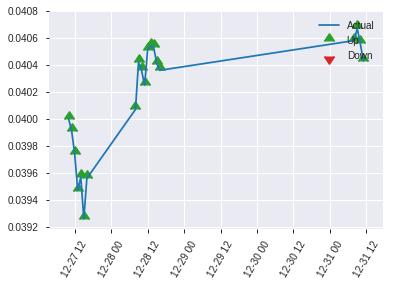


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26047833850342367
RMSE: 0.5103707853153663
LogLoss: 0.7148449238515643
Mean Per-Class Error: 0.402467637540453
AUC: 0.5979368932038834
pr_auc: 0.5310894657035636
Gini: 0.19587378640776687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.422961950302124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    117  0.975    (117.0/120.0)
1      0    103  0        (0.0/103.0)
Total  3    220  0.5247   (117.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422962     0.637771  218
max f2                       0.422962     0.814873  218
max f0point5                 0.614612     0.5666    98
max accuracy                 0.614612     0.600897  98
max precision                0.711872     1         0
max recall                   0.422962     1         218
max specificity              0.711872     1         0
max absolute_mcc             0.614612     0.19554   98
max min_per_class_accuracy   0.609761     0.582524  106
max mean_per_class_accuracy  0.614612     0.597532  98

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 59.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.696168           1.44337   1.44337            0.666667         0.703953  0.666667                    0.703953            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.693375           1.08252   1.29903            0.5              0.695086  0.6                         0.700406            0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.690537           0         0.927878           0                0.692411  0.428571                    0.698122            0               0.0291262                  -100      -7.21221
    4        0.0403587                   0.687688           1.08252   0.962244           0.5              0.689062  0.444444                    0.696108            0.00970874      0.038835                   8.25243   -3.77562
    5        0.0538117                   0.685134           1.44337   1.08252            0.666667         0.686643  0.5                         0.693742            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.668243           1.37776   1.22372            0.636364         0.674007  0.565217                    0.684303            0.0679612       0.126214                   37.7758   22.3723
    7        0.152466                    0.656193           0.78729   1.08252            0.363636         0.660901  0.5                         0.676732            0.038835        0.165049                   -21.271   8.25243
    8        0.201794                    0.644549           1.57458   1.2028             0.727273         0.649953  0.555556                    0.670186            0.0776699       0.242718                   57.4581   20.2805
    9        0.300448                    0.631391           1.37776   1.26025            0.636364         0.637757  0.58209                     0.659538            0.135922        0.378641                   37.7758   26.0252
    10       0.399103                    0.623251           0.984113  1.19199            0.454545         0.627262  0.550562                    0.651559            0.0970874       0.475728                   -1.5887   19.1993
    11       0.502242                    0.606698           1.12959   1.17918            0.521739         0.61427   0.544643                    0.643902            0.116505        0.592233                   12.9591   17.9178
    12       0.600897                    0.593665           0.885702  1.131              0.409091         0.600104  0.522388                    0.636711            0.0873786       0.679612                   -11.4298  13.0996
    13       0.699552                    0.576345           0.78729   1.08252            0.363636         0.585468  0.5                         0.629484            0.0776699       0.757282                   -21.271   8.25243
    14       0.798206                    0.54783            0.78729   1.04603            0.363636         0.562304  0.483146                    0.621181            0.0776699       0.834951                   -21.271   4.60347
    15       0.896861                    0.486214           0.78729   1.01757            0.363636         0.51896   0.47                        0.609937            0.0776699       0.912621                   -21.271   1.75728
    16       1                           0.392422           0.847193  1                  0.391304         0.446303  0.461883                    0.59306        

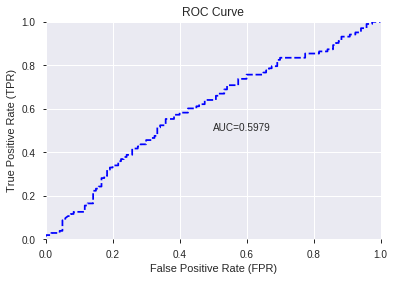

This function is available for GLM models only


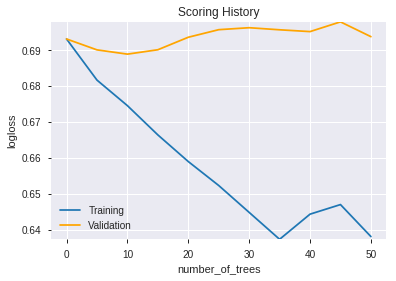

--2019-09-03 03:53:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_035216_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_035216_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['AD',
 'WILLR_8',
 'DX_8',
 'CCI_8',
 'DIV',
 'PPO',
 'HT_DCPERIOD',
 'ADX_12',
 'PLUS_DI_20',
 'DX_20',
 'PLUS_DM_12',
 'ATR_8',
 'NATR_8',
 'STOCH_slowd',
 'MFI_8',
 'BETA_8',
 'STOCH_slowk',
 'OBV',
 'ROC_20',
 'MFI_12',
 'WILLR_14',
 'day',
 'MOM_8',
 'aroonup_30',
 'Volume',
 'STDDEV_30',
 'BBANDS_upperband_12_7_3',
 'ADOSC',
 'TRIX_8',
 'ULTOSC',
 'SAREXT',
 'ADX_24',
 'ATR_24',
 'LINEARREG_ANGLE_24',
 'AROONOSC_20',
 'STDDEV_24',
 'HT_PHASOR_quadrature',
 'APO',
 'MACDFIX_hist_20',
 'TRANGE',
 'ROC_8',
 'CCI_20',
 'STOCHRSI_fastd',
 'CCI_24',
 'SUB',
 'DX_24',
 'MOM_30',
 'BETA_24',
 'AROONOSC_30',
 'MINUS_DI_20',
 'DX_30',
 'dayofyear',
 'BBANDS_upperband_20_7_3',
 'MACDFIX_hist_24',
 'PLUS_DM_8',
 'MACDFIX_hist_14',
 'aroonup_14',
 'BBANDS_upperband_30_1_4',
 'BOP',
 'aroondown_12',
 'MACDEXT_hist',
 'STDDEV_12',
 'BBANDS_lowerband_8_6_5',
 'STOCHF_fastk',
 'STDDEV_8',
 'HT_PHASOR_inphase',
 'MFI_14',
 'PLUS_DI_14',
 'MFI_30',
 'DX_14',
 'BETA_30',
 'ADX_8',
 'KAMA_24',
 'ARO

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

904

['BBANDS_upperband_8_2_5',
 'BBANDS_middleband_8_2_5',
 'BBANDS_lowerband_8_2_5',
 'MA_8_3',
 'MAVP_8_3',
 'T3_8_3',
 'BBANDS_upperband_8_3_2',
 'BBANDS_middleband_8_3_2',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_upperband_8_3_3',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_3_3',
 'BBANDS_upperband_8_3_4',
 'BBANDS_middleband_8_3_4',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_middleband_8_3_5',
 'BBANDS_lowerband_8_3_5',
 'MA_8_4',
 'MAVP_8_4',
 'T3_8_4',
 'BBANDS_upperband_8_4_2',
 'BBANDS_middleband_8_4_2',
 'BBANDS_lowerband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_8_4_3',
 'BBANDS_upperband_8_4_4',
 'BBANDS_middleband_8_4_4',
 'BBANDS_lowerband_8_4_4',
 'BBANDS_upperband_8_4_5',
 'BBANDS_middleband_8_4_5',
 'BBANDS_lowerband_8_4_5',
 'MA_8_5',
 'MAVP_8_5',
 'T3_8_5',
 'BBANDS_upperband_8_5_2',
 'BBANDS_middleband_8_5_2',
 'BBANDS_lowerband_8_5_2',
 'BBANDS_upperband_8_5_3',
 'BBANDS_middleband_8_5_3',
 'BBANDS_lowerband_8

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_035431_model_7  0.558252  0.739264              0.458981  0.520938  0.271377
1  DeepLearning_grid_1_AutoML_20190903_035431_model_6  0.555744  0.698483              0.491667  0.502655  0.252662
2  DeepLearning_grid_1_AutoML_20190903_035431_model_2  0.550081  2.192974              0.500000  0.705864  0.498245
3  DeepLearning_grid_1_AutoML_20190903_035431_model_1  0.546966  8.984164              0.495833  0.729869  0.532708
4  DeepLearning_grid_1_AutoML_20190903_035431_model_3  0.535356  1.197793              0.500000  0.636876  0.405611
5               DeepLearning_1_AutoML_20190903_035431  0.500000  0.698655              0.500000  0.502743  0.252751
6  DeepLearning_grid_1_AutoML_20190903_035431_model_5  0.500000  0.691261              0.500000  0.499056  0.249057
7  DeepLearning_grid_1_AutoML_20190903_035431_model_9  0.500000  0.690606              0.500000  0.498729  0.248730
8  DeepLearning_grid_1_AutoML_20190903_035431_model_8  0.500000  0.690714              0.500000  0.498783  0.248784
9  DeepLearning_grid_1_AutoML_20190903_035431_model_4  0.477508  1.074106              0.500000  0.604594  0.365534

variable  relative_importance  scaled_importance  percentage
0     BBANDS_upperband_12_3_5             1.000000           1.000000    0.001204
1     BBANDS_upperband_30_6_2             0.994441           0.994441    0.001197
2     BBANDS_lowerband_30_2_2             0.994115           0.994115    0.001197
3                         PPO             0.976959           0.976959    0.001176
4    BBANDS_middleband_30_6_5             0.975461           0.975461    0.001174
..                        ...                  ...                ...         ...
898                aroonup_30             0.861974           0.861974    0.001038
899   BBANDS_upperband_14_1_5             0.861251           0.861251    0.001037
900                      SQRT             0.854182           0.854182    0.001028
901   BBANDS_upperband_12_4_5             0.852462           0.852462    0.001026
902             MINMAX_min_14             0.849812           0.849812    0.001023

[903 rows x 4 columns]

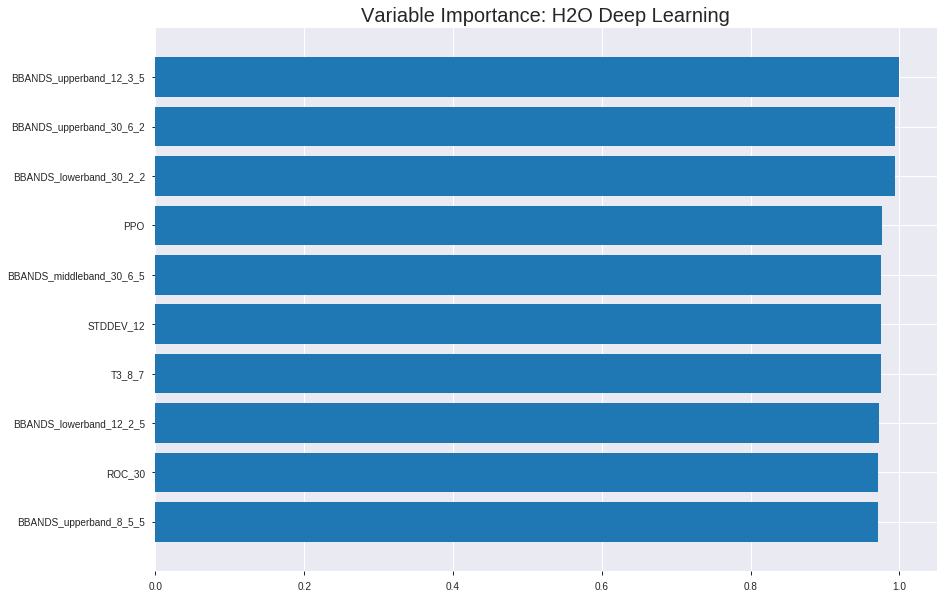

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_035431_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24573481578846318
RMSE: 0.49571646713465467
LogLoss: 0.6857442590435059
Mean Per-Class Error: 0.43913907709406463
AUC: 0.5871116401498773
pr_auc: 0.5858060089553802
Gini: 0.17422328029975453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28515680612255623: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      65   702   0.9153   (702.0/767.0)
1      15   778   0.0189   (15.0/793.0)
Total  80   1480  0.4596   (717.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285157     0.684558  344
max f2                       0.138993     0.839346  384
max f0point5                 0.430978     0.58403   252
max accuracy                 0.430978     0.562179  252
max precision                0.976801     1         0
max recall                   0.0774199    1         393
max specificity              0.976801     1         0
max absolute_mcc             0.285157     0.149205  344
max min_per_class_accuracy   0.442084     0.548892  239
max mean_per_class_accuracy  0.468675     0.560861  209

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 47.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102564                   0.906839           1.59836   1.59836            0.8125           0.938645  0.8125                      0.938645            0.0163934       0.0163934                  59.8361    59.8361
    2        0.0205128                   0.849997           1.22951   1.41393            0.625            0.878383  0.71875                     0.908514            0.0126103       0.0290038                  22.9508    41.3934
    3        0.0301282                   0.797445           1.18033   1.33938            0.6              0.818075  0.680851                    0.879651            0.0113493       0.0403531                  18.0328    33.9379
    4        0.0403846                   0.753614           1.59836   1.40515            0.8125           0.774407  0.714286                    0.852922            0.0163934       0.0567465                  59.8361    40.5152
    5        0.05                        0.72729            0.918033  1.31148            0.466667         0.742464  0.666667                    0.83168             0.00882724      0.0655738                  -8.19672   31.1475
    6        0.1                         0.638605           1.16015   1.23581            0.589744         0.677916  0.628205                    0.754798            0.0580076       0.123581                   16.0151    23.5813
    7        0.15                        0.58973            1.26103   1.24422            0.641026         0.609565  0.632479                    0.706387            0.0630517       0.186633                   26.1034    24.422
    8        0.2                         0.552925           1.08449   1.20429            0.551282         0.57271   0.612179                    0.672968            0.0542245       0.240858                   8.44893    20.4288
    9        0.3                         0.503307           1.12232   1.17697            0.570513         0.526859  0.598291                    0.624265            0.112232        0.35309                    12.232     17.6965
    10       0.4                         0.46553            1.02144   1.13808            0.519231         0.482903  0.578526                    0.588924            0.102144        0.455233                   2.14376    13.8083
    11       0.5                         0.44215            0.933165  1.0971             0.474359         0.453313  0.557692                    0.561802            0.0933165       0.54855                    -6.68348   9.70996
    12       0.686538                    0.440363           0.993747  1.06902            0.505155         0.440417  0.543417                    0.528821            0.185372        0.733922                   -0.625317  6.90178
    13       0.7                         0.438128           1.12412   1.07008            0.571429         0.439296  0.543956                    0.527099            0.0151324       0.749054                   12.4122    7.00775
    14       0.8                         0.410327           0.970996  1.05769            0.49359          0.425747  0.53766                     0.51443             0.0970996       0.846154                   -2.90038   5.76923
    15       0.9                         0.35677            0.920555  1.04245            0.467949         0.388243  0.529915                    0.500409            0.0920555       0.938209                   -7.94451   4.24548
    16       1                           0.0231514          0.617907  1                  0.314103         0.256503  0.508333                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2731019264869965
RMSE: 0.5225915484266814
LogLoss: 0.749132617721234
Mean Per-Class Error: 0.4833887043189369
AUC: 0.4991543340380549
pr_auc: 0.4824724621999578
Gini: -0.0016913319238901492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23994294177105963: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    224  0.9697   (224.0/231.0)
1      0    215  0        (0.0/215.0)
Total  7    439  0.5022   (224.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239943     0.657492  392
max f2                       0.239943     0.82756   392
max f0point5                 0.239943     0.545408  392
max accuracy                 0.826831     0.53139   23
max precision                0.866982     0.7       9
max recall                   0.239943     1         392
max specificity              0.90361      0.995671  0
max absolute_mcc             0.239943     0.121823  392
max min_per_class_accuracy   0.460724     0.506977  212
max mean_per_class_accuracy  0.443076     0.516611  249

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.886776           1.24465   1.24465            0.6              0.89848   0.6                         0.89848             0.0139535       0.0139535                  24.4651   24.4651
    2        0.0201794                   0.867122           1.55581   1.38295            0.75             0.874278  0.666667                    0.887723            0.0139535       0.027907                   55.5814   38.2946
    3        0.0313901                   0.859023           0.829767  1.18538            0.4              0.863187  0.571429                    0.878961            0.00930233      0.0372093                  -17.0233  18.5382
    4        0.0403587                   0.847765           1.55581   1.2677             0.75             0.854012  0.611111                    0.873417            0.0139535       0.0511628                  55.5814   26.77
    5        0.0515695                   0.828719           1.24465   1.26269            0.6              0.837306  0.608696                    0.865566            0.0139535       0.0651163                  24.4651   26.269
    6        0.100897                    0.725162           0.565751  0.921964           0.272727         0.793767  0.444444                    0.830465            0.027907        0.0930233                  -43.4249  -7.80362
    7        0.150224                    0.644772           0.848626  0.897883           0.409091         0.691174  0.432836                    0.784727            0.0418605       0.134884                   -15.1374  -10.2117
    8        0.201794                    0.600123           1.1725    0.968062           0.565217         0.621037  0.466667                    0.742895            0.0604651       0.195349                   17.2497   -3.1938
    9        0.300448                    0.54114            1.08436   1.00625            0.522727         0.570389  0.485075                    0.686252            0.106977        0.302326                   8.43552   0.624783
    10       0.401345                    0.489315           0.968062  0.996648           0.466667         0.513195  0.480447                    0.642746            0.0976744       0.4                        -3.1938   -0.335196
    11       0.5                         0.459861           1.08436   1.01395            0.522727         0.473609  0.488789                    0.609373            0.106977        0.506977                   8.43552   1.39535
    12       0.600897                    0.441659           1.01416   1.01399            0.488889         0.449442  0.488806                    0.582519            0.102326        0.609302                   1.41602   1.39882
    13       0.699552                    0.434045           0.895772  0.997317           0.431818         0.439581  0.480769                    0.562361            0.0883721       0.697674                   -10.4228  -0.268336
    14       0.800448                    0.404354           1.06026   1.00525            0.511111         0.41977   0.484594                    0.544388            0.106977        0.804651                   6.02584   0.525047
    15       0.899103                    0.363955           0.848626  0.988065           0.409091         0.386936  0.476309                    0.527111            0.0837209       0.888372                   -15.1374  -1.19353
    16       1                           0.176357           1.10636   1                  0.533333         0.301137  0.482063                    0.504311   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:07:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:07:48  6.354 sec         116 obs/sec       0.274359  1             428        0.648968         2.07969             -0.685108      0.546793        0.527643           1.22951          0.491667                         0.658785           2.30786               -0.738226        0.491503          0.466012             0.829767           0.513453
    2019-09-03 04:08:14  31.653 sec        162 obs/sec       2.77179   10            4324       0.495716         0.685744            0.0167876      0.587112        0.585806           1.59836          0.459615                         0.522592           0.749133              -0.0938154       0.499154          0.482472             1.24465            0.502242
    2019-09-03 04:08:39  56.660 sec        202 obs/sec       6.40705   23            9995       0.550298         0.857444            -0.211649      0.60202         0.612103           1.84426          0.461538                         0.605089           1.08047               -0.466419        0.492037          0.473454             0.829767           0.517937
    2019-09-03 04:09:03  1 min 21.046 sec  219 obs/sec       10.0397   36            15662      0.623097         1.22235             -0.553431      0.656772        0.680566           1.96721          0.432051                         0.637429           1.33155               -0.627356        0.497101          0.472593             0.829767           0.517937
    2019-09-03 04:09:27  1 min 45.334 sec  234 obs/sec       13.9712   50            21795      0.549551         0.939401            -0.20836       0.651176        0.638583           1.96721          0.390385                         0.616012           1.19807               -0.519837        0.508769          0.481597             0.829767           0.506726
    2019-09-03 04:09:54  2 min 11.452 sec  242 obs/sec       18.1859   65            28370      0.545167         0.838311            -0.189157      0.721618        0.736332           1.96721          0.362179                         0.608345           1.24528               -0.48224         0.492641          0.472117             0.829767           0.506726
    2019-09-03 04:10:18  2 min 36.034 sec  248 obs/sec       22.141    79            34540      0.467879         0.607833            0.124114       0.737069        0.711363           1.96721          0.349359                         0.57036            1.08126               -0.302918        0.505789          0.491891             0.829767           0.504484
    2019-09-03 04:10:21  2 min 38.443 sec  248 obs/sec       22.141    79            34540      0.495716         0.685744            0.0167876      0.587112        0.585806           1.59836          0.459615                         0.522592           0.749133              -0.0938154       0.499154          0.482472             1.24465            0.502242

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BBANDS_upperband_12_3_5   1.0                    1.0                  0.0012038257251731994
BBANDS_upperband_30_6_2   0.9944413900375366     0.9944413900375366   0.001197134127504182
BBANDS_lowerband_30_2_2   0.9941152930259705     0.9941152930259705   0.0011967415635327566
PPO                       0.9769587516784668     0.9769587516784668   0.0011760880777036342
BBANDS_middleband_30_6_5  0.9754611253738403     0.9754611253738403   0.0011742851966314285
---                       ---                    ---                  ---
aroonup_30                0.861973762512207      0.861973762512207    0.0010376661897365288
BBANDS_upperband_14_1_5   0.8612506985664368     0.8612506985664368   0.0010367957467576653
SQRT                      0.8541818857192993     0.8541818857192993   0.0010282861280058466
BBANDS_upperband_12_4_5   0.8524618148803711     0.8524618148803711   0.0010262154624808245
MINMAX_min_14             0.849811851978302      0.849811851978302    0.0010230253689685592


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6378737541528239)

('auc', 0.5582524271844661)

('logloss', 0.7392644804251595)

('mean_per_class_error', 0.43155339805825244)

('rmse', 0.520938335828859)

('mse', 0.27137674973614107)

deeplearning prediction progress: |███████████████████████████████████████| 100%


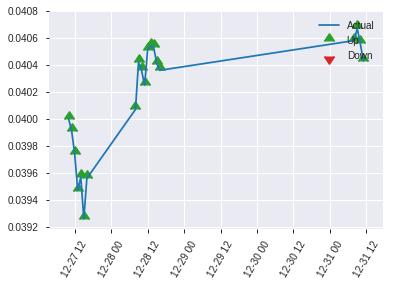


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27137674973614107
RMSE: 0.520938335828859
LogLoss: 0.7392644804251595
Mean Per-Class Error: 0.43155339805825244
AUC: 0.5582524271844661
pr_auc: 0.5099197992120295
Gini: 0.11650485436893221
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4887871966298866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   102  0.85     (102.0/120.0)
1      7    96   0.068    (7.0/103.0)
Total  25   198  0.4888   (109.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488787     0.637874  197
max f2                       0.440363     0.812303  221
max f0point5                 0.535098     0.539033  175
max accuracy                 0.679024     0.578475  66
max precision                0.818025     1         0
max recall                   0.440363     1         221
max specificity              0.818025     1         0
max absolute_mcc             0.661372     0.141907  80
max min_per_class_accuracy   0.632275     0.543689  109
max mean_per_class_accuracy  0.661372     0.568447  80

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 61.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.774548           1.44337   1.44337            0.666667         0.793535  0.666667                    0.793535            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.7657             2.16505   1.73204            1                0.768116  0.8                         0.783367            0.0194175       0.038835                   116.505   73.2039
    3        0.0313901                   0.761558           0         1.23717            0                0.763914  0.571429                    0.777809            0               0.038835                   -100      23.7171
    4        0.0403587                   0.746351           1.08252   1.2028             0.5              0.753923  0.555556                    0.772501            0.00970874      0.0485437                  8.25243   20.2805
    5        0.0538117                   0.742105           0         0.902104           0                0.743944  0.416667                    0.765362            0               0.0485437                  -100      -9.78964
    6        0.103139                    0.724934           1.57458   1.22372            0.727273         0.731527  0.565217                    0.74918             0.0776699       0.126214                   57.4581   22.3723
    7        0.152466                    0.709075           0.984113  1.1462             0.454545         0.716047  0.529412                    0.73846             0.0485437       0.174757                   -1.5887   14.6202
    8        0.201794                    0.697774           0.78729   1.05847            0.363636         0.702628  0.488889                    0.729702            0.038835        0.213592                   -21.271   5.84682
    9        0.300448                    0.678398           1.57458   1.22794            0.727273         0.688058  0.567164                    0.716027            0.15534         0.368932                   57.4581   22.7938
    10       0.399103                    0.652449           0.78729   1.11901            0.363636         0.664506  0.516854                    0.703292            0.0776699       0.446602                   -21.271   11.9014
    11       0.502242                    0.629743           0.941325  1.08252            0.434783         0.641816  0.5                         0.690667            0.0970874       0.543689                   -5.86745  8.25243
    12       0.600897                    0.603612           0.590468  1.00174            0.272727         0.61888   0.462687                    0.678881            0.0582524       0.601942                   -40.9532  0.173888
    13       0.699552                    0.570534           1.47617   1.06865            0.681818         0.590581  0.49359                     0.666429            0.145631        0.747573                   47.6169   6.86458
    14       0.798206                    0.531395           0.984113  1.0582             0.454545         0.548415  0.488764                    0.651843            0.0970874       0.84466                    -1.5887   5.81979
    15       0.896861                    0.486413           0.885702  1.03922            0.409091         0.508719  0.48                        0.636099            0.0873786       0.932039                   -11.4298  3.92233
    16       1                           0.434614           0.658928  1                  0.304348         0.464042  0.461883                    0.618353       

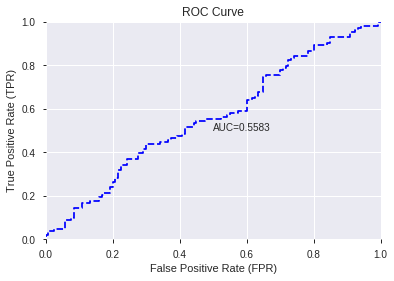

This function is available for GLM models only


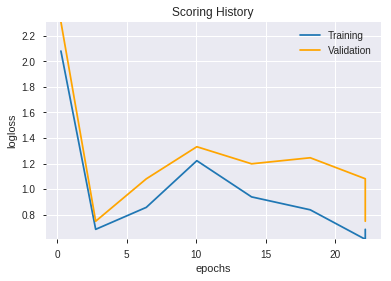

--2019-09-03 04:17:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_035431_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_035431_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_upperband_12_3_5',
 'BBANDS_upperband_30_6_2',
 'BBANDS_lowerband_30_2_2',
 'PPO',
 'BBANDS_middleband_30_6_5',
 'STDDEV_12',
 'T3_8_7',
 'BBANDS_lowerband_12_2_5',
 'ROC_30',
 'BBANDS_upperband_8_5_5',
 'CDLEVENINGSTAR',
 'KAMA_30',
 'BBANDS_lowerband_30_6_4',
 'BBANDS_lowerband_8_5_3',
 'ROCR_24',
 'NATR_30',
 'TRIX_14',
 'AVGPRICE',
 'MA_8_4',
 'BBANDS_middleband_20_0_2',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_30_0_5',
 'aroondown_8',
 'BBANDS_lowerband_12_6_2',
 'ROCP_14',
 'ADX_24',
 'LN',
 'BBANDS_upperband_24_1_4',
 'MINMAX_max_20',
 'CDLADVANCEBLOCK',
 'MOM_14',
 'CDLHIKKAKE',
 'EMA_14',
 'BBANDS_upperband_8_4_4',
 'BBANDS_upperband_30_1_4',
 'CMO_8',
 'LINEARREG_ANGLE_8',
 'BBANDS_upperband_12_1_4',
 'SUM_20',
 'ADX_12',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_lowerband_14_5_3',
 'MA_8_8',
 'LINEARREG_12',
 'ADXR_14',
 'ROCP_20',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_middleband_24_7_4',
 'BBANDS_upperband_20_2_3',
 'TRIMA_20',
 'BBANDS_middleband_14_7_5',
 'BBANDS

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_041723_model_1  0.53932  0.745657                   0.5  0.524403  0.274999

variable  relative_importance  scaled_importance    percentage
0                          AD         2.639053e-02           1.000000  1.470621e-02
1                 CDLBELTHOLD         2.455116e-02           0.930302  1.368122e-02
2                        DX_8         2.044461e-02           0.774695  1.139283e-02
3             CDLHOMINGPIGEON         2.024616e-02           0.767175  1.128224e-02
4                  aroonup_30         1.942090e-02           0.735904  1.082236e-02
..                        ...                  ...                ...           ...
898                 MAVP_12_3         7.632977e-06           0.000289  4.253503e-06
899                      SINH         7.162488e-06           0.000271  3.991321e-06
900  BBANDS_middleband_30_6_4         4.462295e-06           0.000169  2.486629e-06
901    BBANDS_lowerband_8_7_3         2.999502e-06           0.000114  1.671483e-06
902                 MAVP_20_5         6.907141e-07           0.000026  3.849028e-07

[903 rows x 4 columns]

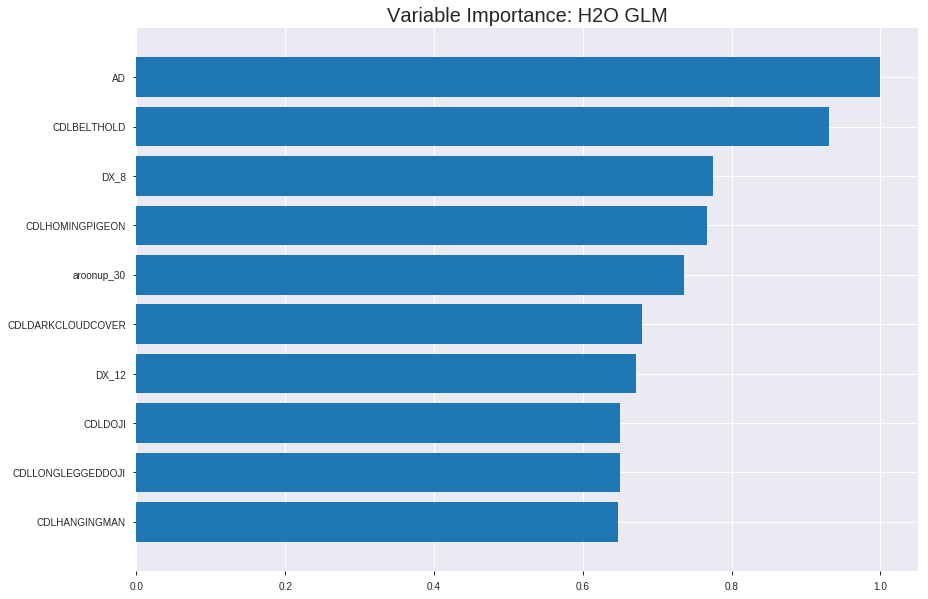

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_041723_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24264086983999206
RMSE: 0.4925859009756492
LogLoss: 0.6782840577806941
Null degrees of freedom: 1559
Residual degrees of freedom: 656
Null deviance: 2162.1858499497453
Residual deviance: 2116.2462602757655
AIC: 3924.2462602757655
AUC: 0.6137750295529166
pr_auc: 0.6150015247330363
Gini: 0.22755005910583326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45916933344648425: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      141  626   0.8162   (626.0/767.0)
1      61   732   0.0769   (61.0/793.0)
Total  202  1358  0.4404   (687.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459169     0.680614  307
max f2                       0.388166     0.839687  390
max f0point5                 0.500013     0.591863  220
max accuracy                 0.500516     0.579487  219
max precision                0.668663     1         0
max recall                   0.388166     1         390
max specificity              0.668663     1         0
max absolute_mcc             0.541671     0.184649  114
max min_per_class_accuracy   0.511417     0.574967  189
max mean_per_class_accuracy  0.500516     0.577682  219

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.606365           1.59836   1.59836            0.8125           0.625838  0.8125                      0.625838            0.0163934       0.0163934                  59.8361   59.8361
    2        0.0205128                   0.591609           1.47541   1.53689            0.75             0.598274  0.78125                     0.612056            0.0151324       0.0315259                  47.541    53.6885
    3        0.0301282                   0.586087           1.04918   1.38123            0.533333         0.589129  0.702128                    0.604739            0.0100883       0.0416141                  4.91803   38.1235
    4        0.0403846                   0.581661           1.10656   1.31148            0.5625           0.584451  0.666667                    0.599586            0.0113493       0.0529634                  10.6557   31.1475
    5        0.05                        0.576253           1.31148   1.31148            0.666667         0.578505  0.666667                    0.595532            0.0126103       0.0655738                  31.1475   31.1475
    6        0.1                         0.560301           1.38714   1.34931            0.705128         0.567186  0.685897                    0.581359            0.0693569       0.134931                   38.7137   34.9306
    7        0.15                        0.550711           1.43758   1.37873            0.730769         0.555672  0.700855                    0.572797            0.0718789       0.20681                    43.7579   37.8731
    8        0.2                         0.543685           1.26103   1.34931            0.641026         0.547194  0.685897                    0.566396            0.0630517       0.269861                   26.1034   34.9306
    9        0.3                         0.530469           1.02144   1.24002            0.519231         0.536909  0.630342                    0.556567            0.102144        0.372005                   2.14376   24.0017
    10       0.4                         0.520108           1.00883   1.18222            0.512821         0.525879  0.600962                    0.548895            0.100883        0.472888                   0.882724  18.2219
    11       0.5                         0.511398           0.996217  1.14502            0.50641          0.515857  0.582051                    0.542287            0.0996217       0.572509                   -0.37831  14.5019
    12       0.6                         0.50148            1.02144   1.12442            0.519231         0.506734  0.571581                    0.536362            0.102144        0.674653                   2.14376   12.4422
    13       0.7                         0.48961            0.857503  1.08629            0.435897         0.495895  0.552198                    0.530581            0.0857503       0.760404                   -14.2497  8.62908
    14       0.8                         0.474049           1.02144   1.07818            0.519231         0.482612  0.548077                    0.524585            0.102144        0.862547                   2.14376   7.81841
    15       0.9                         0.45034            0.75662   1.04245            0.384615         0.463427  0.529915                    0.517789            0.075662        0.938209                   -24.338   4.24548
    16       1                           0.308692           0.617907  1                  0.314103         0.423229  0.508333                    0.508333         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24920335753960027
RMSE: 0.49920272188721115
LogLoss: 0.6916033218588074
Null degrees of freedom: 445
Residual degrees of freedom: -458
Null deviance: 618.9445738826204
Residual deviance: 616.9101630980562
AIC: 2424.9101630980563
AUC: 0.5492097050236585
pr_auc: 0.5072301714681089
Gini: 0.09841941004731702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39056448882839023: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    230  0.9957   (230.0/231.0)
1      0    215  0        (0.0/215.0)
Total  1    445  0.5157   (230.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390564     0.651515  398
max f2                       0.390564     0.823755  398
max f0point5                 0.477653     0.553746  289
max accuracy                 0.498938     0.556054  228
max precision                0.675217     1         0
max recall                   0.390564     1         398
max specificity              0.675217     1         0
max absolute_mcc             0.498938     0.119045  228
max min_per_class_accuracy   0.507619     0.532468  199
max mean_per_class_accuracy  0.498938     0.558864  228

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.643041           0.829767  0.829767           0.4              0.654873  0.4                         0.654873            0.00930233      0.00930233                 -17.0233  -17.0233
    2        0.0201794                   0.617345           1.03721   0.921964           0.5              0.631508  0.444444                    0.644489            0.00930233      0.0186047                  3.72093   -7.80362
    3        0.0313901                   0.60708            0.829767  0.889037           0.4              0.614468  0.428571                    0.633767            0.00930233      0.027907                   -17.0233  -11.0963
    4        0.0403587                   0.597282           1.55581   1.03721            0.75             0.602187  0.5                         0.626749            0.0139535       0.0418605                  55.5814   3.72093
    5        0.0515695                   0.591017           0.829767  0.992113           0.4              0.595118  0.478261                    0.619873            0.00930233      0.0511628                  -17.0233  -0.788675
    6        0.100897                    0.567432           1.1315    1.06026            0.545455         0.577563  0.511111                    0.599188            0.055814        0.106977                   13.1501   6.02584
    7        0.150224                    0.556868           1.03721   1.05269            0.5              0.561204  0.507463                    0.586716            0.0511628       0.15814                    3.72093   5.269
    8        0.201794                    0.546286           1.1725    1.08331            0.565217         0.551041  0.522222                    0.577599            0.0604651       0.218605                   17.2497   8.33075
    9        0.300448                    0.531657           0.942918  1.03721            0.454545         0.538799  0.5                         0.564858            0.0930233       0.311628                   -5.70825  3.72093
    10       0.401345                    0.518676           1.19855   1.07777            0.577778         0.524666  0.519553                    0.554754            0.12093         0.432558                   19.8553   7.77706
    11       0.5                         0.50724            1.03721   1.06977            0.5              0.512883  0.515695                    0.546493            0.102326        0.534884                   3.72093   6.97674
    12       0.600897                    0.494212           1.19855   1.09139            0.577778         0.501221  0.526119                    0.538891            0.12093         0.655814                   19.8553   9.13919
    13       0.699552                    0.483917           0.80148   1.05051            0.386364         0.489711  0.50641                     0.531955            0.0790698       0.734884                   -19.852   5.05069
    14       0.800448                    0.466893           0.968062  1.04011            0.466667         0.475725  0.501401                    0.524868            0.0976744       0.832558                   -3.1938   4.01147
    15       0.899103                    0.450121           0.660042  0.998411           0.318182         0.459068  0.481297                    0.517648            0.0651163       0.897674                   -33.9958  -0.158905
    16       1                           0.348019           1.01416   1                  0.488889         0.426994  0.482063                    0.508501    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 04:17:25  0.000 sec   2            2.9       904           1.37212           1.3854
    2019-09-03 04:17:27  1.443 sec   4            2.1       904           1.36896           1.38469
    2019-09-03 04:17:28  2.912 sec   6            1.6       904           1.3653            1.38397
    2019-09-03 04:17:30  4.388 sec   8            1.1       904           1.36115           1.38342
    2019-09-03 04:17:31  5.842 sec   10           0.83      904           1.35657           1.38321
    2019-09-03 04:17:33  7.297 sec   12           0.6       904           1.35166           1.38347
    2019-09-03 04:17:34  8.759 sec   14           0.44      904           1.34652           1.38442
    2019-09-03 04:17:36  10.235 sec  16           0.32      904           1.34127           1.38617
    2019-09-03 04:17:37  11.696 sec  18           0.23      904           1.33599           1.38879
    2019-09-03 04:17:39  13.170 sec  20           0.17      904           1.33078           1.39228

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6319018404907976)

('auc', 0.5393203883495146)

('logloss', 0.7456567554810934)

('mean_per_class_error', 0.4316343042071198)

('rmse', 0.5244034883227406)

('mse', 0.2749990185650588)

glm prediction progress: |████████████████████████████████████████████████| 100%


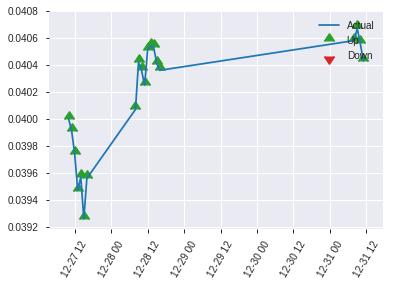


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2749990185650588
RMSE: 0.5244034883227406
LogLoss: 0.7456567554810934
Null degrees of freedom: 222
Residual degrees of freedom: -681
Null deviance: 309.7723147237181
Residual deviance: 332.5629129445677
AIC: 2140.562912944568
AUC: 0.5393203883495146
pr_auc: 0.48316900797773377
Gini: 0.07864077669902914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4114339015259054: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    120  1        (120.0/120.0)
1      0    103  0        (0.0/103.0)
Total  0    223  0.5381   (120.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411434     0.631902  222
max f2                       0.411434     0.811024  222
max f0point5                 0.637731     0.536723  106
max accuracy                 0.650369     0.569507  94
max precision                0.750865     1         0
max recall                   0.411434     1         222
max specificity              0.750865     1         0
max absolute_mcc             0.637731     0.136445  106
max min_per_class_accuracy   0.637731     0.553398  106
max mean_per_class_accuracy  0.637731     0.568366  106

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 62.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.726451           1.44337   1.44337            0.666667         0.737109  0.666667                    0.737109            0.0194175       0.0194175                  44.3366   44.3366
    2        0.0224215                   0.720232           1.08252   1.29903            0.5              0.722288  0.6                         0.73118             0.00970874      0.0291262                  8.25243   29.9029
    3        0.0313901                   0.713447           0         0.927878           0                0.716816  0.428571                    0.727076            0               0.0291262                  -100      -7.21221
    4        0.0403587                   0.712403           1.08252   0.962244           0.5              0.713194  0.444444                    0.723991            0.00970874      0.038835                   8.25243   -3.77562
    5        0.0538117                   0.710304           1.44337   1.08252            0.666667         0.71173   0.5                         0.720926            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.690985           0.590468  0.847193           0.272727         0.698474  0.391304                    0.710188            0.0291262       0.0873786                  -40.9532  -15.2807
    7        0.152466                    0.683523           1.18094   0.955168           0.545455         0.687125  0.441176                    0.702726            0.0582524       0.145631                   18.0936   -4.48315
    8        0.201794                    0.675648           1.7714    1.15469            0.818182         0.678656  0.533333                    0.696842            0.0873786       0.23301                    77.1403   15.4693
    9        0.300448                    0.664598           0.984113  1.09868            0.454545         0.669613  0.507463                    0.687901            0.0970874       0.330097                   -1.5887   9.86814
    10       0.399103                    0.652922           1.18094   1.11901            0.545455         0.657913  0.516854                    0.680489            0.116505        0.446602                   18.0936   11.9014
    11       0.502242                    0.633374           1.03546   1.10186            0.478261         0.643569  0.508929                    0.672907            0.106796        0.553398                   3.5458    10.1855
    12       0.600897                    0.607937           0.688879  1.03405            0.318182         0.620357  0.477612                    0.664279            0.0679612       0.621359                   -31.1121  3.4053
    13       0.699552                    0.593205           0.885702  1.01313            0.409091         0.599332  0.467949                    0.65512             0.0873786       0.708738                   -11.4298  1.31317
    14       0.798206                    0.577984           1.08252   1.02171            0.5              0.586435  0.47191                     0.646631            0.106796        0.815534                   8.25243   2.17083
    15       0.896861                    0.545318           0.984113  1.01757            0.454545         0.564277  0.47                        0.637572            0.0970874       0.912621                   -1.5887   1.75728
    16       1                           0.411434           0.847193  1                  0.391304         0.501726  0.461883                    0.623561      

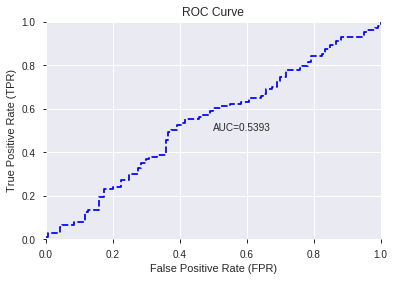

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


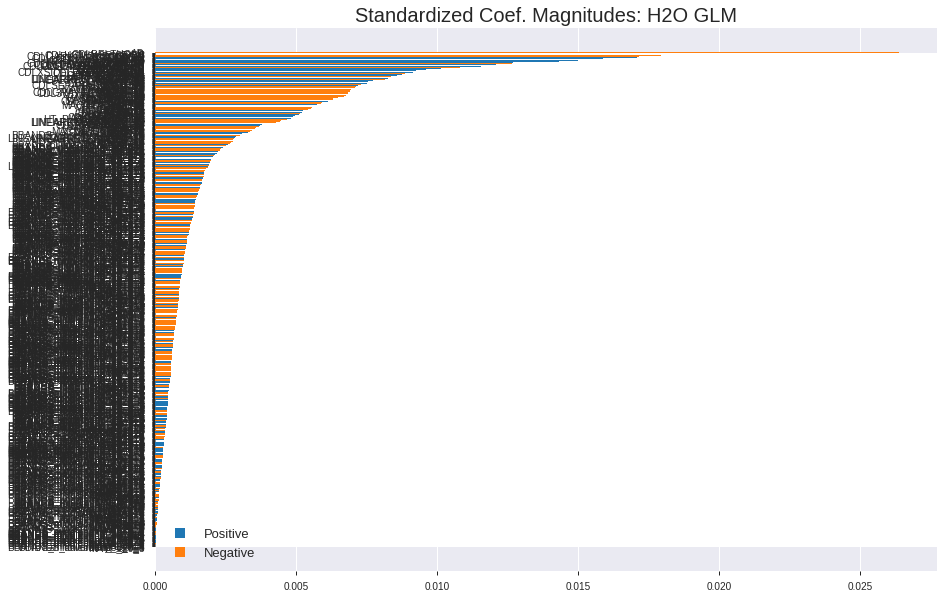

'log_likelihood'
--2019-09-03 04:18:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_041723_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_041723_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['AD',
 'CDLBELTHOLD',
 'DX_8',
 'CDLHOMINGPIGEON',
 'aroonup_30',
 'CDLDARKCLOUDCOVER',
 'DX_12',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'DX_14',
 'DX_24',
 'DX_20',
 'CDLRICKSHAWMAN',
 'aroonup_14',
 'DX_30',
 'CDLONNECK',
 'aroondown_14',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLSTALLEDPATTERN',
 'AROONOSC_30',
 'CDLLADDERBOTTOM',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'aroonup_20',
 'CDLDOJISTAR',
 'MFI_14',
 'CDLPIERCING',
 'STOCH_slowd',
 'CDLINNECK',
 'AROONOSC_8',
 'CCI_8',
 'CDLXSIDEGAP3METHODS',
 'aroondown_8',
 'VAR_30',
 'CDLEVENINGSTAR',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLENGULFING',
 'MINUS_DM_8',
 'AROONOSC_20',
 'BETA_30',
 'PPO',
 'LINEARREG_ANGLE_24',
 'LINEARREG_SLOPE_24',
 'aroonup_12',
 'MACDEXT',
 'APO',
 'CDLSHOOTINGSTAR',
 'ATR_30',
 'ROCP_30',
 'ROCR_30',
 'ROC_30',
 'CDLMARUBOZU',
 'ROCR100_30',
 'OBV',
 'ADXR_12',
 'CDLSEPARATINGLINES',
 'MOM_30',
 'MINUS_DM_12',
 'VAR_12',
 'NATR_30',
 'MACDFIX_hist_24',
 'WILLR_14',


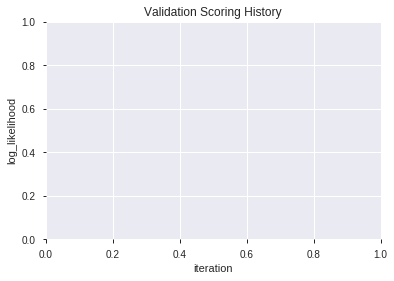

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190903_041806  0.608010  0.762180              0.459709  0.530708  0.281651
1  XGBoost_grid_1_AutoML_20190903_041806_model_7  0.600566  0.819935              0.463875  0.551326  0.303961
2  XGBoost_grid_1_AutoML_20190903_041806_model_2  0.590777  0.714273              0.404733  0.510178  0.260282
3  XGBoost_grid_1_AutoML_20190903_041806_model_4  0.589118  0.722849              0.487500  0.514179  0.264380
4  XGBoost_grid_1_AutoML_20190903_041806_model_6  0.569337  0.803620              0.453439  0.546058  0.298179
5  XGBoost_grid_1_AutoML_20190903_041806_model_5  0.559790  0.789363              0.479167  0.541061  0.292747
6               XGBoost_1_AutoML_20190903_041806  0.550283  0.773157              0.495833  0.534760  0.285968
7  XGBoost_grid_1_AutoML_20190903_041806_model_1  0.549029  0.848965              0.475688  0.564002  0.318098
8               XGBoost_2_AutoML_20190903_041806  0.538350  0.781884              0.500000  0.538838  0.290347
9  XGBoost_grid_1_AutoML_20190903_041806_model_3  0.510235  0.817623              0.487500  0.552427  0.305176

variable  relative_importance  scaled_importance  percentage
0                         AD           128.772583           1.000000    0.025026
1                        DIV            82.408440           0.639953    0.016016
2                    WILLR_8            81.626175           0.633879    0.015864
3       HT_PHASOR_quadrature            74.404030           0.577794    0.014460
4         LINEARREG_ANGLE_30            74.216545           0.576338    0.014424
..                       ...                  ...                ...         ...
301                   MA_8_8             0.854406           0.006635    0.000166
302  BBANDS_upperband_14_4_4             0.659029           0.005118    0.000128
303   BBANDS_upperband_8_8_2             0.430244           0.003341    0.000084
304  BBANDS_upperband_12_6_5             0.337973           0.002625    0.000066
305  BBANDS_middleband_8_3_3             0.246053           0.001911    0.000048

[306 rows x 4 columns]

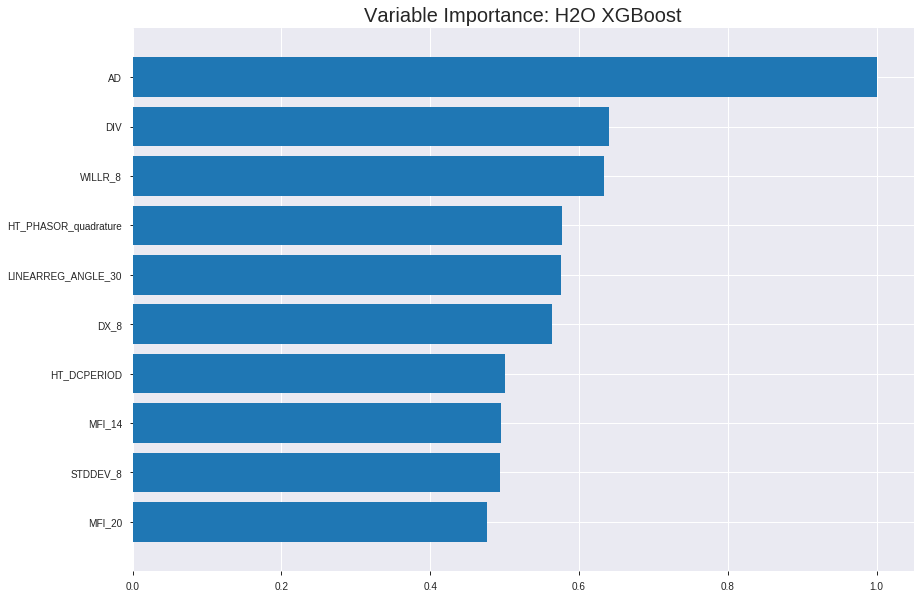

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190903_041806


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1752707290741514
RMSE: 0.4186534713508911
LogLoss: 0.5390429668067829
Mean Per-Class Error: 0.1188898625686623
AUC: 0.9529759252652364
pr_auc: 0.95344539274029
Gini: 0.9059518505304729
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997038145860036: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  115  0.1499   (115.0/767.0)
1      72   721  0.0908   (72.0/793.0)
Total  724  836  0.1199   (187.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499704     0.885206  208
max f2                       0.461627     0.927613  242
max f0point5                 0.531498     0.895417  179
max accuracy                 0.503378     0.88141   205
max precision                0.803559     1         0
max recall                   0.372263     1         324
max specificity              0.803559     1         0
max absolute_mcc             0.503378     0.76302   205
max min_per_class_accuracy   0.512538     0.876419  197
max mean_per_class_accuracy  0.503378     0.88111   205

Gains/Lift Table: Avg response rate: 50.83 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.73904            1.96721   1.96721            1                0.759319  1                           0.759319            0.0201765       0.0201765                  96.7213   96.7213
    2        0.0205128                   0.72318            1.96721   1.96721            1                0.730644  1                           0.744982            0.0201765       0.0403531                  96.7213   96.7213
    3        0.0301282                   0.708526           1.96721   1.96721            1                0.714834  1                           0.73536             0.0189155       0.0592686                  96.7213   96.7213
    4        0.0403846                   0.697879           1.96721   1.96721            1                0.702586  1                           0.727036            0.0201765       0.0794451                  96.7213   96.7213
    5        0.05                        0.689154           1.96721   1.96721            1                0.693774  1                           0.72064             0.0189155       0.0983607                  96.7213   96.7213
    6        0.1                         0.656911           1.96721   1.96721            1                0.669651  1                           0.695145            0.0983607       0.196721                   96.7213   96.7213
    7        0.15                        0.631843           1.96721   1.96721            1                0.642509  1                           0.6776              0.0983607       0.295082                   96.7213   96.7213
    8        0.2                         0.61252            1.89155   1.9483             0.961538         0.620909  0.990385                    0.663427            0.0945776       0.38966                    89.1551   94.8298
    9        0.3                         0.579423           1.89155   1.92938            0.961538         0.5958    0.980769                    0.640885            0.189155        0.578815                   89.1551   92.9382
    10       0.4                         0.54628            1.5889    1.84426            0.807692         0.561844  0.9375                      0.621124            0.15889         0.737705                   58.8903   84.4262
    11       0.5                         0.513244           1.3367    1.74275            0.679487         0.529297  0.885897                    0.602759            0.13367         0.871375                   33.6696   74.2749
    12       0.6                         0.47694            0.794451  1.5847             0.403846         0.494485  0.805556                    0.584713            0.0794451       0.95082                    -20.5549  58.4699
    13       0.7                         0.438732           0.37831   1.41236            0.192308         0.457912  0.717949                    0.566599            0.037831        0.988651                   -62.169   41.2358
    14       0.8                         0.398679           0.075662  1.24527            0.0384615        0.41831   0.633013                    0.548063            0.0075662       0.996217                   -92.4338  24.5271
    15       0.9                         0.351937           0.037831  1.11111            0.0192308        0.377202  0.564815                    0.529078            0.0037831       1                          -96.2169  11.1111
    16       1                           0.183835           0         1                  0                0.303648  0.508333                    0.506535         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2569641196605536
RMSE: 0.5069162846669591
LogLoss: 0.7082728287448716
Mean Per-Class Error: 0.45859257022047717
AUC: 0.5191583610188262
pr_auc: 0.4814403705422217
Gini: 0.03831672203765235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2764190137386322: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    230  0.9957   (230.0/231.0)
1      0    215  0        (0.0/215.0)
Total  1    445  0.5157   (230.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.276419     0.651515  398
max f2                       0.276419     0.823755  398
max f0point5                 0.455372     0.546613  281
max accuracy                 0.550534     0.540359  118
max precision                0.759695     1         0
max recall                   0.276419     1         398
max specificity              0.759695     1         0
max absolute_mcc             0.455372     0.091693  281
max min_per_class_accuracy   0.50354      0.502326  194
max mean_per_class_accuracy  0.455372     0.541407  281

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.731535           0.414884  0.414884           0.2              0.742681  0.2                         0.742681            0.00465116      0.00465116                 -58.5116   -58.5116
    2        0.0201794                   0.712445           1.55581   0.921964           0.75             0.724132  0.444444                    0.734437            0.0139535       0.0186047                  55.5814    -7.80362
    3        0.0313901                   0.69753            0.414884  0.740864           0.2              0.705635  0.357143                    0.724151            0.00465116      0.0232558                  -58.5116   -25.9136
    4        0.0403587                   0.678825           0.518605  0.691473           0.25             0.690775  0.333333                    0.716734            0.00465116      0.027907                   -48.1395   -30.8527
    5        0.0515695                   0.666287           1.24465   0.811729           0.6              0.67277   0.391304                    0.707176            0.0139535       0.0418605                  24.4651    -18.8271
    6        0.100897                    0.621741           0.942918  0.875866           0.454545         0.637058  0.422222                    0.672896            0.0465116       0.0883721                  -5.70825   -12.4134
    7        0.150224                    0.592657           1.22579   0.990767           0.590909         0.606007  0.477612                    0.650933            0.0604651       0.148837                   22.5793    -0.923291
    8        0.201794                    0.572591           1.1725    1.03721            0.565217         0.580676  0.5                         0.632978            0.0604651       0.209302                   17.2497    3.72093
    9        0.300448                    0.548056           1.17865   1.08365            0.568182         0.559685  0.522388                    0.608912            0.116279        0.325581                   17.8647    8.36515
    10       0.401345                    0.525763           0.783669  1.00824            0.377778         0.536258  0.486034                    0.590647            0.0790698       0.404651                   -21.6331   0.823698
    11       0.5                         0.500359           0.990063  1.00465            0.477273         0.511924  0.484305                    0.575114            0.0976744       0.502326                   -0.993658  0.465116
    12       0.600897                    0.478883           1.15245   1.02947            0.555556         0.48893   0.496269                    0.560643            0.116279        0.618605                   15.2455    2.94689
    13       0.699552                    0.459964           1.1315    1.04386            0.545455         0.468852  0.503205                    0.547698            0.111628        0.730233                   13.1501    4.38581
    14       0.800448                    0.433476           0.783669  1.01106            0.377778         0.448738  0.487395                    0.535224            0.0790698       0.809302                   -21.6331   1.10612
    15       0.899103                    0.394122           0.895772  0.998411           0.431818         0.415776  0.481297                    0.522117            0.0883721       0.897674                   -10.4228   -0.158905
    16       1                           0.269519           1.01416   1                  0.488889         0.354898  0.482063        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:18:17  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.491667                         0.5                0.693147              0.5               0                    1                  0.517937
    2019-09-03 04:18:18  1.044 sec   5                  0.488923         0.671199            0.799742        0.800506           1.96721          0.298077                         0.4992             0.691554              0.546703          0.512252             0.829767           0.517937
    2019-09-03 04:18:18  1.238 sec   10                 0.480091         0.653921            0.839036        0.833346           1.96721          0.255769                         0.500624           0.694429              0.511739          0.4833               0.414884           0.517937
    2019-09-03 04:18:18  1.431 sec   15                 0.471093         0.636527            0.861932        0.859528           1.96721          0.225641                         0.502159           0.697599              0.511557          0.474455             0.829767           0.513453
    2019-09-03 04:18:18  1.624 sec   20                 0.462974         0.621046            0.886168        0.883695           1.96721          0.200641                         0.501965           0.69721               0.518997          0.481766             0.829767           0.511211
    2019-09-03 04:18:19  1.824 sec   25                 0.453138         0.602491            0.907949        0.906949           1.96721          0.183974                         0.502909           0.699212              0.517568          0.484119             1.24465            0.513453
    2019-09-03 04:18:19  2.010 sec   30                 0.446941         0.590898            0.921101        0.920687           1.96721          0.171795                         0.504798           0.703281              0.513984          0.480534             1.24465            0.513453
    2019-09-03 04:18:19  2.211 sec   35                 0.438837         0.575752            0.926798        0.925136           1.96721          0.161538                         0.505513           0.704694              0.505225          0.475867             1.24465            0.508969
    2019-09-03 04:18:19  2.420 sec   40                 0.431925         0.563035            0.937238        0.937001           1.96721          0.140385                         0.506029           0.705918              0.508527          0.475203             0.829767           0.511211
    2019-09-03 04:18:19  2.617 sec   45                 0.425037         0.550552            0.94742         0.947559           1.96721          0.130128                         0.505476           0.704994              0.520689          0.481419             0.829767           0.513453
    2019-09-03 04:18:20  2.837 sec   50                 0.418653         0.539043            0.952976        0.953445           1.96721          0.119872                         0.506916           0.708273              0.519158          0.48144              0.414884           0.515695

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
AD                       128.7725830078125      1.0                    0.025026248734652957
DIV                      82.40843963623047      0.639953301482124      0.01601563050145399
WILLR_8                  81.62617492675781      0.6338785246064812     0.01586360162435663
HT_PHASOR_quadrature     74.4040298461914       0.5777940312160811     0.01446001714261148
LINEARREG_ANGLE_30       74.21654510498047      0.5763380944255644     0.014423580506350077
---                      ---                    ---                    ---
MA_8_8                   0.8544063568115234     0.00663500208549585    0.00016604921254656025
BBANDS_upperband_14_4_4  0.6590290069580078     0.005117774230854911   0.00012807869086917223
BBANDS_upperband_8_8_2   0.43024444580078125    0.0033411183945473762  8.361565999386699e-05
BBANDS_upperband_12_6_5  0.33797264099121094    0.0026245698664808677  6.56831383000251e-05
BBANDS_middleband_8_3_3  0.24605274200439453    0.001910754108189837   4.7819007582318844e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6098654708520179)

('F1', 0.6474358974358975)

('auc', 0.6080097087378641)

('logloss', 0.7621800827421975)

('mean_per_class_error', 0.3975728155339806)

('rmse', 0.5307084295155311)

('mse', 0.2816514371588414)

xgboost prediction progress: |████████████████████████████████████████████| 100%


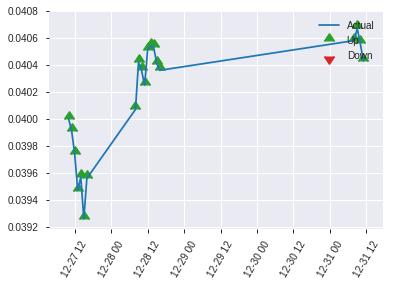


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2816514371588414
RMSE: 0.5307084295155311
LogLoss: 0.7621800827421975
Mean Per-Class Error: 0.3975728155339806
AUC: 0.6080097087378641
pr_auc: 0.5416121025386561
Gini: 0.21601941747572817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.498176634311676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   108  0.9      (108.0/120.0)
1      2    101  0.0194   (2.0/103.0)
Total  14   209  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498177     0.647436  208
max f2                       0.418677     0.814873  219
max f0point5                 0.696613     0.571429  87
max accuracy                 0.696613     0.609865  87
max precision                0.733108     0.666667  35
max recall                   0.418677     1         219
max specificity              0.792867     0.991667  0
max absolute_mcc             0.696613     0.208952  87
max min_per_class_accuracy   0.683814     0.566667  110
max mean_per_class_accuracy  0.696613     0.602427  87

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 66.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.778709           0.721683  0.721683           0.333333         0.786131  0.333333                    0.786131            0.00970874      0.00970874                 -27.8317  -27.8317
    2        0.0224215                   0.775796           1.08252   0.866019           0.5              0.777264  0.4                         0.782584            0.00970874      0.0194175                  8.25243   -13.3981
    3        0.0313901                   0.770429           0         0.618585           0                0.774391  0.285714                    0.780243            0               0.0194175                  -100      -38.1415
    4        0.0403587                   0.766403           2.16505   0.962244           1                0.768376  0.444444                    0.777606            0.0194175       0.038835                   116.505   -3.77562
    5        0.0538117                   0.761376           1.44337   1.08252            0.666667         0.763673  0.5                         0.774123            0.0194175       0.0582524                  44.3366   8.25243
    6        0.103139                    0.742936           1.57458   1.31786            0.727273         0.752277  0.608696                    0.763675            0.0776699       0.135922                   57.4581   31.7856
    7        0.152466                    0.734296           1.57458   1.40091            0.727273         0.738833  0.647059                    0.755638            0.0776699       0.213592                   57.4581   40.0914
    8        0.201794                    0.727254           1.18094   1.34714            0.545455         0.730777  0.622222                    0.749561            0.0582524       0.271845                   18.0936   34.7141
    9        0.300448                    0.708068           0.984113  1.22794            0.454545         0.716922  0.567164                    0.738844            0.0970874       0.368932                   -1.5887   22.7938
    10       0.399103                    0.695791           1.37776   1.26497            0.636364         0.701299  0.58427                     0.729563            0.135922        0.504854                   37.7758   26.4972
    11       0.502242                    0.683347           0.75306   1.15985            0.347826         0.689471  0.535714                    0.72133             0.0776699       0.582524                   -24.694   15.9847
    12       0.600897                    0.666119           0.984113  1.131              0.454545         0.676007  0.522388                    0.713889            0.0970874       0.679612                   -1.5887   13.0996
    13       0.699552                    0.647745           1.08252   1.12416            0.5              0.65567   0.519231                    0.705678            0.106796        0.786408                   8.25243   12.416
    14       0.798206                    0.608728           0.393645  1.03387            0.181818         0.631226  0.477528                    0.696476            0.038835        0.825243                   -60.6355  3.38715
    15       0.896861                    0.530714           1.08252   1.03922            0.5              0.579482  0.48                        0.683607            0.106796        0.932039                   8.25243   3.92233
    16       1                           0.382835           0.658928  1                  0.304348         0.472789  0.461883                    0.661863      

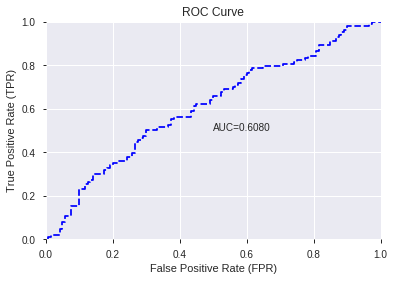

This function is available for GLM models only


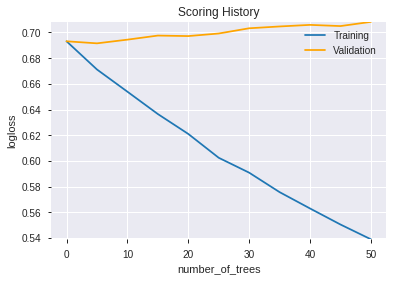

--2019-09-03 04:18:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190903_041806',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190903_041806',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9203',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_9203',
   'ty

['AD',
 'DIV',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'LINEARREG_ANGLE_30',
 'DX_8',
 'HT_DCPERIOD',
 'MFI_14',
 'STDDEV_8',
 'MFI_20',
 'ULTOSC',
 'BETA_30',
 'ADX_24',
 'CCI_8',
 'PLUS_DM_8',
 'TRIX_8',
 'PPO',
 'MOM_20',
 'ATR_24',
 'PLUS_DI_20',
 'STDDEV_12',
 'OBV',
 'BETA_12',
 'MINUS_DM_30',
 'ROC_8',
 'STOCHRSI_fastd',
 'BBANDS_upperband_12_7_2',
 'NATR_8',
 'BETA_14',
 'WILLR_12',
 'ADXR_8',
 'MINUS_DI_24',
 'ADOSC',
 'DX_24',
 'ATR_12',
 'MACDEXT',
 'aroonup_30',
 'DX_12',
 'STOCH_slowk',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'ADXR_14',
 'MFI_12',
 'MOM_30',
 'LINEARREG_ANGLE_14',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_24',
 'DX_20',
 'STOCHF_fastk',
 'BBANDS_upperband_8_7_4',
 'ATR_8',
 'DX_30',
 'BBANDS_upperband_20_1_2',
 'aroondown_8',
 'BOP',
 'MACDEXT_signal',
 'TRANGE',
 'BBANDS_lowerband_12_0_3',
 'TYPPRICE',
 'MACDEXT_hist',
 'MINUS_DI_8',
 'AROONOSC_12',
 'BETA_24',
 'ADXR_12',
 'PLUS_DI_24',
 'ROC_24',
 'AROONOSC_8',
 'BBANDS_upperband_8_6_3',
 'MINUS_DI_20',
 'AT

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.632
GLM             0.578
XGBoost         0.610
dtype: float64

DeepLearning    GLM  XGBoost
All          0.574  0.565    0.601
DLF          0.623  0.578    0.601
Fwe          0.628  0.565    0.601
RFE          0.578  0.570    0.610
XGBF         0.632  0.578    0.601





F1


DeepLearning    0.644
GLM             0.643
XGBoost         0.647
dtype: float64

DeepLearning    GLM  XGBoost
All          0.644  0.632    0.638
DLF          0.636  0.643    0.638
Fwe          0.641  0.632    0.638
RFE          0.638  0.632    0.647
XGBF         0.634  0.643    0.638





auc


DeepLearning    0.634
GLM             0.579
XGBoost         0.608
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.540    0.598
DLF          0.615  0.579    0.603
Fwe          0.616  0.540    0.598
RFE          0.558  0.539    0.608
XGBF         0.634  0.579    0.603





logloss


DeepLearning    2.229
GLM             0.746
XGBoost         0.762
dtype: float64

DeepLearning    GLM  XGBoost
All          1.688  0.738    0.715
DLF          0.834  0.692    0.715
Fwe          2.229  0.738    0.715
RFE          0.739  0.746    0.762
XGBF         1.224  0.692    0.715





mean_per_class_error


DeepLearning    0.432
GLM             0.436
XGBoost         0.404
dtype: float64

DeepLearning    GLM  XGBoost
All          0.423  0.436    0.402
DLF          0.380  0.421    0.404
Fwe          0.388  0.436    0.402
RFE          0.432  0.432    0.398
XGBF         0.368  0.421    0.404





rmse


DeepLearning    0.674
GLM             0.524
XGBoost         0.531
dtype: float64

DeepLearning    GLM  XGBoost
All          0.674  0.521    0.510
DLF          0.530  0.499    0.510
Fwe          0.606  0.521    0.510
RFE          0.521  0.524    0.531
XGBF         0.586  0.499    0.510





mse


DeepLearning    0.455
GLM             0.275
XGBoost         0.282
dtype: float64

DeepLearning    GLM  XGBoost
All          0.455  0.272    0.260
DLF          0.281  0.249    0.260
Fwe          0.367  0.272    0.260
RFE          0.271  0.275    0.282
XGBF         0.344  0.249    0.260

{'F1':       DeepLearning    GLM  XGBoost
 All          0.644    NaN      NaN
 DLF          0.636    NaN      NaN
 DLF            NaN  0.643      NaN
 DLF            NaN    NaN    0.638
 All            NaN  0.632      NaN
 All            NaN    NaN    0.638
 XGBF         0.634    NaN      NaN
 XGBF           NaN  0.643      NaN
 XGBF           NaN    NaN    0.638
 Fwe          0.641    NaN      NaN
 Fwe            NaN  0.632      NaN
 Fwe            NaN    NaN    0.638
 RFE          0.638    NaN      NaN
 RFE            NaN  0.632      NaN
 RFE            NaN    NaN    0.647,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.574    NaN      NaN
 DLF          0.623    NaN      NaN
 DLF            NaN  0.578      NaN
 DLF            NaN    NaN    0.601
 All            NaN  0.565      NaN
 All            NaN    NaN    0.601
 XGBF         0.632    NaN      NaN
 XGBF           NaN  0.578      NaN
 XGBF           NaN    NaN    0.601
 Fwe          0.628    NaN      NaN
 Fwe     